# Хакатон Лента: разработка алгоритма и интерфейса предсказательной модели 

### Общая задача

Необходимо создать интерфейс и алгоритм прогноза спроса на 14 дней для товаров
собственного производства.  
Гранулярность ТК-SKU-День.  

Прогноз позволит повысить доступность и продажи в ТК, без повышения списаний и
повышение маржинальности. При изготовлении товаров СП сотрудники будут
ориентироваться не на экспертный подход, а на ML прогноз спроса, в соответствии с
которым будут изготавливать продукцию и планировать заказы сырья.

### Задача DS

Разработать пайплайн прогноза спроса товаров категории "Собственное производство" в штуках и построить прогноз на 14 дней в будущее. Ежедневное обновление.  

Финальный результат работы пайплайна - это отчёт/таблица, в которой строим
прогноз спроса по товарам, в каком количестве необходимо их приготовить в каждом ТК,
для повышения доступности товаров на полке, для увеличения продаж, без увеличения
списаний.

Метрики точности: **WAPE** формула def wape(y_true: np.array, y_pred: np.array):
return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true)).

### Описание данных

1) sales_df_train.csv –данные по продажам за скользящий год для обучения.  

Столбцы:
 - st_id – захэшированное id магазина;
 - pr_sku_id – захэшированное id товара;
 - date – дата;
 - pr_sales_type_id – флаг наличия промо;
 - pr_sales_in_units – число проданных товаров всего (промо и без);
 - pr_promo_sales_in_units – число проданных товаров с признаком промо;
 - pr_sales_in_rub – продажи в руб всего (промо и без);
 - pr_promo_sales_in_rub – продажи с признаком промо в руб;

2) pr_df.csv – данные по товарной иерархии.
От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.  

Столбцы:
 - pr_group_id – захэшированная группа товара;
 - pr_cat_id – захэшированная категория товара;
 - pr_subcat_id – захэшированная подкатегория товара;
 - pr_sku_id – захэшированное id товара;
 - pr_uom_id (маркер, обозначающий продаётся товар на вес или в шт).

3) pr_st.csv – данные по магазинам.  

Столбцы:
 - st_id – захэшированное id магазина;
 - st_city_id – захэшированное id города;
 - st_division_code id – захэшированное id дивизиона;
 - st_type_format_id – id формата магазина;
 - st_type_loc_id – id тип локации/окружения магазина;
 - st_type_size_id – id типа размера магазина;
 - st_is_active – флаг активного магазина на данный момент.

4) sales_submission.csv – пример файла с результатом работы модели прогноза спроса.

Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по
умолчанию колонка заполнена нулями).

Столбцы:
 - st_id – захэшированное id магазина;
 - pr_sku_id – захэшированное id товара;
 - date – дата (день);
 - target – спрос в шт.

### План работы

1. Preprocessing
 - загружаем файлы
 - смотрим что можно использовать для обучения модели, удаляем аномалии
 - объединяем данные
2. EDA
 - детекция выбросов etna
 - заполнение пропусков etna
 - анализ продаж по товарам и магазинам
 - анализ временных рядов
3. Feature Engineering и Feature Selection
 - tsfresh
 - prophet
 - кластеризация
4. Modeling
 - подбор гиперпараметров модели
 - заполнение файла sales_submission
5. Feature Importances и анализ ошибок модели

### 1. Preprocessing

In [89]:
# Импорты бибилиотек
import os
import json
import time
import warnings
from joblib import load, dump
from tqdm import tqdm
from tqdm.autonotebook import tqdm

import shap
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from etna.analysis import get_anomalies_density
from etna.analysis import plot_anomalies
from etna.analysis import plot_imputation
from etna.transforms import TimeSeriesImputerTransform
from etna.datasets import TSDataset
from etna.transforms import DensityOutliersTransform

from tsfresh import extract_relevant_features, extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

import catboost as cb
import xgboost as xgb
import lightgbm as lgb
import optuna
import pickle
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from datetime import datetime, timedelta
from typing import Dict, Tuple
from window_ops.rolling import rolling_mean, rolling_max, rolling_min
from mlforecast import MLForecast
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, silhouette_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from tslearn.clustering import TimeSeriesKMeans 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from model import Preprocessor, Optimizer, Predictor, types_changing
from config import DATA_PATH, RANDOM_STATE, models

# Отключим предупреждения
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Константы
RANDOM_STATE = 112233
# Количество дней в тестовой выборке
test_days = 14
# Количество фолдов в cv
n_folds = 5

#### 1.1 Загружаем данные

In [3]:
# Прочитаем файлы 
df = {}
for file in ['sales_df_train', 'pr_df', 'st_df', 'sales_submission']:
    df[file] = pd.read_csv(f'data/{file}.csv')

#### pr_df.csv

In [4]:
# Посмотрим на данные
df['pr_df'].head(10)

pr_sku_id                       pr_group_id  \
0  fd064933250b0bfe4f926b867b0a5ec8  c74d97b01eae257e44aa9d5bade97baf   
1  71c9661741caf40a92a32d1cc8206c04  c74d97b01eae257e44aa9d5bade97baf   
2  00b72c2f01a1512cbb1d3f33319bac93  c74d97b01eae257e44aa9d5bade97baf   
3  9bc40cd2fe4f188f402bb41548c5e15c  c74d97b01eae257e44aa9d5bade97baf   
4  3a74a370c8eb032acb11ad9119242b8f  c74d97b01eae257e44aa9d5bade97baf   
5  382fcb7b0b5750896a5bef348f19bddc  c74d97b01eae257e44aa9d5bade97baf   
6  cff633e270708ced01bc585eb1421667  c74d97b01eae257e44aa9d5bade97baf   
7  1cfd4c9cd7289a63dc2492f2b0200868  c74d97b01eae257e44aa9d5bade97baf   
8  c7e043e0f743476582f79ba27ba3c51f  c74d97b01eae257e44aa9d5bade97baf   
9  f9ee6d53edebe412feb1118b618900c8  c74d97b01eae257e44aa9d5bade97baf   

                          pr_cat_id                      pr_subcat_id  \
0  1bc0249a6412ef49b07fe6f62e6dc8de  ca34f669ae367c87f0e75dcae0f61ee5   
1  c559da2ba967eb820766939a658022c8  e06f5ed77191826c212c30722f2cc5a2   
2  1bc0249a6412ef49b07fe6f62e6dc8de  d407a3ebb4ab9b0d68b224486f8b8dad   
3  1bc0249a6412ef49b07fe6f62e6dc8de  ca34f669ae367c87f0e75dcae0f61ee5   
4  c559da2ba967eb820766939a658022c8  e06f5ed77191826c212c30722f2cc5a2   
5  1bc0249a6412ef49b07fe6f62e6dc8de  83b5bd3157dca7df5e5e337a7f3143bc   
6  c559da2ba967eb820766939a658022c8  e06f5ed77191826c212c30722f2cc5a2   
7  1bc0249a6412ef49b07fe6f62e6dc8de  d407a3ebb4ab9b0d68b224486f8b8dad   
8  1bc0249a6412ef49b07fe6f62e6dc8de  ca34f669ae367c87f0e75dcae0f61ee5   
9  1bc0249a6412ef49b07fe6f62e6dc8de  d407a3ebb4ab9b0d68b224486f8b8dad   

   pr_uom_id  
0         17  
1         17  
2         17  
3         17  
4         17  
5         17  
6         17  
7         17  
8         17  
9         17

In [5]:
# Оценим описательные статистики
df['pr_df'].describe(include = 'all')

pr_sku_id                       pr_group_id  \
count                               2050                              2050   
unique                              2050                                 9   
top     fd064933250b0bfe4f926b867b0a5ec8  c74d97b01eae257e44aa9d5bade97baf   
freq                                   1                               806   
mean                                 NaN                               NaN   
std                                  NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   

                               pr_cat_id                      pr_subcat_id  \
count                               2050                              2050   
unique                                43                               170   
top     c559da2ba967eb820766939a658022c8  8feef08314d477a5b68ba18a6d35819d   
freq                                 265                                72   
mean                                 NaN                               NaN   
std                                  NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   

          pr_uom_id  
count   2050.000000  
unique          NaN  
top             NaN  
freq            NaN  
mean       7.017561  
std        7.752371  
min        1.000000  
25%        1.000000  
50%        1.000000  
75%       17.000000  
max       17.000000

In [6]:
# Количество товаров, которые проадются штучно
len(df['pr_df'].loc[df['pr_df']['pr_uom_id'] == 1])

1279

In [7]:
# Количество товаров, которые проадются весом
len(df['pr_df'].loc[df['pr_df']['pr_uom_id'] == 17])

771

Всего товаров 2050 в 9 группах - 43 категории и 170 подкатегорий. В столбце pr_uom_id (маркер, обозначающий продаётся товар на вес или в шт) данные разделились таким образом: 1279 товаров в группе 1 и 771 товар в группе 17.

#### st_df.csv

In [8]:
# Посмотрим на данные
df['st_df'].head(20)

st_id                        st_city_id  \
0   1aa057313c28fa4a40c5bc084b11d276  1587965fb4d4b5afe8428a4a024feb0d   
1   bd470ca955d9497bbcb808e59952fffc  955d864a62659945cc9434898e275deb   
2   6364d3f0f495b6ab9dcf8d3b5c6e0b01  b8b4b727d6f5d1b61fff7be687f7970f   
3   1ecfb463472ec9115b10c292ef8bc986  908c9a564a86426585b29f5335b619bc   
4   16a5cdae362b8d27a1d8f8c7b78b4330  c1f75cc0f7fe269dd0fd9bd5e24f9586   
5   53e19f3dbb211f20b20b45668303c1b6  955d864a62659945cc9434898e275deb   
6   42a0e188f5033bc65bf8d78622277c4e  b8b4b727d6f5d1b61fff7be687f7970f   
7   c81e728d9d4c2f636f067f89cc14862c  908c9a564a86426585b29f5335b619bc   
8   fa7cdfad1a5aaf8370ebeda47a1ff1c3  885fe656777008c335ac96072a45be15   
9   f7e6c85504ce6e82442c770f7c8606f0  3202111cf90e7c816a472aaceb72b0df   
10  62f91ce9b820a491ee78c108636db089  1587965fb4d4b5afe8428a4a024feb0d   
11  084a8a9aa8cced9175bd07bc44998e75  3202111cf90e7c816a472aaceb72b0df   

                    st_division_code  st_type_format_id  st_type_loc_id  \
0   81b4dd343f5880df806d4c5d4a846c64                  4               3   
1   e26072c92d8fe0738df44d571d5f5e8b                  4               3   
2   da742b3cfca5388aaf9af28a726a3c30                  1               1   
3   429a86ff6336c144ddaf6144f52ab52c                  2               1   
4   296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
5   e26072c92d8fe0738df44d571d5f5e8b                  4               3   
6   da742b3cfca5388aaf9af28a726a3c30                  1               1   
7   429a86ff6336c144ddaf6144f52ab52c                  1               1   
8   296bd0cc6e735f9d7488ebc8fbc19130                  1               1   
9   32586311f16876abf92901085bd87b99                  1               1   
10  81b4dd343f5880df806d4c5d4a846c64                  4               3   
11  32586311f16876abf92901085bd87b99                  4               3   

    st_type_size_id  st_is_active  
0                19             0  
1                19             1  
2                12             1  
3                28             1  
4                 8             1  
5                20             1  
6                12             1  
7                 8             1  
8                12             1  
9                12             1  
10               32             0  
11               19             1

In [9]:
df['st_df'].describe(include = 'all')

st_id                        st_city_id  \
count                                 12                                12   
unique                                12                                 7   
top     1aa057313c28fa4a40c5bc084b11d276  1587965fb4d4b5afe8428a4a024feb0d   
freq                                   1                                 2   
mean                                 NaN                               NaN   
std                                  NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   

                        st_division_code  st_type_format_id  st_type_loc_id  \
count                                 12          12.000000       12.000000   
unique                                 6                NaN             NaN   
top     81b4dd343f5880df806d4c5d4a846c64                NaN             NaN   
freq                                   2                NaN             NaN   
mean                                 NaN           2.333333        1.916667   
std                                  NaN           1.497473        0.996205   
min                                  NaN           1.000000        1.000000   
25%                                  NaN           1.000000        1.000000   
50%                                  NaN           1.500000        1.500000   
75%                                  NaN           4.000000        3.000000   
max                                  NaN           4.000000        3.000000   

        st_type_size_id  st_is_active  
count         12.000000     12.000000  
unique              NaN           NaN  
top                 NaN           NaN  
freq                NaN           NaN  
mean          16.750000      0.833333  
std            7.557356      0.389249  
min            8.000000      0.000000  
25%           12.000000      1.000000  
50%           15.500000      1.000000  
75%           19.250000      1.000000  
max           32.000000      1.000000

In [10]:
df['st_df']['st_is_active'].sum()

10

In [11]:
# id неактивных магазинов
df['st_df'].loc[df['st_df']['st_is_active'] == 0, 'st_id']

0     1aa057313c28fa4a40c5bc084b11d276
10    62f91ce9b820a491ee78c108636db089
Name: st_id, dtype: object

12 магазинов в 7 городах. Дивизионов - 6. Форматов магазинов - 3 (1, 2, 4). Типов локации - 3 (1, 2, 3). Типов размера магазина - 6 (8, 12, 19, 20, 28, 32). Активных магазинов - 10. По неактивным магазинам прогноз строить не будем.

#### sales_submission.csv

In [12]:
# Посмотрим на данные
df['sales_submission'].head(10)

st_id                         pr_sku_id  \
0  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
1  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
2  16a5cdae362b8d27a1d8f8c7b78b4330  0094042bfeae507dc7f62acc8e5ed03a   
3  16a5cdae362b8d27a1d8f8c7b78b4330  0169529ff660adcac9b7e354e0c4b882   
4  16a5cdae362b8d27a1d8f8c7b78b4330  01e4734745e97e52d3213449e1a05dd7   
5  16a5cdae362b8d27a1d8f8c7b78b4330  02713435f3587e2c81d8f6a9016763ea   
6  16a5cdae362b8d27a1d8f8c7b78b4330  0448c8afc036bb44c457d7e9edd74c50   
7  16a5cdae362b8d27a1d8f8c7b78b4330  050a8120e2a3b8751df8752fcc0323ef   
8  16a5cdae362b8d27a1d8f8c7b78b4330  06076bf3c802444ebc7d5619ab64ceb6   
9  16a5cdae362b8d27a1d8f8c7b78b4330  064e3a5648fb4a7f911155bd81f87fd2   

         date  target  
0  2023-07-20       0  
1  2023-07-20       0  
2  2023-07-20       0  
3  2023-07-20       0  
4  2023-07-20       0  
5  2023-07-20       0  
6  2023-07-20       0  
7  2023-07-20       0  
8  2023-07-20       0  
9  2023-07-20       0

In [13]:
# Посмотрим на какие даты нужно делать прогноз
df['sales_submission']['date'].unique()

array(['2023-07-20', '2023-07-21', '2023-07-22', '2023-07-24',
       '2023-07-25', '2023-07-26', '2023-07-27', '2023-07-28',
       '2023-07-19', '2023-07-23', '2023-07-29', '2023-07-30',
       '2023-07-31', '2023-08-01'], dtype=object)

In [14]:
# Посчитаем сколько уникальных магазинов в файле
len(df['sales_submission']['st_id'].unique())

8

In [15]:
shops = df['sales_submission']['st_id'].unique()

Это образец файла для заполнения прогнозов обученной моделью. Спрогнозировать спрос нужно на 15 дней за период с 19 июля - 01 августа 2023г. 

#### sales_df_train.csv

In [16]:
# Посмотрим на данные
df['sales_df_train'].head()

st_id                         pr_sku_id  \
0  c81e728d9d4c2f636f067f89cc14862c  c7b711619071c92bef604c7ad68380dd   
1  42a0e188f5033bc65bf8d78622277c4e  68f441429e73dbd33b81f95da31576e9   
2  1ecfb463472ec9115b10c292ef8bc986  22988026fe85fde60d8bf777ab6bc3b4   
3  42a0e188f5033bc65bf8d78622277c4e  8e887cf8e64ab8e7173701a979476567   
4  16a5cdae362b8d27a1d8f8c7b78b4330  e6fc24ca846339d204b0b50e9f772484   

         date  pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
0  2022-10-20                 1                5.0                      5.0   
1  2023-01-29                 0                4.0                      0.0   
2  2023-03-02                 0                1.0                      0.0   
3  2023-04-05                 1                0.0                      0.0   
4  2023-02-17                 0                1.0                      0.0   

   pr_sales_in_rub  pr_promo_sales_in_rub  
0            825.0                  825.0  
1            196.0                    0.0  
2             78.0                    0.0  
3             69.0                   69.0  
4            161.0                    0.0

In [17]:
# Видны строки с нулевыми общими продажами, оценим сколько таких
print(f"Строк с нулевым числом проданных товаров {len(df['sales_df_train'].loc[df['sales_df_train']['pr_sales_in_units'] == 0])}")
print(f"Из них строк с нулевыми продажами в руб {len(df['sales_df_train'].loc[(df['sales_df_train']['pr_sales_in_units'] == 0)&(df['sales_df_train']['pr_sales_in_rub'] == 0)])}")
print(f"% строк с нулевым числом проданных товаров {round(len(df['sales_df_train'].loc[df['sales_df_train']['pr_sales_in_units'] == 0])*100/df['sales_df_train'].shape[0], 2)}")

Строк с нулевым числом проданных товаров 66543
Из них строк с нулевыми продажами в руб 454
% строк с нулевым числом проданных товаров 7.54


In [18]:
# Удалим строки для которых число проданных товаров = 0, но при этом столбец продажа в руб отличается от 0
df['sales_df_train'] = df['sales_df_train'].loc[~((df['sales_df_train']['pr_sales_in_units'] == 0)&(df['sales_df_train']['pr_sales_in_rub'] != 0))]

In [19]:
# Переведем столбец date в фомат даты
df['sales_df_train']['date'] = pd.to_datetime(df['sales_df_train']['date'], format='%Y-%m-%d')

In [20]:
# Проверим есть ли строки у которых продажи в руб = 0, а продажи в единицах отличаются от 0
df['sales_df_train'].loc[(df['sales_df_train']['pr_sales_in_rub'] == 0)&(df['sales_df_train']['pr_sales_in_units'] != 0)]

st_id                         pr_sku_id  \
30      f7e6c85504ce6e82442c770f7c8606f0  3474f0e025c7deb7e127a35763bc5512   
6313    53e19f3dbb211f20b20b45668303c1b6  ee21c04f96ab30a8b3ca761e57e016ca   
7432    c81e728d9d4c2f636f067f89cc14862c  90252502ab29331e94fd3113f11c58e0   
8153    f7e6c85504ce6e82442c770f7c8606f0  4e3d5c9fab3fc51a4857846fea3d2e57   
8931    f7e6c85504ce6e82442c770f7c8606f0  0f152427918d29bb1081834c1d375a48   
...                                  ...                               ...   
876801  1ecfb463472ec9115b10c292ef8bc986  525526d5b2169462195c44d49fff4a44   
878163  fa7cdfad1a5aaf8370ebeda47a1ff1c3  27e8978c9e8b7146c462feb7d24f5637   
882360  6364d3f0f495b6ab9dcf8d3b5c6e0b01  2dc922d957188fb51dd2bd50ec9b555a   
882380  f7e6c85504ce6e82442c770f7c8606f0  9da31b9d3cf407cd724c65b7dfed00ee   
882394  6364d3f0f495b6ab9dcf8d3b5c6e0b01  0f152427918d29bb1081834c1d375a48   

             date  pr_sales_type_id  pr_sales_in_units  \
30     2023-06-06                 1                8.0   
6313   2022-11-09                 1                1.0   
7432   2022-12-27                 1                2.0   
8153   2022-12-19                 1                1.0   
8931   2022-10-28                 1                2.0   
...           ...               ...                ...   
876801 2022-10-22                 1                1.0   
878163 2022-10-27                 1                9.0   
882360 2022-10-29                 1               12.0   
882380 2022-11-27                 1                3.0   
882394 2022-10-22                 1               11.0   

        pr_promo_sales_in_units  pr_sales_in_rub  pr_promo_sales_in_rub  
30                          8.0              0.0                    0.0  
6313                        1.0              0.0                    0.0  
7432                        2.0              0.0                    0.0  
8153                        1.0              0.0                    0.0  
8931                        2.0              0.0                    0.0  
...                         ...              ...                    ...  
876801                      1.0              0.0                    0.0  
878163                      9.0              0.0                    0.0  
882360                     12.0              0.0                    0.0  
882380                      3.0              0.0                    0.0  
882394                     11.0              0.0                    0.0  

[795 rows x 8 columns]

In [21]:
# Удалим такие строки
df['sales_df_train'] = df['sales_df_train'].loc[~((df['sales_df_train']['pr_sales_in_rub'] == 0)&
                                                  (df['sales_df_train']['pr_sales_in_units'] != 0))]

In [22]:
# Сгруппируем данные по каждому магазину

res = df['sales_df_train'].groupby('st_id', as_index=False).agg(
                                            pr_sku_id_count = ('pr_sku_id', 'nunique'),
                                            days_count = ('date', 'nunique'),
                                            date_min = ('date', 'min'),
                                            date_max = ('date', 'max'),
                                            promo_count = ('pr_sales_type_id', 'count')
    
)

res['promo/day'] = round(res['promo_count'] / res['days_count'], 2)
res['promo_count/goods/days'] = round((res['promo_count'] / res['pr_sku_id_count']) / res['days_count'], 2)
res

st_id  pr_sku_id_count  days_count   date_min  \
0   084a8a9aa8cced9175bd07bc44998e75                6          31 2023-03-26   
1   16a5cdae362b8d27a1d8f8c7b78b4330              952         352 2022-08-01   
2   1aa057313c28fa4a40c5bc084b11d276               39          31 2022-08-01   
3   1ecfb463472ec9115b10c292ef8bc986              251         352 2022-08-01   
4   42a0e188f5033bc65bf8d78622277c4e             1016         352 2022-08-01   
5   53e19f3dbb211f20b20b45668303c1b6              111         352 2022-08-01   
6   62f91ce9b820a491ee78c108636db089                2           6 2022-08-24   
7   6364d3f0f495b6ab9dcf8d3b5c6e0b01              887         352 2022-08-01   
8   bd470ca955d9497bbcb808e59952fffc               85         309 2022-08-01   
9   c81e728d9d4c2f636f067f89cc14862c             1074         352 2022-08-01   
10  f7e6c85504ce6e82442c770f7c8606f0              939         352 2022-08-01   
11  fa7cdfad1a5aaf8370ebeda47a1ff1c3              809         352 2022-08-01   

     date_max  promo_count  promo/day  promo_count/goods/days  
0  2023-06-29           38       1.23                    0.20  
1  2023-07-18       143980     409.03                    0.43  
2  2022-08-31          717      23.13                    0.59  
3  2023-07-18        46200     131.25                    0.52  
4  2023-07-18       128557     365.22                    0.36  
5  2023-07-18         9008      25.59                    0.23  
6  2022-09-08           10       1.67                    0.83  
7  2023-07-18       105332     299.24                    0.34  
8  2023-06-23         2495       8.07                    0.09  
9  2023-07-18       164784     468.14                    0.44  
10 2023-07-18       114224     324.50                    0.35  
11 2023-07-18       100786     286.32                    0.35

In [23]:
# Количество уникальных товаров по всем магазинам
len(df['sales_df_train']['pr_sku_id'].unique())

1973

В датафрейме содержится информация о продажах 1973 товара в 12 магазинах. Количество проданных товаров варьируется от 2 и 6 (эти магазины возможно закрыты или недавно открыты так для них указана информация только за 6 - 31 дней, всего таких магазинов 3) до 1074. Ассортимент товаров (их количество) скорее всего зависит от размера магазина. Период для большинства магазинов - 352 дня: от 01.08.2022 (10 магазинов из 12) до 18.07.2023 и один магазин 309 дней - до  23.06.2023

Видно, что промо-акции проводятся в среднем от 299 до 468 в день у 6 магазинов, еще 3 магазина предположительно закрылись или недавно открылись и по ним не корректо оценивать, у 3 магазинов количество проводимых акций колеблется от 8 - 131.

In [24]:
# Оставляем для дальнейшего анализа только активные магазины и те, которые есть в sales_submission
df['sales_df_train'] = df['sales_df_train'].loc[df['sales_df_train']['st_id'].isin(shops)]

In [25]:
# Добавим столбец с ценой
df['sales_df_train']['price'] = round(df['sales_df_train']['pr_sales_in_rub'] / df['sales_df_train']['pr_sales_in_units'], 2)

#### 1.2 Объединим данные

Объединим данные по продажам с данными по товарной иерархии и по магазинам.

In [26]:
# Объединяем sales_df_train и st_df
data = df['sales_df_train'].merge(df['st_df'], how='left', on='st_id')
data.head()

st_id                         pr_sku_id  \
0  c81e728d9d4c2f636f067f89cc14862c  c7b711619071c92bef604c7ad68380dd   
1  42a0e188f5033bc65bf8d78622277c4e  68f441429e73dbd33b81f95da31576e9   
2  1ecfb463472ec9115b10c292ef8bc986  22988026fe85fde60d8bf777ab6bc3b4   
3  16a5cdae362b8d27a1d8f8c7b78b4330  e6fc24ca846339d204b0b50e9f772484   
4  42a0e188f5033bc65bf8d78622277c4e  3474f0e025c7deb7e127a35763bc5512   

        date  pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
0 2022-10-20                 1                5.0                      5.0   
1 2023-01-29                 0                4.0                      0.0   
2 2023-03-02                 0                1.0                      0.0   
3 2023-02-17                 0                1.0                      0.0   
4 2022-11-03                 0                3.0                      0.0   

   pr_sales_in_rub  pr_promo_sales_in_rub  price  \
0            825.0                  825.0  165.0   
1            196.0                    0.0   49.0   
2             78.0                    0.0   78.0   
3            161.0                    0.0  161.0   
4            123.0                    0.0   41.0   

                         st_city_id                  st_division_code  \
0  908c9a564a86426585b29f5335b619bc  429a86ff6336c144ddaf6144f52ab52c   
1  b8b4b727d6f5d1b61fff7be687f7970f  da742b3cfca5388aaf9af28a726a3c30   
2  908c9a564a86426585b29f5335b619bc  429a86ff6336c144ddaf6144f52ab52c   
3  c1f75cc0f7fe269dd0fd9bd5e24f9586  296bd0cc6e735f9d7488ebc8fbc19130   
4  b8b4b727d6f5d1b61fff7be687f7970f  da742b3cfca5388aaf9af28a726a3c30   

   st_type_format_id  st_type_loc_id  st_type_size_id  st_is_active  
0                  1               1                8             1  
1                  1               1               12             1  
2                  2               1               28             1  
3                  1               2                8             1  
4                  1               1               12             1

In [27]:
# Удаляем ненужные столбцы
data = data.drop('st_is_active', axis = 1)

In [28]:
# Объединяем data и pr_df
data = data.merge(df['pr_df'], how='left', on='pr_sku_id')
data.head()

st_id                         pr_sku_id  \
0  c81e728d9d4c2f636f067f89cc14862c  c7b711619071c92bef604c7ad68380dd   
1  42a0e188f5033bc65bf8d78622277c4e  68f441429e73dbd33b81f95da31576e9   
2  1ecfb463472ec9115b10c292ef8bc986  22988026fe85fde60d8bf777ab6bc3b4   
3  16a5cdae362b8d27a1d8f8c7b78b4330  e6fc24ca846339d204b0b50e9f772484   
4  42a0e188f5033bc65bf8d78622277c4e  3474f0e025c7deb7e127a35763bc5512   

        date  pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
0 2022-10-20                 1                5.0                      5.0   
1 2023-01-29                 0                4.0                      0.0   
2 2023-03-02                 0                1.0                      0.0   
3 2023-02-17                 0                1.0                      0.0   
4 2022-11-03                 0                3.0                      0.0   

   pr_sales_in_rub  pr_promo_sales_in_rub  price  \
0            825.0                  825.0  165.0   
1            196.0                    0.0   49.0   
2             78.0                    0.0   78.0   
3            161.0                    0.0  161.0   
4            123.0                    0.0   41.0   

                         st_city_id                  st_division_code  \
0  908c9a564a86426585b29f5335b619bc  429a86ff6336c144ddaf6144f52ab52c   
1  b8b4b727d6f5d1b61fff7be687f7970f  da742b3cfca5388aaf9af28a726a3c30   
2  908c9a564a86426585b29f5335b619bc  429a86ff6336c144ddaf6144f52ab52c   
3  c1f75cc0f7fe269dd0fd9bd5e24f9586  296bd0cc6e735f9d7488ebc8fbc19130   
4  b8b4b727d6f5d1b61fff7be687f7970f  da742b3cfca5388aaf9af28a726a3c30   

   st_type_format_id  st_type_loc_id  st_type_size_id  \
0                  1               1                8   
1                  1               1               12   
2                  2               1               28   
3                  1               2                8   
4                  1               1               12   

                        pr_group_id                         pr_cat_id  \
0  aab3238922bcc25a6f606eb525ffdc56  28fc2782ea7ef51c1104ccf7b9bea13d   
1  c74d97b01eae257e44aa9d5bade97baf  1bc0249a6412ef49b07fe6f62e6dc8de   
2  c74d97b01eae257e44aa9d5bade97baf  f3173935ed8ac4bf073c1bcd63171f8a   
3  c74d97b01eae257e44aa9d5bade97baf  a368b0de8b91cfb3f91892fbf1ebd4b2   
4  c74d97b01eae257e44aa9d5bade97baf  1bc0249a6412ef49b07fe6f62e6dc8de   

                       pr_subcat_id  pr_uom_id  
0  d29b5ce9c2883f0b7e90f79071a2ca82          1  
1  68f204f3838bfee4ada868b66e6a0814         17  
2  5fd72b9fc7118bd36a137d7cea8c588a         17  
3  0d51481bbf77027ddb2c990cf97cd9dd          1  
4  ca34f669ae367c87f0e75dcae0f61ee5         17

In [29]:
# Сортируем по магазину, товару и по дате
data = data.sort_values(['st_id', 'pr_sku_id', 'date'])
data.head()

st_id                         pr_sku_id  \
291199  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
370200  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
622217  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
680868  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
90662   16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   

             date  pr_sales_type_id  pr_sales_in_units  \
291199 2023-07-13                 0                1.0   
370200 2023-07-14                 0                2.0   
622217 2023-07-15                 0                2.0   
680868 2023-07-16                 0                2.0   
90662  2023-07-18                 0                1.0   

        pr_promo_sales_in_units  pr_sales_in_rub  pr_promo_sales_in_rub  \
291199                      0.0             81.0                    0.0   
370200                      0.0            153.0                    0.0   
622217                      0.0            155.0                    0.0   
680868                      0.0            156.0                    0.0   
90662                       0.0             80.0                    0.0   

        price                        st_city_id  \
291199   81.0  c1f75cc0f7fe269dd0fd9bd5e24f9586   
370200   76.5  c1f75cc0f7fe269dd0fd9bd5e24f9586   
622217   77.5  c1f75cc0f7fe269dd0fd9bd5e24f9586   
680868   78.0  c1f75cc0f7fe269dd0fd9bd5e24f9586   
90662    80.0  c1f75cc0f7fe269dd0fd9bd5e24f9586   

                        st_division_code  st_type_format_id  st_type_loc_id  \
291199  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
370200  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
622217  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
680868  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
90662   296bd0cc6e735f9d7488ebc8fbc19130                  1               2   

        st_type_size_id                       pr_group_id  \
291199                8  c74d97b01eae257e44aa9d5bade97baf   
370200                8  c74d97b01eae257e44aa9d5bade97baf   
622217                8  c74d97b01eae257e44aa9d5bade97baf   
680868                8  c74d97b01eae257e44aa9d5bade97baf   
90662                 8  c74d97b01eae257e44aa9d5bade97baf   

                               pr_cat_id                      pr_subcat_id  \
291199  c559da2ba967eb820766939a658022c8  130d817d8b3f616e97c555ec57946aec   
370200  c559da2ba967eb820766939a658022c8  130d817d8b3f616e97c555ec57946aec   
622217  c559da2ba967eb820766939a658022c8  130d817d8b3f616e97c555ec57946aec   
680868  c559da2ba967eb820766939a658022c8  130d817d8b3f616e97c555ec57946aec   
90662   c559da2ba967eb820766939a658022c8  130d817d8b3f616e97c555ec57946aec   

        pr_uom_id  
291199          1  
370200          1  
622217          1  
680868          1  
90662           1

In [30]:
# Проверка на дубликаты
data.duplicated().sum()

0

#### Так как за одну дату могут быть продажи по промо и без - объединим их и добавим столбец с долей продаж по промо

In [31]:
# Добавляем признаки общие продажи а штуках и рублях (промо + без промо)
data['total_sales_in_units'] = data.groupby(['st_id', 'pr_sku_id', 'date'])['pr_sales_in_units'].transform('sum')
data['total_sales_in_rub'] = data.groupby(['st_id', 'pr_sku_id', 'date'])['pr_sales_in_rub'].transform('sum')
# Вспомагательный признак для расчета доли продаж по промо - суммарные продажи по промо
data['total_sales_in_rub_promo'] = data.groupby(['st_id', 'pr_sku_id', 'date'])['pr_promo_sales_in_rub'].transform('sum')
# Средняя цена и доля продаж по промо
data['price_mean'] = round(data['total_sales_in_rub'] / data['total_sales_in_units'], 2)
data['promo_share'] = round(data['total_sales_in_rub_promo'] / data['total_sales_in_rub'], 2)
data.head()

st_id                         pr_sku_id  \
291199  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
370200  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
622217  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
680868  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
90662   16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   

             date  pr_sales_type_id  pr_sales_in_units  \
291199 2023-07-13                 0                1.0   
370200 2023-07-14                 0                2.0   
622217 2023-07-15                 0                2.0   
680868 2023-07-16                 0                2.0   
90662  2023-07-18                 0                1.0   

        pr_promo_sales_in_units  pr_sales_in_rub  pr_promo_sales_in_rub  \
291199                      0.0             81.0                    0.0   
370200                      0.0            153.0                    0.0   
622217                      0.0            155.0                    0.0   
680868                      0.0            156.0                    0.0   
90662                       0.0             80.0                    0.0   

        price                        st_city_id  ... st_type_size_id  \
291199   81.0  c1f75cc0f7fe269dd0fd9bd5e24f9586  ...               8   
370200   76.5  c1f75cc0f7fe269dd0fd9bd5e24f9586  ...               8   
622217   77.5  c1f75cc0f7fe269dd0fd9bd5e24f9586  ...               8   
680868   78.0  c1f75cc0f7fe269dd0fd9bd5e24f9586  ...               8   
90662    80.0  c1f75cc0f7fe269dd0fd9bd5e24f9586  ...               8   

                             pr_group_id                         pr_cat_id  \
291199  c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   
370200  c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   
622217  c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   
680868  c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   
90662   c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   

                            pr_subcat_id pr_uom_id total_sales_in_units  \
291199  130d817d8b3f616e97c555ec57946aec         1                  1.0   
370200  130d817d8b3f616e97c555ec57946aec         1                  2.0   
622217  130d817d8b3f616e97c555ec57946aec         1                  2.0   
680868  130d817d8b3f616e97c555ec57946aec         1                  2.0   
90662   130d817d8b3f616e97c555ec57946aec         1                  1.0   

       total_sales_in_rub  total_sales_in_rub_promo  price_mean  promo_share  
291199               81.0                       0.0        81.0          0.0  
370200              153.0                       0.0        76.5          0.0  
622217              155.0                       0.0        77.5          0.0  
680868              156.0                       0.0        78.0          0.0  
90662                80.0                       0.0        80.0          0.0  

[5 rows x 23 columns]

In [32]:
# Удаляем ненужные столбцы и получившиеся дубликаты
data = data.drop(['pr_sales_type_id', 'pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub',
                 'pr_promo_sales_in_rub', 'price', 'total_sales_in_rub_promo'], axis = 1)
data = data.drop_duplicates()
data.head()

st_id                         pr_sku_id  \
291199  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
370200  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
622217  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
680868  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
90662   16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   

             date                        st_city_id  \
291199 2023-07-13  c1f75cc0f7fe269dd0fd9bd5e24f9586   
370200 2023-07-14  c1f75cc0f7fe269dd0fd9bd5e24f9586   
622217 2023-07-15  c1f75cc0f7fe269dd0fd9bd5e24f9586   
680868 2023-07-16  c1f75cc0f7fe269dd0fd9bd5e24f9586   
90662  2023-07-18  c1f75cc0f7fe269dd0fd9bd5e24f9586   

                        st_division_code  st_type_format_id  st_type_loc_id  \
291199  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
370200  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
622217  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
680868  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
90662   296bd0cc6e735f9d7488ebc8fbc19130                  1               2   

        st_type_size_id                       pr_group_id  \
291199                8  c74d97b01eae257e44aa9d5bade97baf   
370200                8  c74d97b01eae257e44aa9d5bade97baf   
622217                8  c74d97b01eae257e44aa9d5bade97baf   
680868                8  c74d97b01eae257e44aa9d5bade97baf   
90662                 8  c74d97b01eae257e44aa9d5bade97baf   

                               pr_cat_id                      pr_subcat_id  \
291199  c559da2ba967eb820766939a658022c8  130d817d8b3f616e97c555ec57946aec   
370200  c559da2ba967eb820766939a658022c8  130d817d8b3f616e97c555ec57946aec   
622217  c559da2ba967eb820766939a658022c8  130d817d8b3f616e97c555ec57946aec   
680868  c559da2ba967eb820766939a658022c8  130d817d8b3f616e97c555ec57946aec   
90662   c559da2ba967eb820766939a658022c8  130d817d8b3f616e97c555ec57946aec   

        pr_uom_id  total_sales_in_units  total_sales_in_rub  price_mean  \
291199          1                   1.0                81.0        81.0   
370200          1                   2.0               153.0        76.5   
622217          1                   2.0               155.0        77.5   
680868          1                   2.0               156.0        78.0   
90662           1                   1.0                80.0        80.0   

        promo_share  
291199          0.0  
370200          0.0  
622217          0.0  
680868          0.0  
90662           0.0

В данной части были изучены 4 файла с данными: `pr_df`, `st_df`, `sales_submission`, `sales_df_train`.

* **pr_df** - данные по товарной иерархии.

   Уникальных товаров - 2050. Товары делятся на 9 групп, далее делятся на 43 категории и 170 подкатегорий. 
   
   В столбце `pr_uom_id` (маркер, обозначающий продаётся товар на вес или в шт) данные разделились: 
   - 1279 товаров в группе 1;
   - 771 товар в группе 17.
   
   
* **st_df** - данные по магазинам.

   В данных 12 магазинов, они находятся в 7 городах. Дивизионов - 6. Форматов магазинов - 3 (1, 2, 4). Типов локации/окружения - 3 (1, 2, 3). Типов размера магазина - 6 (8, 12, 19, 20, 28, 32). 
   
   Активных магазинов - 10. По неактивным магазинам прогноз строить не нужно.
   
   
* **sales_submission** - данные для прогноза. 

   В файл входят столбцы с id магазина, id товара, датой и нулевым значением целевой переменной. Спрогнозировать спрос нужно на 14 дней за период с 19 июля по 01 августа 2023г. Всего магазинов в файле - 8. Именно по ним и будет строиться прогноз.


* **sales_df_train** - данные по продажам.

  В данных по продажам содержится информация о продажах 1973 товара в 12 магазинах. 
  Количество проданных товаров варьируется от 2 и 6 до 1074. Магазины с небольшим числом проданных товаров, возможно, закрыты или недавно открыты, так как для них указана информация только за 6 - 31 дней, всего таких магазинов - 3. Ассортимент товаров и их количество, скорее всего, зависит от размера магазина. 
  Период данных для большинства магазинов - 352 дня: от 01.08.2022 (10 магазинов из 12) до 18.07.2023, и один магазин - 309 дней: до 23.06.2023
  Период проведения промо-акций - в среднем от 299 до 468 в день у 6 магазинов, еще 3 магазина предположительно закрылись или недавно открылись, и по ним не корректо оценивать. У 3 магазинов количество проводимых акций колеблется от 8 до 131.
  
Далее были выялены и удалены строки с нулевым числом проданных товаров и ненулевыми продажами в рублях, а также с нулевыми продажами в рублях и ненулевым количеством проданных товаров. После этого были объединены данные по продажам с данными по товарной иерархии и по магазинам. 

Были созданы новые столбцы:  
- `total_sales_in_units` - общие продажи в штуках, включая промо;
- `total_sales_in_rub`- общие продажи в рублях, включая промо;
- `price_mean` - средняя цена товара;
- `promo_share` - доля продаж по промо.

Были удалены ненужные столбцы: `st_is_active`, `pr_sales_type_id`, `pr_sales_in_units`, `pr_promo_sales_in_units`, `pr_sales_in_rub`, `pr_promo_sales_in_rub`, `price`, `total_sales_in_rub_promo`. 
   

### 2. EDA

In [33]:
# Оценим описательные статистики
data[['total_sales_in_units', 'total_sales_in_rub', 'price_mean', 'promo_share']].describe()

total_sales_in_units  total_sales_in_rub  price_mean    promo_share
count         659166.000000       659166.000000    658988.0  658988.000000
mean               6.732137          790.871761         NaN       0.329341
std               16.104627         1849.228587         NaN       0.431446
min              -39.000000        -2068.000000        -inf     -17.500000
25%                2.000000          157.000000        58.0       0.000000
50%                3.000000          331.000000       122.5       0.000000
75%                6.000000          749.000000       197.0       1.000000
max             2362.000000       183265.000000         inf      45.570000

##### В каждом столбце видны аномально большие значения и отрицательные значения, посмотрим на них внимательнее.

In [34]:
# Оценим как много наблюдений в столбце total_sales_in_units имеют значения меньше 0
data.loc[data['total_sales_in_units'] < 0].sort_values('total_sales_in_units', ascending = True).head()

st_id                         pr_sku_id  \
498951  42a0e188f5033bc65bf8d78622277c4e  7a5ebc8af2689363da125308abe00d7f   
64058   6364d3f0f495b6ab9dcf8d3b5c6e0b01  b7ef3f85be23f591802b735971941c77   
226700  c81e728d9d4c2f636f067f89cc14862c  4cbdf8b7992ce95ea95bee76db0c7156   
408486  c81e728d9d4c2f636f067f89cc14862c  48879b7e88dfc566582ac21fb3c8151b   
291765  42a0e188f5033bc65bf8d78622277c4e  5ca106c323e777ec8b42dbbab099932c   

             date                        st_city_id  \
498951 2022-12-19  b8b4b727d6f5d1b61fff7be687f7970f   
64058  2023-05-19  b8b4b727d6f5d1b61fff7be687f7970f   
226700 2023-02-21  908c9a564a86426585b29f5335b619bc   
408486 2022-12-26  908c9a564a86426585b29f5335b619bc   
291765 2022-10-21  b8b4b727d6f5d1b61fff7be687f7970f   

                        st_division_code  st_type_format_id  st_type_loc_id  \
498951  da742b3cfca5388aaf9af28a726a3c30                  1               1   
64058   da742b3cfca5388aaf9af28a726a3c30                  1               1   
226700  429a86ff6336c144ddaf6144f52ab52c                  1               1   
408486  429a86ff6336c144ddaf6144f52ab52c                  1               1   
291765  da742b3cfca5388aaf9af28a726a3c30                  1               1   

        st_type_size_id                       pr_group_id  \
498951               12  c74d97b01eae257e44aa9d5bade97baf   
64058                12  c74d97b01eae257e44aa9d5bade97baf   
226700                8  c74d97b01eae257e44aa9d5bade97baf   
408486                8  aab3238922bcc25a6f606eb525ffdc56   
291765               12  c74d97b01eae257e44aa9d5bade97baf   

                               pr_cat_id                      pr_subcat_id  \
498951  c559da2ba967eb820766939a658022c8  89b0107c6d0aca5f15fa7a715f9e06e5   
64058   a368b0de8b91cfb3f91892fbf1ebd4b2  0d51481bbf77027ddb2c990cf97cd9dd   
226700  c559da2ba967eb820766939a658022c8  c82ad41dea071d88197835420ab24d04   
408486  3de2334a314a7a72721f1f74a6cb4cee  0f3abfd67959c079e7b3759440e7415c   
291765  f3173935ed8ac4bf073c1bcd63171f8a  5fd72b9fc7118bd36a137d7cea8c588a   

        pr_uom_id  total_sales_in_units  total_sales_in_rub  price_mean  \
498951         17                 -39.0             -1741.0       44.64   
64058           1                 -27.0             -2068.0       76.59   
226700         17                 -15.0              -622.0       41.47   
408486         17                 -14.0             -1911.0      136.50   
291765         17                  -7.0              -366.0       52.29   

        promo_share  
498951         1.00  
64058         -0.00  
226700         0.21  
408486        -0.00  
291765        -0.12

После уточнения у заказчика - отрицательные значения (возвраты по продукции) оставляем без изменения.

In [35]:
# Оценим как много наблюдений в столбце price_mean имеют значения inf и почему
data.sort_values('price_mean', ascending = True).head(7)

st_id                         pr_sku_id  \
173323  16a5cdae362b8d27a1d8f8c7b78b4330  502862e895172c8b1bb580c34a8c3575   
665513  16a5cdae362b8d27a1d8f8c7b78b4330  b067862254b74824193087f2a16c0c79   
140463  c81e728d9d4c2f636f067f89cc14862c  634781c60ee669e92f10c95f55c37b0e   
285017  c81e728d9d4c2f636f067f89cc14862c  a5d9e1b0ca160dcfaf18a21928709e48   
243186  16a5cdae362b8d27a1d8f8c7b78b4330  b5bd9ec2c8ff3cb0c9f606c1a59ec4b9   
611996  c81e728d9d4c2f636f067f89cc14862c  debe9dfcc3e4dbea1c509ffab6bf9f0b   
142132  16a5cdae362b8d27a1d8f8c7b78b4330  d8c8c2a73e8b2696fd0d18f4953ad2a4   

             date                        st_city_id  \
173323 2023-06-03  c1f75cc0f7fe269dd0fd9bd5e24f9586   
665513 2023-05-26  c1f75cc0f7fe269dd0fd9bd5e24f9586   
140463 2023-01-11  908c9a564a86426585b29f5335b619bc   
285017 2023-05-08  908c9a564a86426585b29f5335b619bc   
243186 2022-10-23  c1f75cc0f7fe269dd0fd9bd5e24f9586   
611996 2023-06-06  908c9a564a86426585b29f5335b619bc   
142132 2023-02-11  c1f75cc0f7fe269dd0fd9bd5e24f9586   

                        st_division_code  st_type_format_id  st_type_loc_id  \
173323  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
665513  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
140463  429a86ff6336c144ddaf6144f52ab52c                  1               1   
285017  429a86ff6336c144ddaf6144f52ab52c                  1               1   
243186  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
611996  429a86ff6336c144ddaf6144f52ab52c                  1               1   
142132  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   

        st_type_size_id                       pr_group_id  \
173323                8  c74d97b01eae257e44aa9d5bade97baf   
665513                8  32bb90e8976aab5298d5da10fe66f21d   
140463                8  c74d97b01eae257e44aa9d5bade97baf   
285017                8  c74d97b01eae257e44aa9d5bade97baf   
243186                8  c51ce410c124a10e0db5e4b97fc2af39   
611996                8  6512bd43d9caa6e02c990b0a82652dca   
142132                8  6512bd43d9caa6e02c990b0a82652dca   

                               pr_cat_id                      pr_subcat_id  \
173323  c559da2ba967eb820766939a658022c8  6e84696301885ba0a9dc8de6fe45abd0   
665513  f9ab16852d455ce9203da64f4fc7f92d  f24d451b1a893d2b679152e43db2b29d   
140463  f3173935ed8ac4bf073c1bcd63171f8a  4bc94de7bab27a1c3a9cd3ba68199f55   
285017  1bc0249a6412ef49b07fe6f62e6dc8de  60787c41b04097dfea76addfccd12243   
243186  2df45244f09369e16ea3f9117ca45157  c8e00869dc0be7bc8f9e699633edc8cc   
611996  b59c67bf196a4758191e42f76670ceba  11fb95ff05cc28bb107e4a920c60b6cf   
142132  e58cc5ca94270acaceed13bc82dfedf7  120e4b609af49ff7b17c3b90e7a28435   

        pr_uom_id  total_sales_in_units  total_sales_in_rub  price_mean  \
173323         17                   0.0                -2.0        -inf   
665513          1                   0.0              -565.0        -inf   
140463         17                   0.0               -27.0        -inf   
285017         17                   0.0              -305.0        -inf   
243186          1                   0.0              -395.0        -inf   
611996          1                   1.0              -518.0     -518.00   
142132          1                   7.0                 1.0        0.14   

        promo_share  
173323       -17.50  
665513         4.30  
140463        -8.96  
285017        -0.72  
243186         3.62  
611996         6.51  
142132         1.00

In [36]:
# Удалим строки у которых total_sales_in_units = 0, а в рублях продажи есть
data = data.loc[~((data['total_sales_in_units'] == 0)&(data['total_sales_in_rub'] != 0))]

In [37]:
# Оценим описательные статистики
data[['total_sales_in_units', 'total_sales_in_rub', 'price_mean', 'promo_share']].describe()

total_sales_in_units  total_sales_in_rub     price_mean    promo_share
count         659155.000000       659155.000000  658977.000000  658977.000000
mean               6.732250          790.886270     147.044906       0.329358
std               16.104738         1849.240378     129.638142       0.426357
min              -39.000000        -2068.000000    -518.000000      -3.270000
25%                2.000000          157.000000      58.000000       0.000000
50%                3.000000          331.000000     122.500000       0.000000
75%                6.000000          749.000000     197.000000       1.000000
max             2362.000000       183265.000000    4729.000000       6.590000

In [38]:
# Проверим маленькие значения в столбце price_mean
len(data[data['price_mean'] < 5].sort_values('price_mean', ascending = True))

503

In [39]:
# Оценим как много таких товаров
len(data.loc[data['price_mean'] < 5, 'pr_sku_id'].unique())

48

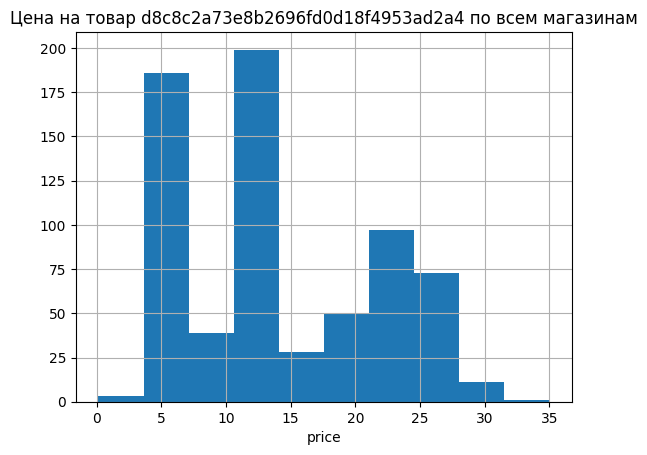

In [40]:
# Для примера распределение по цене для одного товара
df['sales_df_train'].loc[df['sales_df_train']['pr_sku_id'] == 'd8c8c2a73e8b2696fd0d18f4953ad2a4', 'price'].hist()
plt.title('Цена на товар d8c8c2a73e8b2696fd0d18f4953ad2a4 по всем магазинам')
plt.xlabel('price');

У 500 строк в датасете цена ниже 5 руб. Это актуально дл 48 товаров в 33 субкатегориях и 17 категориях.

Возможно, стоит попробовать сделать детекцию аномалий по цене.

In [41]:
# Оценим как много наблюдений в столбце pr_sales_in_units имеют значения более 2000
data.loc[data['total_sales_in_units']>2000]

st_id                         pr_sku_id  \
191927  fa7cdfad1a5aaf8370ebeda47a1ff1c3  9aa7008fa27151bf77be5f4c9d023d5f   

             date                        st_city_id  \
191927 2023-04-15  885fe656777008c335ac96072a45be15   

                        st_division_code  st_type_format_id  st_type_loc_id  \
191927  296bd0cc6e735f9d7488ebc8fbc19130                  1               1   

        st_type_size_id                       pr_group_id  \
191927               12  c74d97b01eae257e44aa9d5bade97baf   

                               pr_cat_id                      pr_subcat_id  \
191927  1bc0249a6412ef49b07fe6f62e6dc8de  60787c41b04097dfea76addfccd12243   

        pr_uom_id  total_sales_in_units  total_sales_in_rub  price_mean  \
191927         17                2362.0             62863.0       26.61   

        promo_share  
191927         0.99

Видно единичное значение (один магазин и один товар) продажи по промо 15 апреля 2023г. которого составили 2348 шт. Общая сумма продаж 62 429 руб., соответственно цена за товар - 26.6 руб. 16 апреля 2023г. была пасха, возможно это тематические товары, например, куличи.

In [42]:
# Посмотрим в какие даты продавался данный товар 
dates = df['sales_df_train'].loc[(df['sales_df_train']['pr_sku_id'] == '9aa7008fa27151bf77be5f4c9d023d5f'), 'date'].unique()
dates

array(['2023-04-15T00:00:00.000000000', '2023-04-04T00:00:00.000000000',
       '2023-04-08T00:00:00.000000000', '2023-04-06T00:00:00.000000000',
       '2023-04-24T00:00:00.000000000', '2023-04-07T00:00:00.000000000',
       '2023-04-14T00:00:00.000000000', '2023-04-13T00:00:00.000000000',
       '2023-04-05T00:00:00.000000000', '2023-04-22T00:00:00.000000000',
       '2023-04-10T00:00:00.000000000', '2023-04-16T00:00:00.000000000',
       '2023-04-11T00:00:00.000000000', '2023-04-02T00:00:00.000000000',
       '2023-04-19T00:00:00.000000000', '2023-04-17T00:00:00.000000000',
       '2023-04-01T00:00:00.000000000', '2023-04-09T00:00:00.000000000',
       '2023-03-31T00:00:00.000000000', '2023-04-03T00:00:00.000000000',
       '2023-04-23T00:00:00.000000000', '2023-04-20T00:00:00.000000000',
       '2023-04-12T00:00:00.000000000', '2023-04-18T00:00:00.000000000',
       '2023-04-21T00:00:00.000000000'], dtype='datetime64[ns]')

Видно, что это сезонный товар продавался в период с 31 марта по 24 преля.

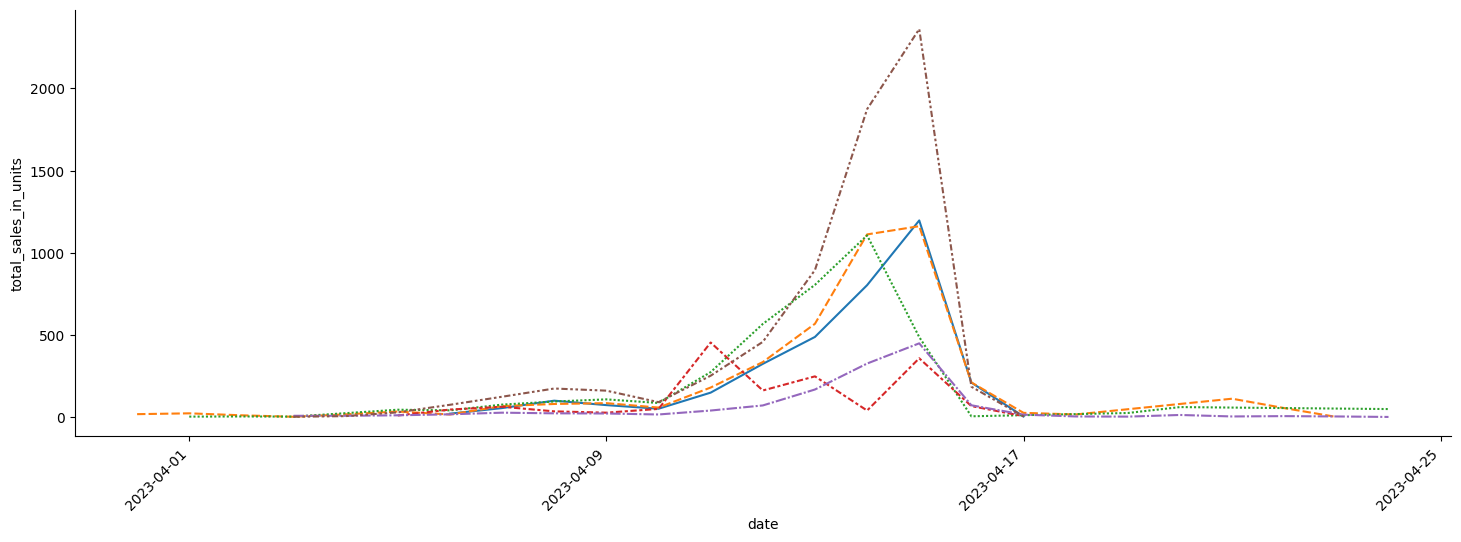

In [43]:
# Построим график продаж данного товара за указанные даты по всем магазинам
g = sns.relplot(
    data=data.loc[(data['pr_sku_id'] ==  '9aa7008fa27151bf77be5f4c9d023d5f')],
    
    x = 'date',
    y= 'total_sales_in_units',
    
    hue = 'st_id',
    style = "st_id",
    
    legend=False,
    kind="line",
    aspect=3,
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

Тут видно, что часть магазино имеет пик продаж в ту же дату, но у других магазинов размер пика и дата, на которую он приходится другие. Возможно, это зависит от размера магазина. Попробуем построить аналогичный график, но среди магазинов того же размера.

In [44]:
# Проверим как много магазинов такого же размера продавало этот же товар
data.loc[(data['pr_sku_id'] ==  '9aa7008fa27151bf77be5f4c9d023d5f')&(data['st_type_size_id'] ==  12), 'st_id'].unique()

array(['42a0e188f5033bc65bf8d78622277c4e',
       '6364d3f0f495b6ab9dcf8d3b5c6e0b01',
       'f7e6c85504ce6e82442c770f7c8606f0',
       'fa7cdfad1a5aaf8370ebeda47a1ff1c3'], dtype=object)

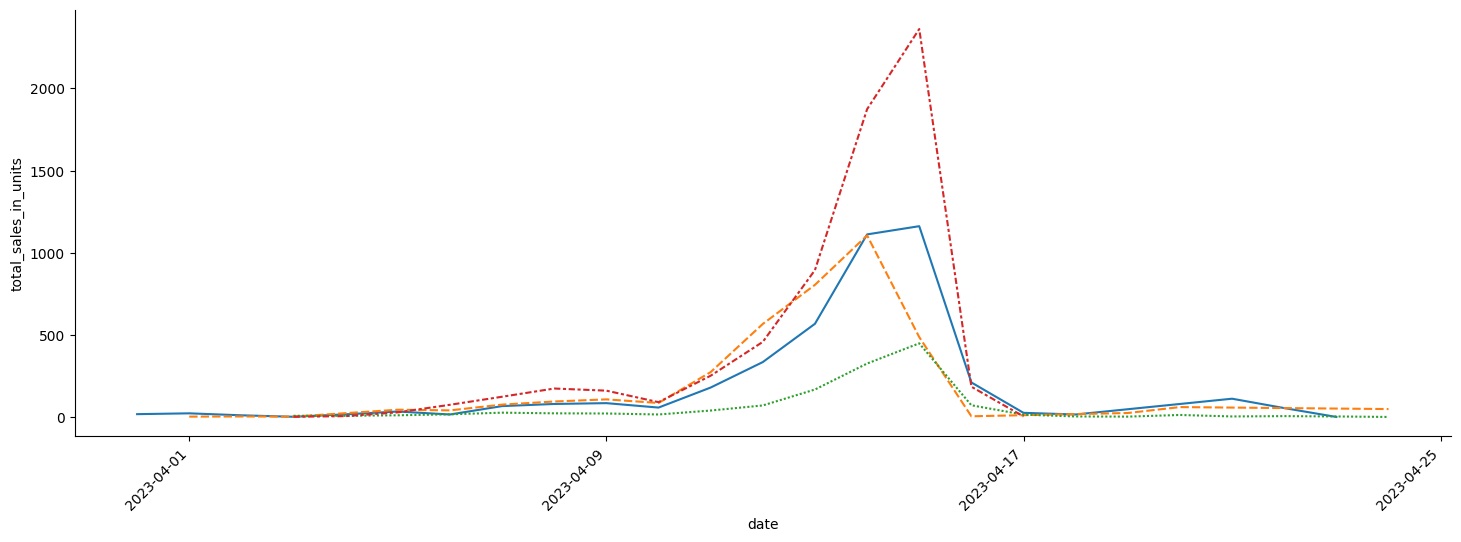

In [45]:
# Построим график продаж данного товара за указанные даты по магазинам такого же размера
g = sns.relplot(
    data = data.loc[(data['pr_sku_id'] ==  '9aa7008fa27151bf77be5f4c9d023d5f')&(data['st_type_size_id'] ==  12)],
    
    x = 'date',
    y= 'total_sales_in_units',
    
    hue = 'st_id',
    style = "st_id",
    
    legend=False,
    kind="line",
    aspect=3,
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

Видно, что пиковое значение в два раза превышает среднее значение для своей группы магазинов. 

По остальным магазинам так же видны всплески продаж этого товара в период за неделю до пасхи. Получается в данных есть товары, которые продаются постоянно (весь год) и сезонные.

In [46]:
# Оценим как много наблюдений в столбце pr_sales_in_rub имеют значения более 180 000
data.loc[data['total_sales_in_rub']>180000]

st_id                         pr_sku_id  \
17575  42a0e188f5033bc65bf8d78622277c4e  8cad09283d1d6c5fb08daec8a576a72d   

            date                        st_city_id  \
17575 2023-03-21  b8b4b727d6f5d1b61fff7be687f7970f   

                       st_division_code  st_type_format_id  st_type_loc_id  \
17575  da742b3cfca5388aaf9af28a726a3c30                  1               1   

       st_type_size_id                       pr_group_id  \
17575               12  c51ce410c124a10e0db5e4b97fc2af39   

                              pr_cat_id                      pr_subcat_id  \
17575  5caf41d62364d5b41a893adc1a9dd5d4  4e96157c3c8c24f4761a7bc4411a2504   

       pr_uom_id  total_sales_in_units  total_sales_in_rub  price_mean  \
17575          1                 440.0            183265.0      416.51   

       promo_share  
17575          1.0

In [47]:
# Посмотрим в какие даты продавался данный товар 
dates = data.loc[(data['pr_sku_id'] == '8cad09283d1d6c5fb08daec8a576a72d'), 'date'].unique()
len(dates)

259

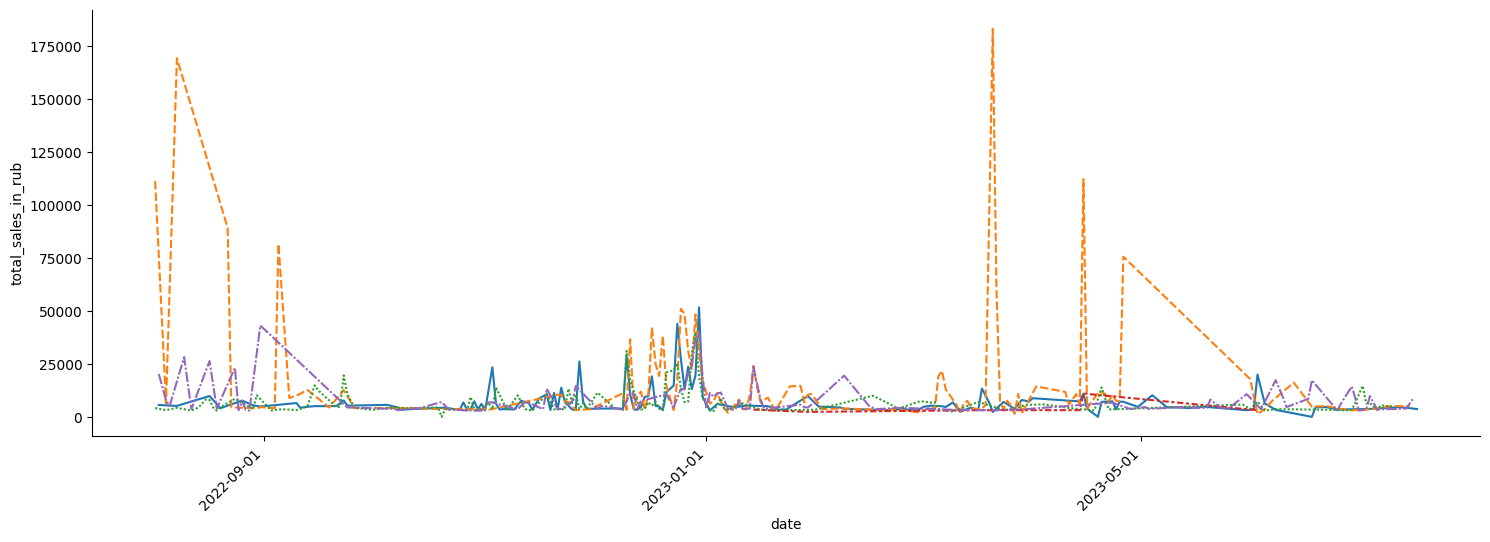

In [48]:
# Посмотрим на продажи этого товара в остальных магазинах
g = sns.relplot(
    data = data.loc[(data['pr_sku_id'] ==  '8cad09283d1d6c5fb08daec8a576a72d')],
    
    x = 'date',
    y= 'total_sales_in_rub',
    
    hue = 'st_id',
    style = "st_id",
    
    legend=False,
    kind="line",
    aspect=3,
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

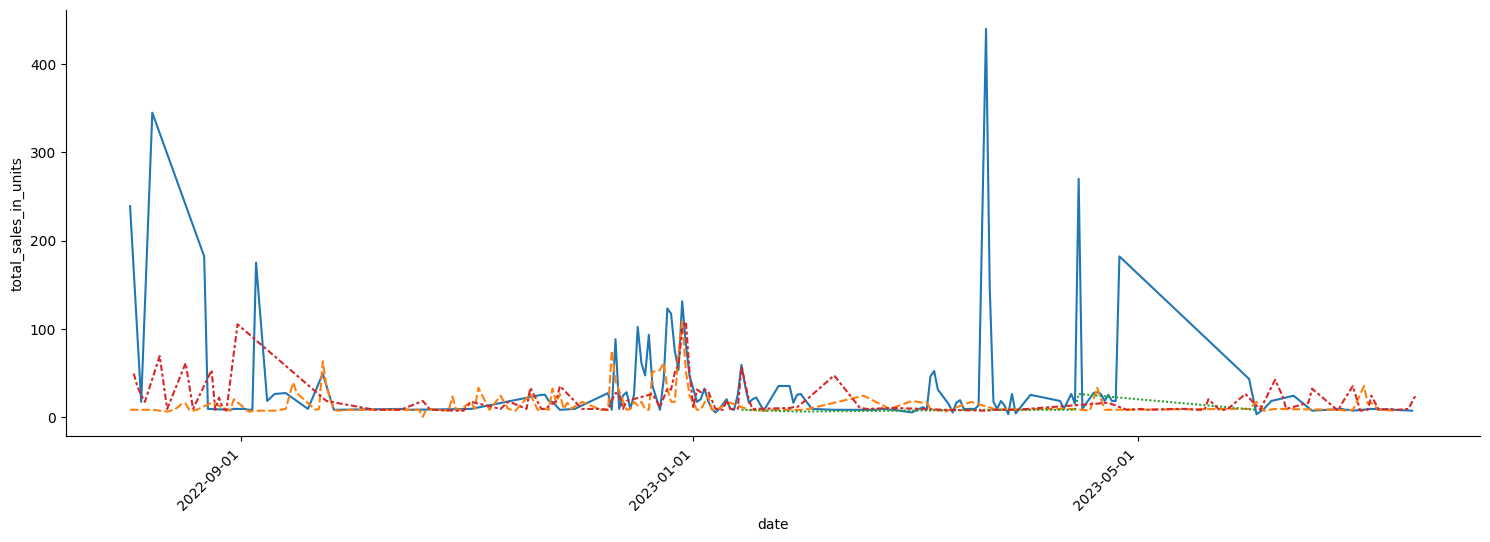

In [49]:
# Построим график продаж данного товара за указанные даты по магазинам такого же размера
g = sns.relplot(
    data = data.loc[(data['pr_sku_id'] ==  '8cad09283d1d6c5fb08daec8a576a72d')&(data['st_type_size_id'] ==  12)],
    
    x = 'date',
    y= 'total_sales_in_units',
    
    hue = 'st_id',
    style = "st_id",
    
    legend=False,
    kind="line",
    aspect=3,
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

Видно единичное значение (один магазин и один товар) продажи по промо 21 марта 2023г. которого составили 440 шт. Общая сумма продаж 183 265 руб., соответственно цена за товар - 416.5 руб. 

Этот товар, в отличие от предыдущего, продается круглогодично. Но всплески продаж видны только у одного магазина (синий график). 

Таким образом видно, что в данных имеются выбросы различной природы, которые следует исследовать и исключить для получения качественных прогнозов модели.

#### 2.1 Исследуем выбросы в данных при помощи библиотеки ETNA

In [50]:
# Исследуем пропуски по одному товару из одного магазина
temp = data.loc[(data['pr_sku_id'] ==  '00661699f543753ec7e911a64b9fd2f6')&(data['st_id'] ==  '16a5cdae362b8d27a1d8f8c7b78b4330')]
temp

st_id                         pr_sku_id  \
630524  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
622564  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
505974  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
251372  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
787201  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
...                                  ...                               ...   
19014   16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
704031  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
269104  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
243170  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
804773  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   

             date                        st_city_id  \
630524 2022-08-01  c1f75cc0f7fe269dd0fd9bd5e24f9586   
622564 2022-08-02  c1f75cc0f7fe269dd0fd9bd5e24f9586   
505974 2022-08-03  c1f75cc0f7fe269dd0fd9bd5e24f9586   
251372 2022-08-12  c1f75cc0f7fe269dd0fd9bd5e24f9586   
787201 2022-08-13  c1f75cc0f7fe269dd0fd9bd5e24f9586   
...           ...                               ...   
19014  2023-07-12  c1f75cc0f7fe269dd0fd9bd5e24f9586   
704031 2023-07-13  c1f75cc0f7fe269dd0fd9bd5e24f9586   
269104 2023-07-15  c1f75cc0f7fe269dd0fd9bd5e24f9586   
243170 2023-07-17  c1f75cc0f7fe269dd0fd9bd5e24f9586   
804773 2023-07-18  c1f75cc0f7fe269dd0fd9bd5e24f9586   

                        st_division_code  st_type_format_id  st_type_loc_id  \
630524  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
622564  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
505974  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
251372  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
787201  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
...                                  ...                ...             ...   
19014   296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
704031  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
269104  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
243170  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
804773  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   

        st_type_size_id                       pr_group_id  \
630524                8  aab3238922bcc25a6f606eb525ffdc56   
622564                8  aab3238922bcc25a6f606eb525ffdc56   
505974                8  aab3238922bcc25a6f606eb525ffdc56   
251372                8  aab3238922bcc25a6f606eb525ffdc56   
787201                8  aab3238922bcc25a6f606eb525ffdc56   
...                 ...                               ...   
19014                 8  aab3238922bcc25a6f606eb525ffdc56   
704031                8  aab3238922bcc25a6f606eb525ffdc56   
269104                8  aab3238922bcc25a6f606eb525ffdc56   
243170                8  aab3238922bcc25a6f606eb525ffdc56   
804773                8  aab3238922bcc25a6f606eb525ffdc56   

                               pr_cat_id                      pr_subcat_id  \
630524  9701a1c165dd9420816bfec5edd6c2b1  8afe22eeb3f3f68de994a3c60388858c   
622564  9701a1c165dd9420816bfec5edd6c2b1  8afe22eeb3f3f68de994a3c60388858c   
505974  9701a1c165dd9420816bfec5edd6c2b1  8afe22eeb3f3f68de994a3c60388858c   
251372  9701a1c165dd9420816bfec5edd6c2b1  8afe22eeb3f3f68de994a3c60388858c   
787201  9701a1c165dd9420816bfec5edd6c2b1  8afe22eeb3f3f68de994a3c60388858c   
...                                  ...                               ...   
19014   9701a1c165dd9420816bfec5edd6c2b1  8afe22eeb3f3f68de994a3c60388858c   
704031  9701a1c165dd9420816bfec5edd6c2b1  8afe22eeb3f3f68de994a3c60388858c   
269104  9701a1c165dd9420816bfec5edd6c2b1  8afe22eeb3f

In [51]:
# Выделяем нужные столбцы
temp = temp[['date', 'total_sales_in_units', 'pr_sku_id']]
temp.columns = ['timestamp', 'target', 'segment']

# приводим данные к ETNA-формату
df = TSDataset.to_dataset(temp)
ts = TSDataset(df, freq="1D")

In [52]:
# Проверяем что получилось
ts

segment    00661699f543753ec7e911a64b9fd2f6
feature                              target
timestamp                                  
2022-08-01                              1.0
2022-08-02                              1.0
2022-08-03                              1.0
2022-08-04                              NaN
2022-08-05                              NaN
...                                     ...
2023-07-14                              NaN
2023-07-15                              4.0
2023-07-16                              NaN
2023-07-17                              2.0
2023-07-18                              1.0

[352 rows x 1 columns]

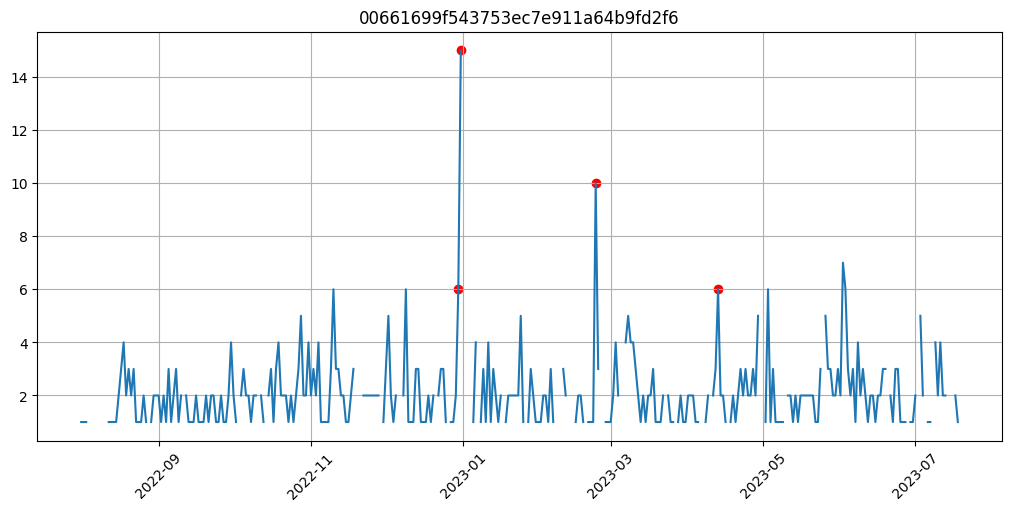

In [53]:
# Посмотрим, какие данные будут отмечены как выбросы
anomaly_dict = get_anomalies_density(ts, window_size=14, distance_coef=1, n_neighbors=1)
plot_anomalies(ts, anomaly_dict)

Работа с выбросами в enta происходит в два этапа:
- выбросы заменяются на nan
- пропуски в данных замещаются при помощи TimeSeriesImputerTransform

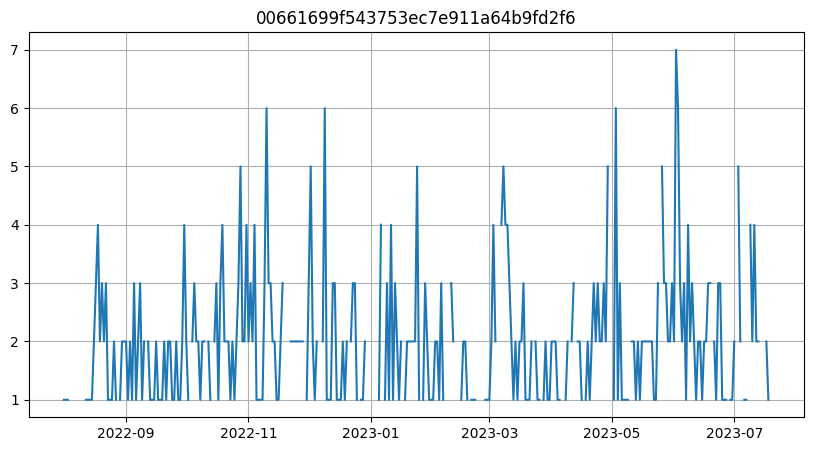

In [54]:
# Удалим выбросы и посмотрим как изменился график временного ряда
outliers_remover = DensityOutliersTransform(in_column="target", window_size=14, distance_coef=1, n_neighbors=1)

ts.fit_transform([outliers_remover])
ts.plot()

Для детекции выбросов в бибилиотеке существут несколько методов, было бы хорошо протестировать их все при обучении моделей, чтобы понять какой подходит лучше.

#### 2.2 Заполнение пропусков в данных

In [55]:
# Исследуем пропуски по одному товару из одного магазина
res = data.loc[(data['pr_sku_id'] ==  '8cad09283d1d6c5fb08daec8a576a72d')&(data['st_id'] ==  '42a0e188f5033bc65bf8d78622277c4e')]
print(f" Минимальная дата {res['date'].min()}")
print(f" Максимальная дата {res['date'].max()}")
print(f" Количество дней между датами {(res['date'].max()-res['date'].min()).days}")
print(f" Количество дней по которым есть продажи в данных {res['date'].count()}")

 Минимальная дата 2022-08-02 00:00:00
 Максимальная дата 2023-07-14 00:00:00
 Количество дней между датами 346
 Количество дней по которым есть продажи в данных 132


Мы знаем, что в данных есть пропуски после удаления выбросов. Но так же видно, что за некоторые дни даных по продажам нет. У нас нет информации почему данные отсутствуют - проблемы с выгрузкой данных из базы или в эти дни не завезли соответствующие товары. Нельзя однозначно сказать, что в эти дни спроса не было, поэтому попробуем заполнить пропуски на основании тех данных, которые у нас есть. 

Можно так же посчитать для каждого временного ряда сколько наблюдений присутствует в исторических данных и выделить это в отдельный признак.

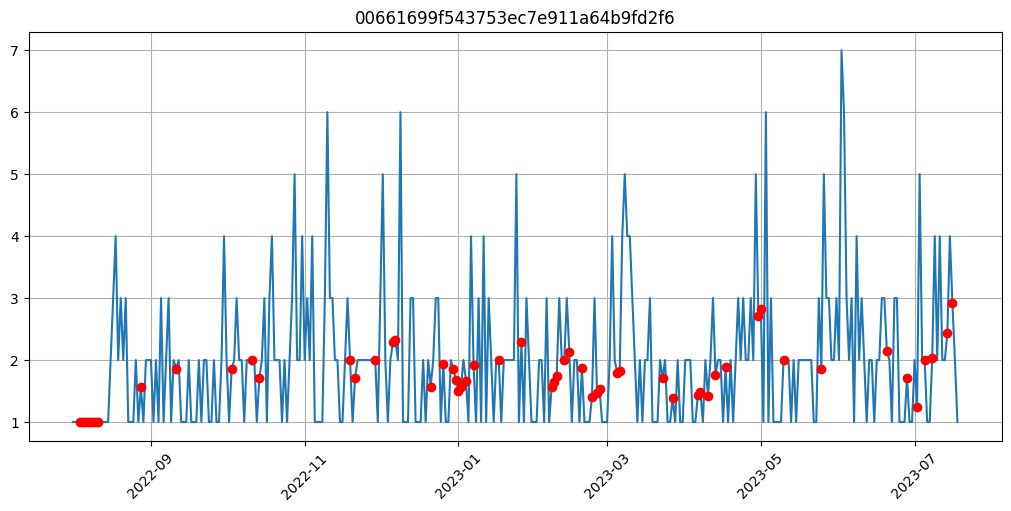

In [56]:
# Посмотрим как будет выглядеть заполнение пропусков графически в предыдушем образце (там где удаляли выбросы)
outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=7)
plot_imputation(imputer=outliers_imputer, ts=ts)

In [57]:
# Заполняем пропуски в данных
ts = outliers_imputer.fit_transform(ts)

In [58]:
# Переводим данные в формате etna в формат pandas dataframe
ts = ts.to_pandas(flatten = True)
ts.head()

timestamp                           segment  target
0 2022-08-01  00661699f543753ec7e911a64b9fd2f6     1.0
1 2022-08-02  00661699f543753ec7e911a64b9fd2f6     1.0
2 2022-08-03  00661699f543753ec7e911a64b9fd2f6     1.0
3 2022-08-04  00661699f543753ec7e911a64b9fd2f6     1.0
4 2022-08-05  00661699f543753ec7e911a64b9fd2f6     1.0

In [59]:
# Если в данных остались пропуски - их заполним нулями.
ts = ts.fillna(0)
ts.isna().sum()

timestamp    0
segment      0
target       0
dtype: int64

#### 2.3 Анализ временных рядов

In [67]:
# Сгруппируем данные для построения графиков тренда и сезонности
temp = data[['date', 'total_sales_in_units']].groupby('date')['total_sales_in_units'].agg('sum')
temp.head()

date
2022-08-01     9586.0
2022-08-02    10786.0
2022-08-03    10597.0
2022-08-04    12970.0
2022-08-05    18197.0
Name: total_sales_in_units, dtype: float64

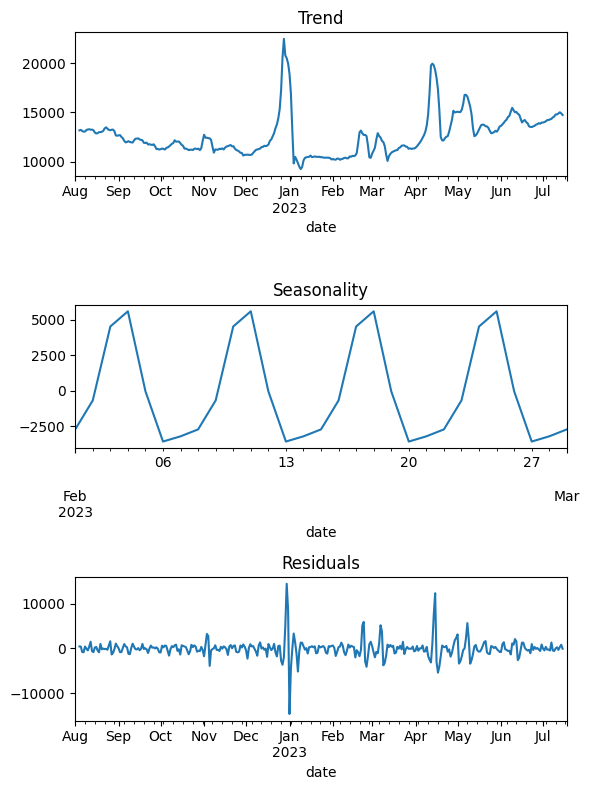

In [70]:
#Построим графики тренда,сезонности и остатков
decomposed = seasonal_decompose(temp)

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend') 

plt.subplot(312)
decomposed.seasonal['2023-02-01':'2023-03-01'].plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

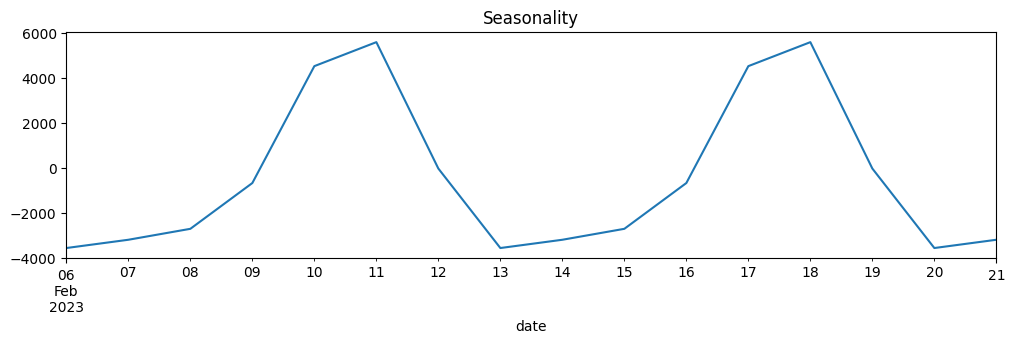

In [71]:
#Увеличим масштаб для изучения сезонности
plt.figure(figsize=(12, 10))

plt.subplot(312)
decomposed.seasonal['2023-02-06':'2023-02-21'].plot(ax=plt.gca()) 
plt.title('Seasonality');

Видна сезонность равная одной неделе. Эту информацию можно использовать при построении дополнительных признаков для модели.

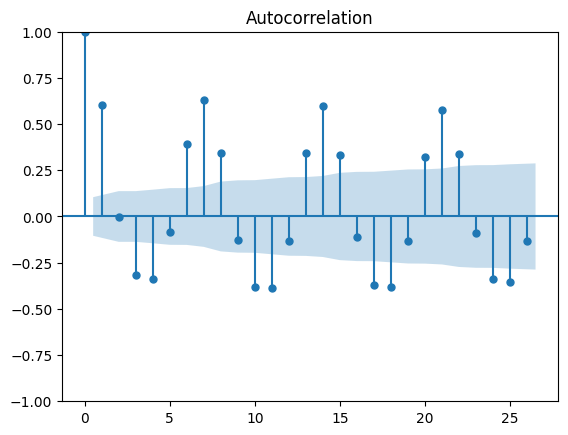

In [72]:
# Построим график автокорреляции
plot_acf(temp)
plt.show()

На графике автокорреляции видна связь корреляционных коэффициентов, которая помогает оценить значимые лаги. В целом график повторяет выводы по графику сезонности. 

#### Оценим стационарность временного ряда

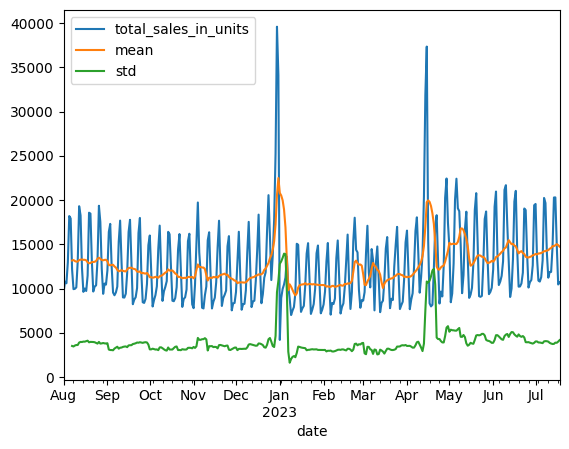

In [73]:
# Построим график скользящего среднего и стандартного отклонения
temp = pd.DataFrame(temp)
temp['mean'] = temp['total_sales_in_units'].rolling(7).mean() 
temp['std'] = temp['total_sales_in_units'].rolling(7).std()

temp.plot();

Попробуем оценить стационарность ряда при помощи критерия Дики-Фуллера:
    
    H0: Временной ряд является нестационарным,  
    H1: Временной ряд является стационарным. 
    Уровень значимости α = 0,05

In [ ]:
#Рассчет критерия Дики-Фуллера
print(f"p_value = {round(adfuller(temp['total_sales_in_units'])[1], 2)}")

При оценке стационарности временного ряда при помощи критерия Дики-Фуллера получено значение p_value = 0.01, получается мы можем отвергнуть нулевую гипотезу и сделать вывод, что временной ряд является стационарным.

Можно отметить тренд уменьшающийся незначительно к новому году с пиком на новый год, и растущий тренд к лету. Сезонность - 1 неделя, растет к пятнице с пиком в субботу и падением к понедельнику.

Логично попробовать создать дополнительные признаки - делаем признак день недели с тригонометрическим преобразованием
гиперпараметры max_lag, rolling_mean_size равными 7 (неделя).

#### Временные ряды магазинов

In [74]:
# Подготовим данные для построения графиков временных рядов для каждого магазина
temp = data.set_index('date').copy()
temp.sort_index()

st_id  \
date                                           
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  6364d3f0f495b6ab9dcf8d3b5c6e0b01   
2022-08-01  fa7cdfad1a5aaf8370ebeda47a1ff1c3   
...                                      ...   
2023-07-18  6364d3f0f495b6ab9dcf8d3b5c6e0b01   
2023-07-18  f7e6c85504ce6e82442c770f7c8606f0   
2023-07-18  16a5cdae362b8d27a1d8f8c7b78b4330   
2023-07-18  c81e728d9d4c2f636f067f89cc14862c   
2023-07-18  6364d3f0f495b6ab9dcf8d3b5c6e0b01   

                                   pr_sku_id  \
date                                           
2022-08-01  543f17ebd9d464531d61fcdeaa36678f   
2022-08-01  d22bb534b7964c0cafab6aab1995f000   
2022-08-01  6e822618c30449cfabec9b22a7de1425   
2022-08-01  25297b758a38dfb3475046e5dc01291a   
2022-08-01  4b083e10f6cd2f4360c5425d05be6386   
...                                      ...   
2023-07-18  47decbcad0a55e98086b30803ef9ca6d   
2023-07-18  b8ef962dc97739cb4763dfe675a82305   
2023-07-18  8ba3350be2f4761427a827fdc09cb86e   
2023-07-18  862a0f53be5bc70d8ae3e493c19d47ec   
2023-07-18  dc57ae67a89ed3b85f394f5ca5b9ba1d   

                                  st_city_id  \
date                                           
2022-08-01  c1f75cc0f7fe269dd0fd9bd5e24f9586   
2022-08-01  c1f75cc0f7fe269dd0fd9bd5e24f9586   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f   
2022-08-01  885fe656777008c335ac96072a45be15   
...                                      ...   
2023-07-18  b8b4b727d6f5d1b61fff7be687f7970f   
2023-07-18  3202111cf90e7c816a472aaceb72b0df   
2023-07-18  c1f75cc0f7fe269dd0fd9bd5e24f9586   
2023-07-18  908c9a564a86426585b29f5335b619bc   
2023-07-18  b8b4b727d6f5d1b61fff7be687f7970f   

                            st_division_code  st_type_format_id  \
date                                                              
2022-08-01  296bd0cc6e735f9d7488ebc8fbc19130                  1   
2022-08-01  296bd0cc6e735f9d7488ebc8fbc19130                  1   
2022-08-01  da742b3cfca5388aaf9af28a726a3c30                  1   
2022-08-01  da742b3cfca5388aaf9af28a726a3c30                  1   
2022-08-01  296bd0cc6e735f9d7488ebc8fbc19130                  1   
...                                      ...                ...   
2023-07-18  da742b3cfca5388aaf9af28a726a3c30                  1   
2023-07-18  32586311f16876abf92901085bd87b99                  1   
2023-07-18  296bd0cc6e735f9d7488ebc8fbc19130                  1   
2023-07-18  429a86ff6336c144ddaf6144f52ab52c                  1   
2023-07-18  da742b3cfca5388aaf9af28a726a3c30                  1   

            st_type_loc_id  st_type_size_id                       pr_group_id  \
date                                                                            
2022-08-01               2                8  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01               2                8  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01               1               12  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01               1               12  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01               1               12  6512bd43d9caa6e02c990b0a82652dca   
...                    ...              ...                               ...   
2023-07-18               1               12  aab3238922bcc25a6f606eb525ffdc56   
2023-07-18               1               12  1ff1de774005f8da13f42943881c655f   
2023-07-18               2                8  aab3238922bcc25a6f606eb525ffdc56   
2023-07-18               1                8  c74d97b01eae257e44aa9d5bade97baf   
2023-07-18               1               12  aab3238922bcc25a6f606eb525ffdc56   

                                   pr_cat_id  \
date                                           
2022-08-01  1bc0249a6412ef49b07fe6f62e6dc8de   
2022-08-01  faafda66202d234463057972460c04f5   
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1  

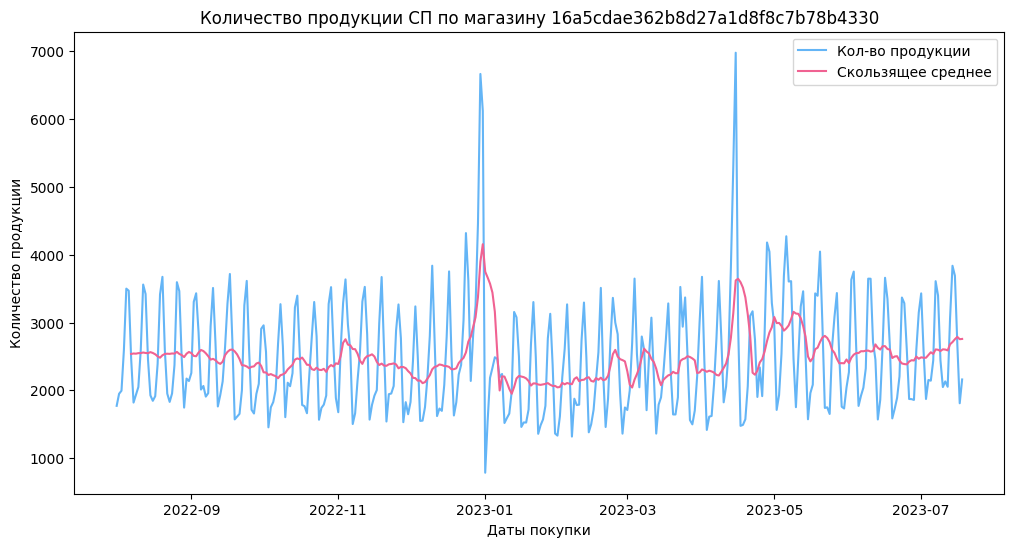

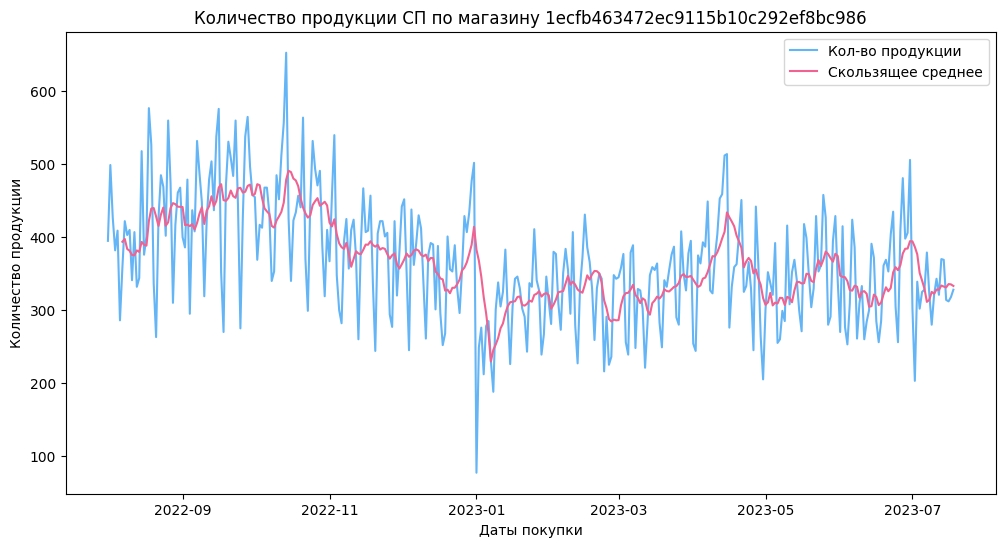

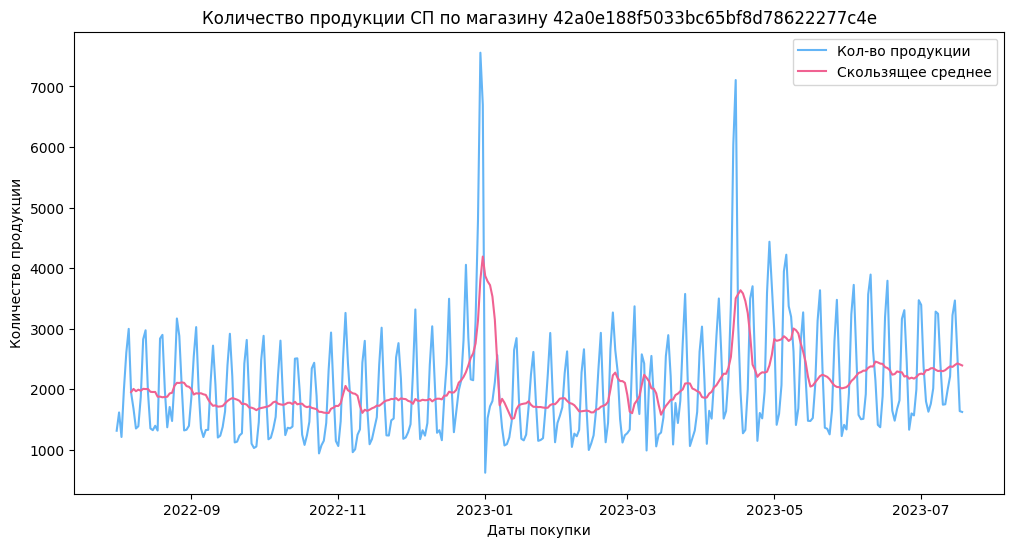

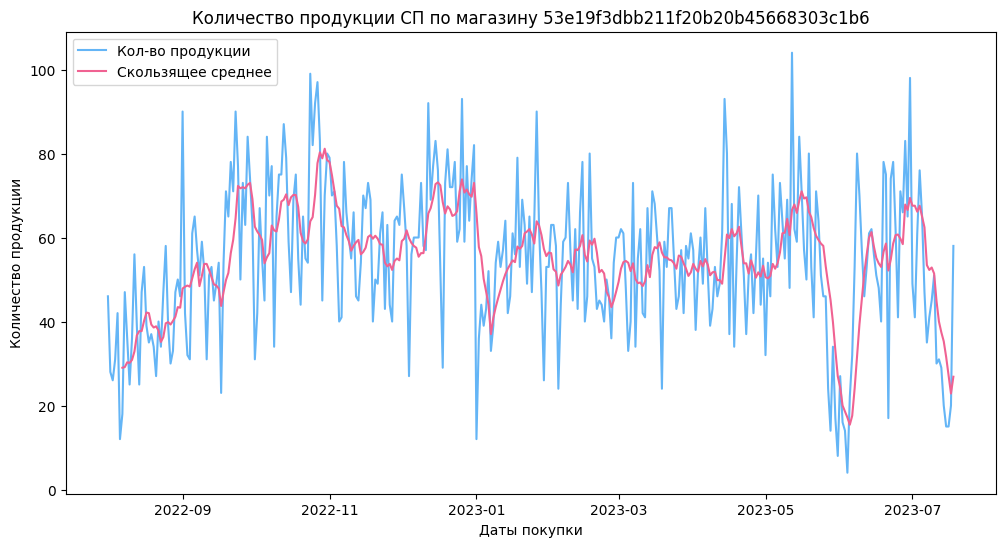

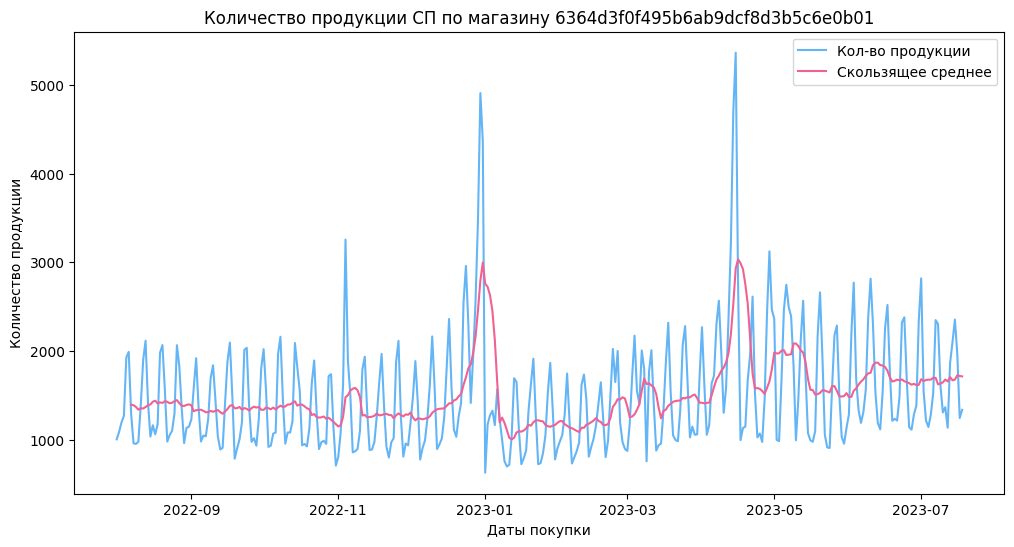

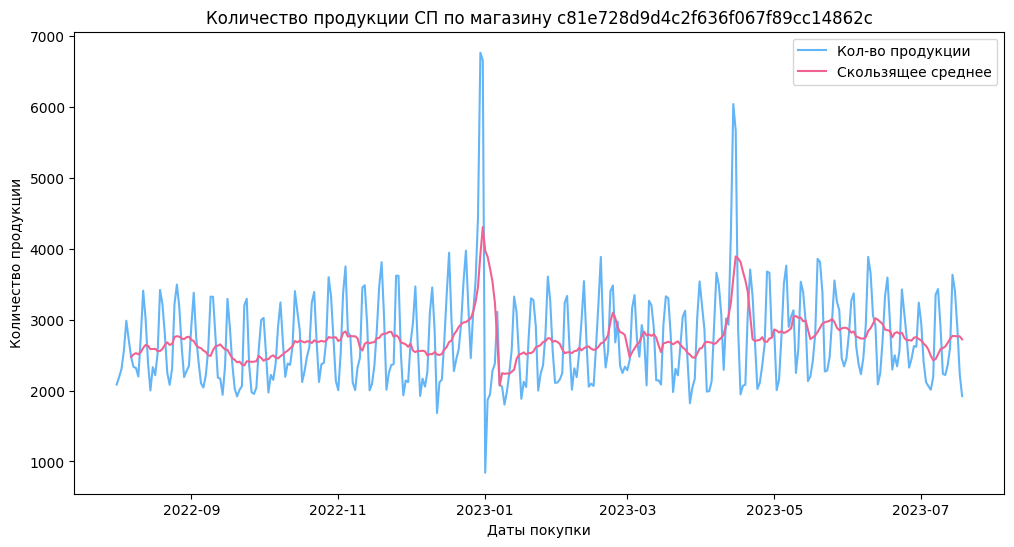

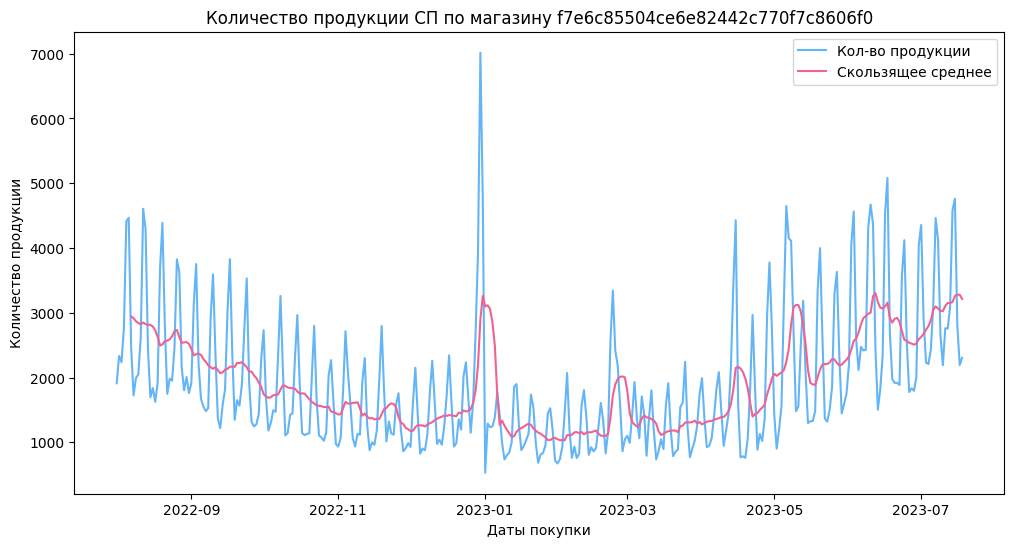

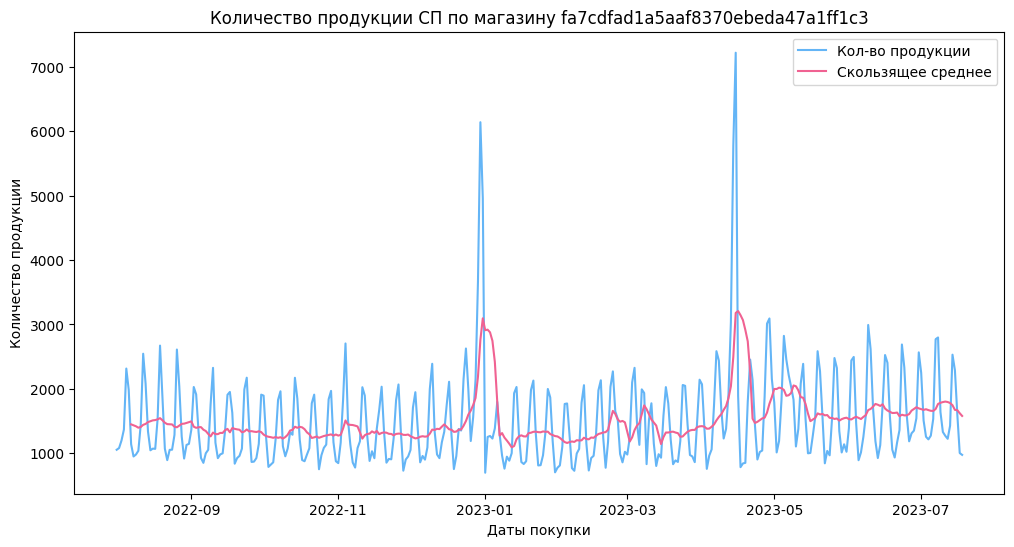

In [75]:
# Сравним есть ли разница у временных рядов для каждого магазина

for shop_id in temp['st_id'].unique():
    shop_data = temp[temp['st_id'] == shop_id].resample('1D').sum()
    
    # строим графики
    plt.figure(figsize=(12, 6))
    plt.plot(shop_data.index, shop_data['total_sales_in_units'], color='#64B5F6', label='Кол-во продукции')
    plt.plot(shop_data.index, shop_data['total_sales_in_units'].rolling(7).mean(), color='#F06292', label='Скользящее среднее')
    
    plt.xlabel('Даты покупки')
    plt.ylabel('Количество продукции')
    plt.title(f'Количество продукции СП по магазину {shop_id}')
    plt.legend()
    plt.show()

6 магазинов имеют схожие графики временных рядов - равномерные продажи весь год с пиками на новый год и пасху. 
 (16a5cdae362b8d27a1d8f8c7b78b4330, c81e728d9d4c2f636f067f89cc14862c, 42a0e188f5033bc65bf8d78622277c4e, 6364d3f0f495b6ab9dcf8d3b5c6e0b01, fa7cdfad1a5aaf8370ebeda47a1ff1c3).
 
2 магазина (1ecfb463472ec9115b10c292ef8bc986, 53e19f3dbb211f20b20b45668303c1b6) отличаются от остальных.

Возможно у этих магазинов данных про продажам товаром представлено мало. Нужно попробовать провести анализ суммарных продаж по магазинам. 

#### 2.4 Сравнение суммарных продаж по магазинам и анализ продаваемости товаров

In [76]:
temp = data.groupby(['st_id'], as_index = False).agg(
                        store_sales = ('total_sales_in_rub', 'sum'))

print(f"Суммарные продажи {temp['store_sales'].sum()} руб.")
temp['sum_%'] = temp['store_sales'] / temp['store_sales'].sum()
temp.sort_values('store_sales', ascending = False)

Суммарные продажи 521316639.0 руб.


st_id  store_sales     sum_%
5  c81e728d9d4c2f636f067f89cc14862c  109297905.0  0.209657
0  16a5cdae362b8d27a1d8f8c7b78b4330  107522873.0  0.206253
2  42a0e188f5033bc65bf8d78622277c4e   90303524.0  0.173222
6  f7e6c85504ce6e82442c770f7c8606f0   75519609.0  0.144863
4  6364d3f0f495b6ab9dcf8d3b5c6e0b01   65062234.0  0.124804
7  fa7cdfad1a5aaf8370ebeda47a1ff1c3   64281036.0  0.123305
1  1ecfb463472ec9115b10c292ef8bc986    8256799.0  0.015838
3  53e19f3dbb211f20b20b45668303c1b6    1072659.0  0.002058

Для анализа продаваемости будем использовать оригинальные данные, в которых не удалялись выбросы и не заполнялись пропущенные значения.

In [77]:
# Сделаем группировку по сумме продаж по месяцам и годам
temp = data.copy()
temp['month_year'] = temp['date'].apply(lambda x: x.strftime("%Y-%m"))
temp = temp.groupby('month_year')['total_sales_in_rub'].agg('sum')
temp = temp.reset_index()
temp.head()

month_year  total_sales_in_rub
0    2022-08          45359571.0
1    2022-09          40786814.0
2    2022-10          40322750.0
3    2022-11          39618139.0
4    2022-12          58939700.0

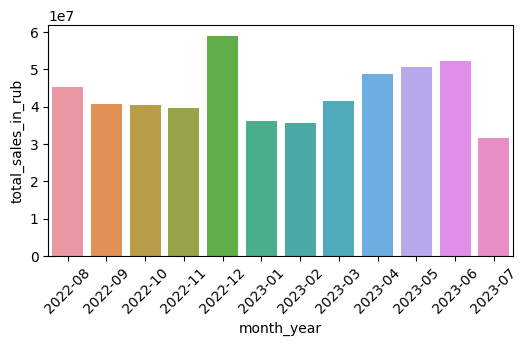

In [78]:
# Продажи по месяцам
figure, ax = plt.subplots()
figure.set_size_inches(6, 3)

sns.barplot(x = 'month_year', y = 'total_sales_in_rub', data = temp)
ax.tick_params(axis='x', labelrotation=45);

Ожидаемо максимальные продажи наблюдаются в декабре.Данные за июль 2023 не полные, поэтому видна сильная разница с июнем. Так как видны колебания продаж по месяцам - стоит добавить в данные признак соответствующий месяцу.

In [79]:
# Сгруппируем данные по группам товаром и оценим продажи
temp = data.groupby(['pr_group_id'], as_index = False).agg(
                        cat_count = ('pr_cat_id', 'nunique'),
                        subcat_count = ('pr_subcat_id', 'nunique'),
                        sku_count = ('pr_sku_id', 'nunique'), 
                        total_sales = ('total_sales_in_rub', 'sum'))
display(temp.sort_values('total_sales', ascending = False))

print(f"Суммарная выручка составляет {temp['total_sales'].sum()} руб.")

pr_group_id  cat_count  subcat_count  sku_count  \
5  aab3238922bcc25a6f606eb525ffdc56          9            44        695   
3  6512bd43d9caa6e02c990b0a82652dca          6            14        199   
8  c74d97b01eae257e44aa9d5bade97baf         10            54        740   
7  c51ce410c124a10e0db5e4b97fc2af39          9            30        180   
6  c20ad4d76fe97759aa27a0c99bff6710          2             9         72   
1  32bb90e8976aab5298d5da10fe66f21d          3             5         27   
0  1ff1de774005f8da13f42943881c655f          1             6         35   
4  98f13708210194c475687be6106a3b84          2             2          4   
2  3c59dc048e8850243be8079a5c74d079          1             1          1   

   total_sales  
5  160589981.0  
3  131600301.0  
8   98510610.0  
7   74037732.0  
6   41134610.0  
1   12834193.0  
0    2539564.0  
4      67987.0  
2       1661.0

Суммарная выручка составляет 521316639.0 руб.


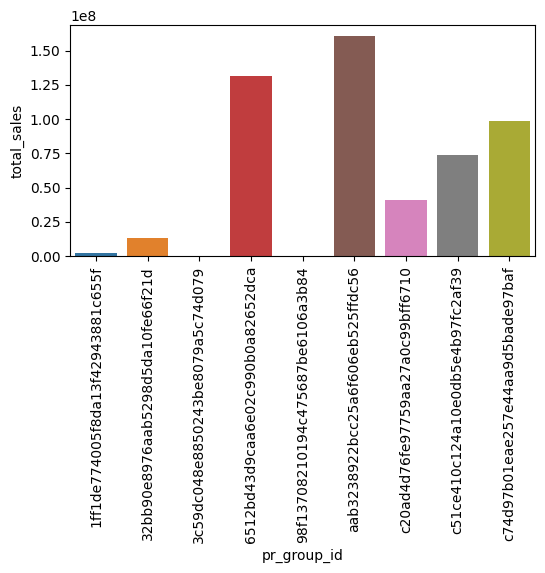

In [80]:
# Продажи по группам
figure, ax = plt.subplots()
figure.set_size_inches(6, 3)

sns.barplot(x = 'pr_group_id', y = 'total_sales', data = temp)
ax.tick_params(axis='x', labelrotation=90);

Видно, что самая продаваемая группа товаров - aab3238922bcc25a6f606eb525ffdc56 включает в себя 9 категорий и 44 подкатегории, а также 695 товаров. Это самое большое количество товаров из остальных групп, поэтому логично, что данная группа продается лучше остальных. Продажи около 160 млн. руб.

Вторая по продаваемости группа - 6512bd43d9caa6e02c990b0a82652dca отстает по выручке от первой на 18% но при этом в ней в три раза меньше товаров. Продажи 130 млн. руб.

Так же видны группы товаров в которые входит 1-4 товара, по ним продажи совсем небольшие - 1661 руб. и 67 987 руб. соответственно.

Корректное предсказание первых двух групп товаров дает нам 56% от общих продаж, первых трех групп - 75%, четырех - 89%, пяти - 97%

In [81]:
# Выделим топ-5 групп по продажам
top_groups = temp.sort_values('total_sales', ascending = False)['pr_group_id'].head()
top_groups

5    aab3238922bcc25a6f606eb525ffdc56
3    6512bd43d9caa6e02c990b0a82652dca
8    c74d97b01eae257e44aa9d5bade97baf
7    c51ce410c124a10e0db5e4b97fc2af39
6    c20ad4d76fe97759aa27a0c99bff6710
Name: pr_group_id, dtype: object

In [82]:
def add_features(data, feature):
    """Функция для создания дополнительных признаков для анализа:
    rank - нумерует категории внутри группы
    total_sales - сумма продаж по группе
    count_cat - общее количество категорий в группе
    sum_% - % продаж категории в группе
    cumsum_% - % коммулятивная сумма продаж по категориям
    cumulative_diff - % коммулятивная разница в приросте суммы продаж
    Возвращает датасет с новыми признаками.
    """
    data['rank'] = data.groupby('pr_group_id').cumcount() + 1
    for group in top_groups:
        sum_group = data.loc[data['pr_group_id'] == group, 'total_sales'].sum()
        data.loc[data['pr_group_id'] == group, 'count_cat'] = len(data.loc[data['pr_group_id'] == group, feature].unique())
        data.loc[data['pr_group_id'] == group, 'sum_%'] = data.loc[data['pr_group_id'] == group, 'total_sales'] / sum_group
        data.loc[data['pr_group_id'] == group, 'cumsum_%'] = data.loc[data['pr_group_id'] == group, 'sum_%'].cumsum()
        data.loc[data['pr_group_id'] == group, 'cumulative_diff'] = data.loc[data['pr_group_id'] == group, 'cumsum_%'].diff()
    return data

In [83]:
# Сгруппируем продажи по группе и категории
print(f" Количество уникальных категорий {data['pr_cat_id'].nunique()}")

temp = data.loc[data['pr_group_id'].isin(top_groups)]
temp = temp.groupby(['pr_group_id', 'pr_cat_id'], as_index = False).agg(
                        total_sales = ('total_sales_in_rub', 'sum')
                        )
# Отсортируем продажи внутри каждой группы по убыванию
temp = temp.sort_values(['pr_group_id', 'total_sales'], ascending = False)

# Добавим признаки для анализа - % продаж для каждой категории и разность в % между продажами
temp = add_features(temp, 'pr_cat_id')

# Выведем только те группы и категоии на которые приходятся основные продажи    
temp = temp.loc[(temp['cumulative_diff'] > 0.02)|(temp['cumulative_diff'].isna())]
print(f" Количество самых прибыльных категорий {len(temp['pr_cat_id'].unique())}")
temp

 Количество уникальных категорий 43
 Количество самых прибыльных категорий 20


pr_group_id                         pr_cat_id  \
32  c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   
26  c74d97b01eae257e44aa9d5bade97baf  1bc0249a6412ef49b07fe6f62e6dc8de   
34  c74d97b01eae257e44aa9d5bade97baf  f3173935ed8ac4bf073c1bcd63171f8a   
31  c74d97b01eae257e44aa9d5bade97baf  a368b0de8b91cfb3f91892fbf1ebd4b2   
35  c74d97b01eae257e44aa9d5bade97baf  faafda66202d234463057972460c04f5   
33  c74d97b01eae257e44aa9d5bade97baf  f18a6d1cde4b205199de8729a6637b42   
19  c51ce410c124a10e0db5e4b97fc2af39  5caf41d62364d5b41a893adc1a9dd5d4   
17  c51ce410c124a10e0db5e4b97fc2af39  2df45244f09369e16ea3f9117ca45157   
25  c51ce410c124a10e0db5e4b97fc2af39  fd5c905bcd8c3348ad1b35d7231ee2b1   
18  c51ce410c124a10e0db5e4b97fc2af39  535ab76633d94208236a2e829ea6d888   
16  c20ad4d76fe97759aa27a0c99bff6710  fb2fcd534b0ff3bbed73cc51df620323   
7   aab3238922bcc25a6f606eb525ffdc56  28fc2782ea7ef51c1104ccf7b9bea13d   
13  aab3238922bcc25a6f606eb525ffdc56  9701a1c165dd9420816bfec5edd6c2b1   
6   aab3238922bcc25a6f606eb525ffdc56  186a157b2992e7daed3677ce8e9fe40f   
8   aab3238922bcc25a6f606eb525ffdc56  3de2334a314a7a72721f1f74a6cb4cee   
11  aab3238922bcc25a6f606eb525ffdc56  6d9c547cf146054a5a720606a7694467   
9   aab3238922bcc25a6f606eb525ffdc56  46771d1f432b42343f56f791422a4991   
5   6512bd43d9caa6e02c990b0a82652dca  e58cc5ca94270acaceed13bc82dfedf7   
4   6512bd43d9caa6e02c990b0a82652dca  c9f95a0a5af052bffce5c89917335f67   
2   6512bd43d9caa6e02c990b0a82652dca  b59c67bf196a4758191e42f76670ceba   

    total_sales  rank  count_cat     sum_%  cumsum_%  cumulative_diff  
32   46762982.0     1       10.0  0.474700  0.474700              NaN  
26   20238828.0     2       10.0  0.205448  0.680148         0.205448  
34   19422182.0     3       10.0  0.197158  0.877306         0.197158  
31    5508460.0     4       10.0  0.055917  0.933224         0.055917  
35    2970284.0     5       10.0  0.030152  0.963376         0.030152  
33    2005710.0     6       10.0  0.020360  0.983736         0.020360  
19   43632526.0     1        9.0  0.589328  0.589328              NaN  
17   16106693.0     2        9.0  0.217547  0.806875         0.217547  
25    7088399.0     3        9.0  0.095740  0.902616         0.095740  
18    6638357.0     4        9.0  0.089662  0.992277         0.089662  
16   41131915.0     1        2.0  0.999934  0.999934              NaN  
7    71255292.0     1        9.0  0.443709  0.443709              NaN  
13   39418248.0     2        9.0  0.245459  0.689168         0.245459  
6    25987226.0     3        9.0  0.161823  0.850992         0.161823  
8    13206489.0     4        9.0  0.082237  0.933229         0.082237  
11    5063654.0     5        9.0  0.031532  0.964761         0.031532  
9     3840447.0     6        9.0  0.023915  0.988675         0.023915  
5    74998869.0     1        6.0  0.569899  0.569899              NaN  
4    35079616.0     2        6.0  0.266562  0.836461         0.266562  
2    17434951.0     3        6.0  0.132484  0.968945         0.132484

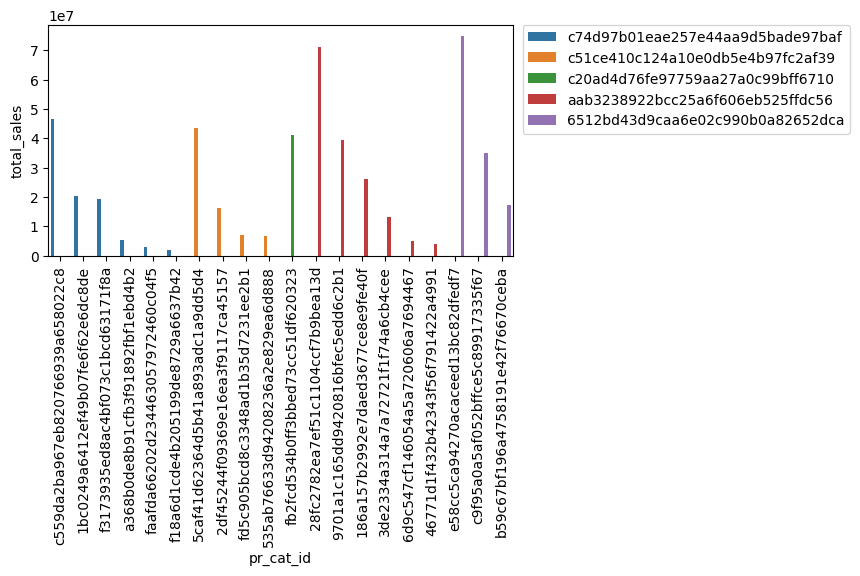

In [84]:
# Продажи по категориям
figure, ax = plt.subplots()
figure.set_size_inches(6, 3)

sns.barplot(x = 'pr_cat_id', y = 'total_sales', data = temp, hue = 'pr_group_id')
ax.tick_params(axis='x', labelrotation=90)
plt.legend(bbox_to_anchor=( 1.02 , 1 ), loc='upper left', borderaxespad= 0 );

Внутри групп мы имеем 43 уникальные категории. Анализ продаж по категориям показывает, что для каждой группы основную долю продаж приносит только несколько категорий.

Например, в первой по продажам группе 10 категорий, из них первые пять обеспечивают 96% продаж. Для второй группы из 9 категорий первые 4 категории дают 99% продаж. 

In [85]:
# Выделим основные продаваемые категории по каждой группе
top_cats = temp['pr_cat_id'].unique()

cat_group_dict = {}
for group in top_groups:
    cats = temp.loc[temp['pr_group_id'] == group, 'pr_cat_id']
    cat_group_dict[group] = cats.to_list()

In [86]:
# Сгруппируем продажи по группе и категории и субкатегории
print(f" Количество уникальных субкатегорий {data['pr_subcat_id'].nunique()}")

temp = data.loc[(data['pr_group_id'].isin(top_groups))&(data['pr_cat_id'].isin(top_cats))]
temp = temp.groupby(['pr_group_id', 'pr_cat_id', 'pr_subcat_id'], as_index = False).agg(
                        total_sales = ('total_sales_in_rub', 'sum')
                        )

# Отсортируем продажи внутри каждой группы по убыванию
temp = temp.sort_values(['pr_group_id', 'total_sales'], ascending = False)

# Добавим признаки для анализа - % продаж для каждой субкатегории и разность в % между продажами
temp = add_features(temp, 'pr_subcat_id')
    
temp = temp.loc[(temp['cumulative_diff'] > 0.009)|(temp['cumulative_diff'].isna())]
print(f" Количество самых прибыльных субкатегорий {len(temp['pr_subcat_id'].unique())}")
temp.head(10)

 Количество уникальных субкатегорий 165
 Количество самых прибыльных субкатегорий 71


pr_group_id                         pr_cat_id  \
97   c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   
102  c74d97b01eae257e44aa9d5bade97baf  f3173935ed8ac4bf073c1bcd63171f8a   
90   c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   
92   c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   
87   c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   
101  c74d97b01eae257e44aa9d5bade97baf  f3173935ed8ac4bf073c1bcd63171f8a   
105  c74d97b01eae257e44aa9d5bade97baf  f3173935ed8ac4bf073c1bcd63171f8a   
94   c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   
76   c74d97b01eae257e44aa9d5bade97baf  1bc0249a6412ef49b07fe6f62e6dc8de   
78   c74d97b01eae257e44aa9d5bade97baf  1bc0249a6412ef49b07fe6f62e6dc8de   

                         pr_subcat_id  total_sales  rank  count_cat     sum_%  \
97   e06f5ed77191826c212c30722f2cc5a2   15108560.0     1       36.0  0.155906   
102  5fd72b9fc7118bd36a137d7cea8c588a    8221189.0     2       36.0  0.084835   
90   34d2777e78ccf007523e2dd1fcea6b2d    5769688.0     3       36.0  0.059538   
92   6e84696301885ba0a9dc8de6fe45abd0    5613416.0     4       36.0  0.057925   
87   130d817d8b3f616e97c555ec57946aec    5442847.0     5       36.0  0.056165   
101  4bc94de7bab27a1c3a9cd3ba68199f55    5225270.0     6       36.0  0.053920   
105  bf7098fa7a7f267d4cd5a90f4b2cd8fa    4114563.0     7       36.0  0.042458   
94   89b0107c6d0aca5f15fa7a715f9e06e5    4105681.0     8       36.0  0.042367   
76   60787c41b04097dfea76addfccd12243    4074372.0     9       36.0  0.042044   
78   68f204f3838bfee4ada868b66e6a0814    3985317.0    10       36.0  0.041125   

     cumsum_%  cumulative_diff  
97   0.155906              NaN  
102  0.240740         0.084835  
90   0.300278         0.059538  
92   0.358203         0.057925  
87   0.414367         0.056165  
101  0.468287         0.053920  
105  0.510745         0.042458  
94   0.553112         0.042367  
76   0.595155         0.042044  
78   0.636280         0.041125

При анализе продаж по субкатегориям выявлена 71 уникальная субкатегория по которым продажи внутри каждой их групп максимальны.

В данном разделе был проведен разведочный анализ данных.

Было выявлено, что каждом столбце есть аномально большие и маленькие значения, а также отрицательные значения:
- Отрицательные значения оказались возвратами в столбцах количества товара и суммы продаж. Они были оставлены.
- В столбце `price_mean` оказались значения inf, так как продажи в штуках были равны 0, а сумма продаж не была равна 0. Такие строки были удалены.
- 48 товаров(17 категорий и 33 подкатегории) оказались с ценой ниже 5 рублей в 500 строках данных. Было решено сделать детекцию аномалий по цене в будущем.
- Было исследовано, что в столбце `pr_sales_in_units` имеет значение более 2000 штук товара 1 строка (1 магазин и 1 товар). Итоговые продажи по промо 15 апреля 2023г. составили 2348 штук. Общая сумма продаж 62 429 рублей, соответственно, цена за товар - 26.6 рублей. 16 апреля 2023г. была пасха, возможно, это тематические товары, например, куличи. Очевидно, что это сезонный товар, так как он продавался в период с 31 марта по 24 апреля. При проверке данного товара в других магазинах в указанные даты выяснилось, что часть магазинов имеет пик продаж в ту же дату, но у других магазинов размер пика и дата, на которую он приходится, - другие. Возможно, это зависит от размера магазина. Далее при проверке этого товара среди магазинов того же размера было устанговлено, что пиковое значение в два раза превышает среднее значение для своей группы магазинов.По остальным магазинам так же видны всплески продаж этого товара в период за неделю до пасхи. Делаем вывод: в данных есть товары, которые продаются постоянно (весь год) и сезонные.
- Было исследовано, что в столбце `pr_sales_in_rub` имеет значение более 180 000 рублей только 1 строка (1 магазин и 1 товар), однако этот товар продавался 259 дней. Были рассмотрены продажи этого товара в остальных магазинах, таких всплесков больше нигде не оказалось. Это были продажи по промо 21 марта 2023г. в количестве 440 штук. Общая сумма продаж - 183 265 рублей, соответственно, цена за товар - 416.5 рублей. Этот товар, в отличие от предыдущего, продается круглогодично. 

Очевидно, что в данных имеются выбросы различной природы, которые следует исследовать и исключить для получения качественных прогнозов модели.

Были исследованы выбросы в данных при помощи библиотеки ETNA. Выбросы и пропуски были обработаны с помощью ETNA, пропуски были заполнены на основании тех данных, которые у нас есть.
Можно так же посчитать для каждого временного ряда сколько наблюдений присутствует в исторических данных и выделить это в отдельный признак.  

Далее был проведен анализ временных рядов. Можно отметить сезонность, равную 1 неделе (7 дням). Для модели прогноза был сделан признак день недели с тригонометрическим преобразованием гиперпараметры max_lag, rolling_mean_size равными 7 дням (неделя). Было установлено при помощи критерия Дики-Фуллера, что временной ряд является стационарным.

Были проанализированы продажи товаров по месяцам. Ожидаемо, что максимальные продажи были в декабре. Данные за июль 2023 неполные, поэтому видна сильная разница с июнем. Так как видны колебания продаж по месяцам - стоит добавить признак, соответствующий месяцу.

После этого исследовались сгруппированные данные.

При анализе сумм продаж по магазином оказалось, что из 8 магазинов основные продажи приходятся на 6 магазинов - это около 98% оборота. Сосредоточимся на корректном предсказании продаж именно по этим магазинам.

Сгруппированные данные по группам товаров выявили топ-5 групп:
1. `aab3238922bcc25a6f606eb525ffdc56`
2. `6512bd43d9caa6e02c990b0a82652dca`
3. `c74d97b01eae257e44aa9d5bade97baf`
4. `c51ce410c124a10e0db5e4b97fc2af39`
5. `c20ad4d76fe97759aa27a0c99bff6710`

Самая продаваемая группа товаров `aab3238922bcc25a6f606eb525ffdc56` включает в себя 9 категорий и 44 подкатегории, а также 695 товаров, что составляет 34% всех товаров, поэтому логично, что данная группа продается лучше остальных. Продажи около 160 млн. руб.
Вторая по продаваемости группа `6512bd43d9caa6e02c990b0a82652dca` отстает по выручке от первой на 18%, но при этом в ней в три раза меньше товаров. Продажи 130 млн. руб.
Корректное предсказание первых двух групп товаров дает нам 56% от общих продаж, первых трех групп - 75%, четырех - 89%, пяти - 97%.

Далее были сгруппированы топ-5 групп с категориями. Выяснилось, что топ-5 групп имеют все 43 категории, самых прибыльных из них - 20. Анализ продаж по категориям показывает, что для каждой группы основную долю продаж приносит только несколько категорий. Например, в первой по продажам группе 10 категорий, из них первые пять обеспечивают 96% продаж. Для второй группы из 9 категорий первые 4 категории дают 99% продаж.

Далее были сгруппированы топ-5 групп с топ-20 категориями. Было выявлено, что количество уникальных субкатегорий - 165, а количество самых прибыльных субкатегорий - 71, по которым продажи внутри каждой их групп максимальны.

Эту информацию можно попробовать учитывать при принятии решения о том какие модели на каких частях данных обучать. Так как нам важно точнее предсказать продукты, которые приносят максимальные продажи.

### 3. Feature Engineering и Feature Selection

#### 3.1 Загрузка и предобработка данных на основе проведенного EDA

In [89]:
try:
    filled_df = pd.read_csv("data/df_etna.csv", parse_dates=['date'])
except IOError:
    # Создаем DataFrame с диапазоном дат
    dates = pd.date_range(start='2022-08-01', end='2023-07-18', freq='D')
    dates_df = pd.DataFrame({'date': dates})

    # Создаем пустой список для хранения заполненных данных
    filled_data = []

    # Создаём уникальный айди для каждого товара-магазина
    unique_sku_id = 0

    # Цикл для заполнения данных для каждого магазина и товара
    for store in data['st_id'].unique():
        for product in tqdm(data[data['st_id'] == store]['pr_sku_id'].unique()):
            # Получаем текущий фрагмент данных для конкретного магазина и товара
            subset = data[(data['st_id'] == store) & (data['pr_sku_id'] == product)]
            filling_row = subset.iloc[0]

            # приводим данные к ETNA-формату
            ts = subset[['date', 'total_sales_in_units', 'pr_sku_id']]
            ts.columns = ['timestamp', 'target', 'segment']
            ts = TSDataset.to_dataset(ts)
            ts = TSDataset(ts, freq="D")

            # Детекция выбросов, производится в случае если наблюдений 3 и более
            if len(subset) > 3:
                outliers_remover = DensityOutliersTransform(in_column="target", window_size=14, distance_coef=1, n_neighbors=1)
                ts.fit_transform([outliers_remover])

            # Заполнение пропусков
            imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=7)
            ts = imputer.fit_transform(ts)
            ts = ts.to_pandas(flatten = True)
            ts.columns = ['date', 'pr_sku_id', 'total_sales_in_units']
            ts = ts.fillna(0)

            # Создаем временный DataFrame с диапазоном дат и объединяем его с текущим фрагментом данных
            temp_df = pd.merge(dates_df, ts, on='date', how='left')

            # Заполняем пропущенные значения категориальных столбцов одинаковыми значениями
            temp_df[['st_id', 'pr_sku_id', 'st_city_id', 'st_division_code', 'st_type_format_id', 'st_type_loc_id', \
                            'st_type_size_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id']] = \
            filling_row[['st_id', 'pr_sku_id', 'st_city_id', 'st_division_code', 'st_type_format_id', 'st_type_loc_id', \
                                'st_type_size_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id']]

            # Заполняем пропуски 0 и округляем значения в столбце total_sales_in_units до целых
            temp_df.loc[temp_df['total_sales_in_units'].isna(), 'total_sales_in_units'] = 0
            temp_df['total_sales_in_units'] = temp_df['total_sales_in_units'].apply(lambda x: round(x))

            # Заполняем уникальный sku_id
            temp_df['unique_sku_id'] = unique_sku_id
            unique_sku_id += 1

            # Заполняем пропущенные значения holiday на основе списка праздников
            temp_df['holiday'] = temp_df['date'].isin(holidays['date']).astype(int)

            # Добавляем заполненные данные в список
            filled_data.append(temp_df)

    # Объединяем все заполненные данные в один DataFrame
    filled_df = pd.concat(filled_data)

    # Сброс индекса
    filled_df.reset_index(drop=True, inplace=True)
    
# Сохранение в файл
filled_df.to_csv("data/df_etna.csv", index=False)

#### 3.2 Tsfresh

Создадим дополнительные признаки для улучшения прогноза моделей при помощи библиотеки tsfresh.

Используем набор EfficientFCParameters потому, что он относительно быстро считается и не требует значительных вычислительных затрат на построение признакового пространства.

In [88]:
# Инициализируем EfficientFCParameters - 777 признаков
settings_efficient = settings.EfficientFCParameters()
settings_efficient

# Инициализируем MinimalFCParameters - 10 признаков: сумму, медиану, среднее, длину, стандартное отклонение, 
# дисперсию, максимальное и минимальное значения каждого ряда. 
# settings_minimal = settings.MinimalFCParameters()
# settings_minimal

{'variance_larger_than_standard_deviation': None, 'has_duplicate_max': None, 'has_duplicate_min': None, 'has_duplicate': None, 'sum_values': None, 'abs_energy': None, 'mean_abs_change': None, 'mean_change': None, 'mean_second_derivative_central': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variation_coefficient': None, 'variance': None, 'skewness': None, 'kurtosis': None, 'root_mean_square': None, 'absolute_sum_of_changes': None, 'longest_strike_below_mean': None, 'longest_strike_above_mean': None, 'count_above_mean': None, 'count_below_mean': None, 'last_location_of_maximum': None, 'first_location_of_maximum': None, 'last_location_of_minimum': None, 'first_location_of_minimum': None, 'percentage_of_reoccurring_values_to_all_values': None, 'percentage_of_reoccurring_datapoints_to_all_datapoints': None, 'sum_of_reoccurring_values': None, 'sum_of_reoccurring_data_points': None, 'ratio_value_number_to_time_series_length': None, 'maximum': None, 'absolu

In [90]:
%%time
# Экстракция всех 777 признаков
X = extract_features(filled_df[['unique_sku_id', 'total_sales_in_units']], 
                     column_id='unique_sku_id', 
                     impute_function=impute, 
                     default_fc_parameters=settings_efficient)
X.shape

Feature Extraction: 100%|██████████| 20/20 [03:08<00:00,  9.41s/it]


CPU times: total: 15.2 s
Wall time: 3min 15s


(6039, 777)

In [94]:
# Посмотрим, что получилось
X.tail()

total_sales_in_units__variance_larger_than_standard_deviation  \
6034                                                1.0               
6035                                                0.0               
6036                                                1.0               
6037                                                0.0               
6038                                                1.0               

      total_sales_in_units__has_duplicate_max  \
6034                                      0.0   
6035                                      1.0   
6036                                      0.0   
6037                                      0.0   
6038                                      0.0   

      total_sales_in_units__has_duplicate_min  \
6034                                      1.0   
6035                                      1.0   
6036                                      1.0   
6037                                      1.0   
6038                                      1.0   

      total_sales_in_units__has_duplicate  total_sales_in_units__sum_values  \
6034                                  1.0                            2574.0   
6035                                  1.0                             783.0   
6036                                  1.0                             481.0   
6037                                  1.0                             710.0   
6038                                  1.0                             443.0   

      total_sales_in_units__abs_energy  total_sales_in_units__mean_abs_change  \
6034                           23370.0                               3.085470   
6035                            2045.0                               0.914530   
6036                            1809.0                               0.165242   
6037                            1538.0                               0.168091   
6038                            1417.0                               0.592593   

      total_sales_in_units__mean_change  \
6034                          -0.002849   
6035                          -0.008547   
6036                           0.000000   
6037                           0.008547   
6038                           0.000000   

      total_sales_in_units__mean_second_derivative_central  \
6034                                           0.001429      
6035                                           0.002857      
6036                                           0.000000      
6037                                           0.001429      
6038                                           0.000000      

      total_sales_in_units__median  ...  \
6034                           7.0  ...   
6035                           2.0  ...   
6036                           0.0  ...   
6037                           2.0  ...   
6038                           0.0  ...   

      total_sales_in_units__fourier_entropy__bins_5  \
6034                                       0.215617   
6035                                       0.795727   
6036                                       0.090729   
6037                                       0.090729   
6038                                       0.215617   

      total_sales_in_units__fourier_entropy__bins_10  \
6034                                        0.624532   
6035                                        1.441150   
6036                                        0.136002   
6037                                        0.090729   
6038                                        0.305728   

      total_sales_in_units__fourier_entropy__bins_100  \
6034                                         2.598774   
6035                                         3.465534   
6036                                         0.414868   
6037                                         0.090729   
6038                                         1.903420   

      total_sales_in_units__permutation_entropy__dimension_3__tau_1  \
6034                                           1.77430

In [95]:
# Сбрасываем индекс и переименовываем его в столбец unique_sku_id
X.reset_index(inplace = True)
X = X.rename(columns = {'index' : 'unique_sku_id'})
X

unique_sku_id  \
0                 0   
1                 1   
2                 2   
3                 3   
4                 4   
...             ...   
6034           6034   
6035           6035   
6036           6036   
6037           6037   
6038           6038   

      total_sales_in_units__variance_larger_than_standard_deviation  \
0                                                   0.0               
1                                                   0.0               
2                                                   1.0               
3                                                   1.0               
4                                                   0.0               
...                                                 ...               
6034                                                1.0               
6035                                                0.0               
6036                                                1.0               
6037                                                0.0               
6038                                                1.0               

      total_sales_in_units__has_duplicate_max  \
0                                         1.0   
1                                         0.0   
2                                         0.0   
3                                         1.0   
4                                         0.0   
...                                       ...   
6034                                      0.0   
6035                                      1.0   
6036                                      0.0   
6037                                      0.0   
6038                                      0.0   

      total_sales_in_units__has_duplicate_min  \
0                                         1.0   
1                                         1.0   
2                                         1.0   
3                                         1.0   
4                                         1.0   
...                                       ...   
6034                                      1.0   
6035                                      1.0   
6036                                      1.0   
6037                                      1.0   
6038                                      1.0   

      total_sales_in_units__has_duplicate  total_sales_in_units__sum_values  \
0                                     1.0                              10.0   
1                                     1.0                               3.0   
2                                     1.0                             696.0   
3                                     1.0                            3521.0   
4                                     1.0                               1.0   
...                                   ...                               ...   
6034                                  1.0                            2574.0   
6035                                  1.0                             783.0   
6036                                  1.0                             481.0   
6037                                  1.0                             710.0   
6038                                  1.0                             443.0   

      total_sales_in_units__abs_energy  total_sales_in_units__mean_abs_change  \
0                                 18.0                               0.008547   
1                                  5.0                               0.011396   
2                               1762.0                               0.917379   
3                              65657.0                               6.233618   
4                                  1.0                               0.005698   
...                                ...                                    ...   
6034                           23370.0                               3.085470   
6035                            2045.0                               0.914530   
6036                

In [97]:
# Сохраняем в csv
X.to_csv('data/features_tsfresh.csv', index = False)

In [98]:
# Проверяем что сохранился файл корректно
features_tsfresh = pd.read_csv('data/features_tsfresh.csv')
features_tsfresh.head()

unique_sku_id  \
0              0   
1              1   
2              2   
3              3   
4              4   

   total_sales_in_units__variance_larger_than_standard_deviation  \
0                                                0.0               
1                                                0.0               
2                                                1.0               
3                                                1.0               
4                                                0.0               

   total_sales_in_units__has_duplicate_max  \
0                                      1.0   
1                                      0.0   
2                                      0.0   
3                                      1.0   
4                                      0.0   

   total_sales_in_units__has_duplicate_min  \
0                                      1.0   
1                                      1.0   
2                                      1.0   
3                                      1.0   
4                                      1.0   

   total_sales_in_units__has_duplicate  total_sales_in_units__sum_values  \
0                                  1.0                              10.0   
1                                  1.0                               3.0   
2                                  1.0                             696.0   
3                                  1.0                            3521.0   
4                                  1.0                               1.0   

   total_sales_in_units__abs_energy  total_sales_in_units__mean_abs_change  \
0                              18.0                               0.008547   
1                               5.0                               0.011396   
2                            1762.0                               0.917379   
3                           65657.0                               6.233618   
4                               1.0                               0.005698   

   total_sales_in_units__mean_change  \
0                           0.002849   
1                           0.000000   
2                           0.000000   
3                           0.000000   
4                           0.000000   

   total_sales_in_units__mean_second_derivative_central  ...  \
0                                          -0.001429     ...   
1                                           0.000000     ...   
2                                          -0.001429     ...   
3                                          -0.002857     ...   
4                                           0.000000     ...   

   total_sales_in_units__fourier_entropy__bins_5  \
0                                       0.159721   
1                                       1.557408   
2                                       0.866000   
3                                       0.406422   
4                                       0.159721   

   total_sales_in_units__fourier_entropy__bins_10  \
0                                        0.278098   
1                                        2.227275   
2                                        1.501776   
3                                        0.894955   
4                                        0.278098   

   total_sales_in_units__fourier_entropy__bins_100  \
0                                         1.582991   
1                                         4.348627   
2                                         3.452994   
3                                         2.961460   
4                                         1.582991   

   total_sales_in_units__permutation_entropy__dimension_3__tau_1  \
0                                           0.019590               
1                                           0.039172               
2                                           1.583745               
3                                           1.703568               
4                                           0.039172               

 

#### 3.3 Кластеризация временных рядов

In [100]:
# Подготовим данные для кластеризации
pt = filled_df.pivot_table(index = ['st_id', 'pr_sku_id'], columns = 'date', values = 'total_sales_in_units')
pt = pt.reset_index().rename_axis(None, axis=1)
pt

st_id                         pr_sku_id  \
0     16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
1     16a5cdae362b8d27a1d8f8c7b78b4330  005c52de11abaf8e0a9714b24415ce34   
2     16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
3     16a5cdae362b8d27a1d8f8c7b78b4330  0094042bfeae507dc7f62acc8e5ed03a   
4     16a5cdae362b8d27a1d8f8c7b78b4330  0120fa9d93da50a73a6f61838b49ff46   
...                                ...                               ...   
6034  fa7cdfad1a5aaf8370ebeda47a1ff1c3  fe50ae64d08d4f8245aaabc55d1baf79   
6035  fa7cdfad1a5aaf8370ebeda47a1ff1c3  fe5d18ae6650335830e4c1dbd9e6ddb9   
6036  fa7cdfad1a5aaf8370ebeda47a1ff1c3  ff1f1e5d2708809c03d03ff8b689030b   
6037  fa7cdfad1a5aaf8370ebeda47a1ff1c3  ff5cb535afe362f766ca6bd5d8e92e88   
6038  fa7cdfad1a5aaf8370ebeda47a1ff1c3  ff62e7bffaca5e0ac8029cd29298c8c3   

      2022-08-01 00:00:00  2022-08-02 00:00:00  2022-08-03 00:00:00  \
0                       0                    0                    0   
1                       0                    0                    0   
2                       1                    1                    1   
3                       6                    8                    3   
4                       0                    0                    0   
...                   ...                  ...                  ...   
6034                    6                    3                   10   
6035                    3                    1                    3   
6036                    0                    0                    0   
6037                    0                    0                    0   
6038                    0                    0                    4   

      2022-08-04 00:00:00  2022-08-05 00:00:00  2022-08-06 00:00:00  \
0                       0                    0                    0   
1                       0                    0                    0   
2                       1                    1                    1   
3                      16                   27                   20   
4                       0                    0                    0   
...                   ...                  ...                  ...   
6034                    7                    8                    5   
6035                    2                    5                    4   
6036                    2                    2                    2   
6037                    0                    2                    2   
6038                    4                    4                    3   

      2022-08-07 00:00:00  2022-08-08 00:00:00  ...  2023-07-09 00:00:00  \
0                       0                    0  ...                    0   
1                       0                    0  ...                    0   
2                       1                    1  ...                    4   
3                       5                    4  ...                   18   
4                       0                    0  ...                    0   
...                   ...                  ...  ...                  ...   
6034                    4                    5  ...                   10   
6035                    2                    3  ...                    2   
6036                    2                    2  ...                    0   
6037                    1                    2  ...                    3   
6038                    2                    3  ...                    0   

      2023-07-10 00:00:00  2023-07-11 00:00:00  2023-07-12 00:00:00  \
0                       0                    0                    0   
1                       0                    0                    0   
2                       2                    4                    2   
3                       7                    8                   11   
4                       0                    0                    0   
...                   ...                  ...                  ...   
6034

In [101]:
# Масштабирование данных
scaler = StandardScaler()

num_features = pt.select_dtypes(include = np.number).columns
data_scaled = pd.DataFrame(scaler.fit_transform(pt[num_features].T).T, columns = num_features)

In [115]:
# Посмотрим что получилось
pd.DataFrame(data_scaled).tail()

2022-08-01  2022-08-02  2022-08-03  2022-08-04  2022-08-05  2022-08-06  \
6034   -0.365156   -1.199798    0.747700   -0.086942    0.191272   -0.643370   
6035    0.835558   -1.319141    0.835558   -0.241792    2.990257    1.912908   
6036   -0.755439   -0.755439   -0.755439    0.350235    0.350235    0.350235   
6037   -3.677424   -3.677424   -3.677424   -3.677424   -0.031077   -0.031077   
6038   -0.805408   -0.805408    1.754444    1.754444    1.754444    1.114481   

      2022-08-07  2022-08-08  2022-08-09  2022-08-10  ...  2023-07-09  \
6034   -0.921584   -0.643370   -0.921584   -1.478012  ...    0.747700   
6035   -0.241792    0.835558    0.835558    1.912908  ...   -0.241792   
6036    0.350235    0.350235    0.350235    0.350235  ...   -0.755439   
6037   -1.854250   -0.031077   -0.031077   -0.031077  ...    1.792097   
6038    0.474518    1.114481    1.114481   -0.165445  ...   -0.805408   

      2023-07-10  2023-07-11  2023-07-12  2023-07-13  2023-07-14  2023-07-15  \
6034   -0.086942    0.191272   -0.086942    0.747700    0.469486   -0.365156   
6035   -1.319141    2.990257    0.835558    0.835558    1.912908    0.835558   
6036   -0.755439   -0.755439   -0.755439   -0.755439   -0.755439   -0.755439   
6037    9.084791    7.261617    1.792097    3.615270    7.261617   -1.854250   
6038   -0.805408   -0.805408   -0.805408   -0.805408   -0.805408   -0.805408   

      2023-07-16  2023-07-17  2023-07-18  
6034    1.304128   -0.086942   -0.643370  
6035    0.835558   -2.396491   -2.396491  
6036   -0.755439   -0.755439   -0.755439  
6037    1.792097   -0.031077    1.792097  
6038   -0.805408   -0.805408   -0.805408  

[5 rows x 352 columns]

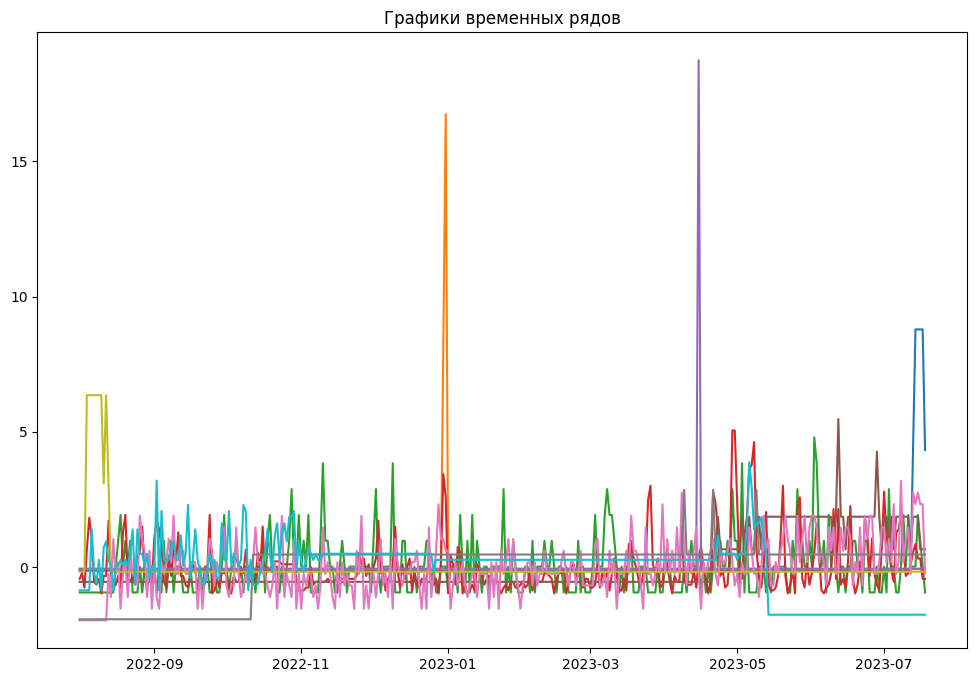

In [116]:
# Отрисуем несколько временных рядов
plt.figure(figsize=(12,8))
plt.plot(data_scaled[:10].T)
plt.title("Графики временных рядов")
plt.show();

Видно, что временные ряды отличаются, значит их можно будет разделить на кластера.

  0%|          | 0/20 [00:00<?, ?it/s]

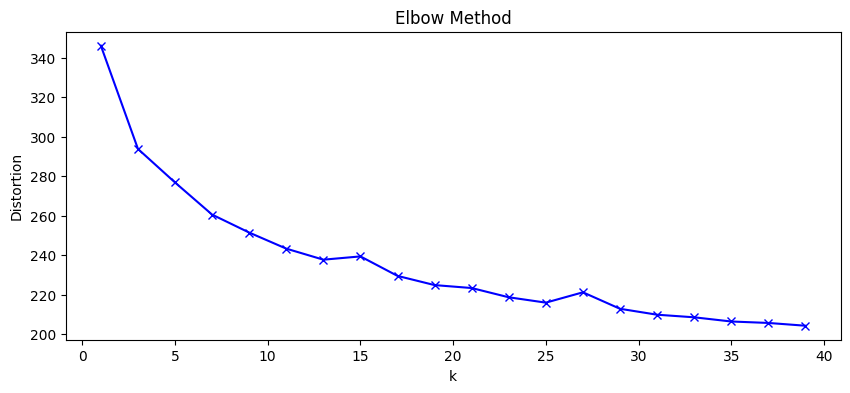

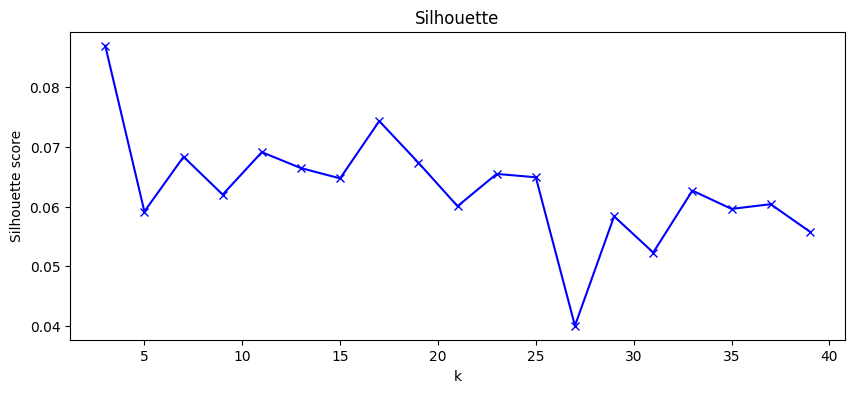

In [110]:
# Подберем оптимальное количество класетров методом локтя и при помощи Silhouette
distortions = []
silhouette = []

K = range(1, 40, 2)
for k in tqdm(K):
    
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=-1, max_iter=10)
    kmeanModel.fit(data_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(data_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

Остановимся на 15 кластерах.

In [111]:
# Обучим TimeSeriesKMeans на 15 кластерах
n_clusters = 15
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=3, max_iter=10)
ts_kmeans.fit(data_scaled)

TimeSeriesKMeans(max_iter=10, n_clusters=15, n_jobs=3)

In [112]:
# Сохраним обученную модель
dump(ts_kmeans, 'data/ts_kmeans.pkl')

['data/ts_kmeans.pkl']

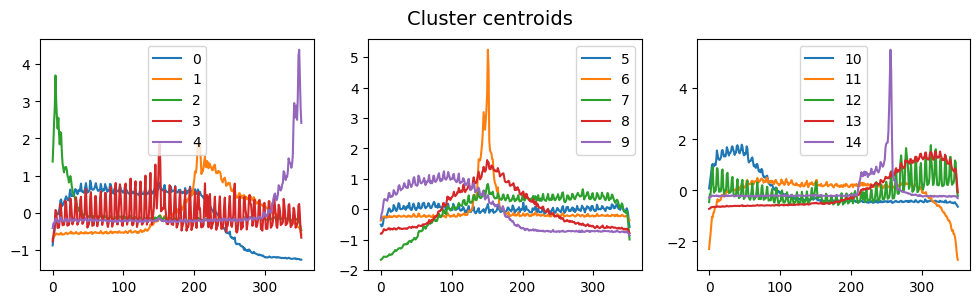

In [164]:
# Посмотрим на центроиды кластеров
fig = plt.figure(figsize=(12,3))

n = 0
for i in range(1, 4):
    plt.subplot(1, 3, i)
    for cluster_number in range(n, n + 5):
        plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
        plt.legend()
    n += 5

fig.suptitle("Cluster centroids", fontsize=14)
plt.show()

Видно, что центроиды разные, предполагаем, что модель достаточно качественно смогла разделить данные.

In [121]:
# Сопоставим набору данных номер кластера и посмотрим 
pt['cluster'] = ts_kmeans.predict(data_scaled)
pt.head()

st_id                         pr_sku_id  \
0  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
1  16a5cdae362b8d27a1d8f8c7b78b4330  005c52de11abaf8e0a9714b24415ce34   
2  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
3  16a5cdae362b8d27a1d8f8c7b78b4330  0094042bfeae507dc7f62acc8e5ed03a   
4  16a5cdae362b8d27a1d8f8c7b78b4330  0120fa9d93da50a73a6f61838b49ff46   

   2022-08-01 00:00:00  2022-08-02 00:00:00  2022-08-03 00:00:00  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    1                    1                    1   
3                    6                    8                    3   
4                    0                    0                    0   

   2022-08-04 00:00:00  2022-08-05 00:00:00  2022-08-06 00:00:00  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    1                    1                    1   
3                   16                   27                   20   
4                    0                    0                    0   

   2022-08-07 00:00:00  2022-08-08 00:00:00  ...  2023-07-10 00:00:00  \
0                    0                    0  ...                    0   
1                    0                    0  ...                    0   
2                    1                    1  ...                    2   
3                    5                    4  ...                    7   
4                    0                    0  ...                    0   

   2023-07-11 00:00:00  2023-07-12 00:00:00  2023-07-13 00:00:00  \
0                    0                    0                    1   
1                    0                    0                    0   
2                    4                    2                    2   
3                    8                   11                   15   
4                    0                    0                    0   

   2023-07-14 00:00:00  2023-07-15 00:00:00  2023-07-16 00:00:00  \
0                    2                    2                    2   
1                    0                    0                    0   
2                    2                    4                    3   
3                   18                   13                   13   
4                    0                    0                    0   

   2023-07-17 00:00:00  2023-07-18 00:00:00  cluster  
0                    2                    1        4  
1                    0                    0        6  
2                    2                    1        5  
3                    6                    6       12  
4                    0                    0       14  

[5 rows x 355 columns]

In [124]:
# Посмотрим как много товаров попало в каждый кластер
pd.DataFrame(pt['cluster'].value_counts())

cluster
5      1002
3       558
13      447
7       439
10      433
1       382
12      375
9       370
6       368
2       360
11      301
8       264
0       251
4       250
14      239

На сырых данных 4000 товаров были отнесены в один кластер из 15-ти. А в некоторых кластерах присутствовал 1 товар.

На данных после etna - распределение по кластерам более равномерное. Номер кластера можно использовать как признак для модели. Или попробовать логику разбиения данных для обучения отдельных моделей выполнять не на основе продаж по магазинам и товарам. А также принимать во внимание группировку по кластерам, так как предполагаем, что внутри кластера временные ряды схожие.

In [125]:
def plot_cluster_tickers(current_cluster):
    """Функция для отрисовки нескольких экземпляров временных рядов внутри каждого кластера."""
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.st_id}\n{row.pr_sku_id}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


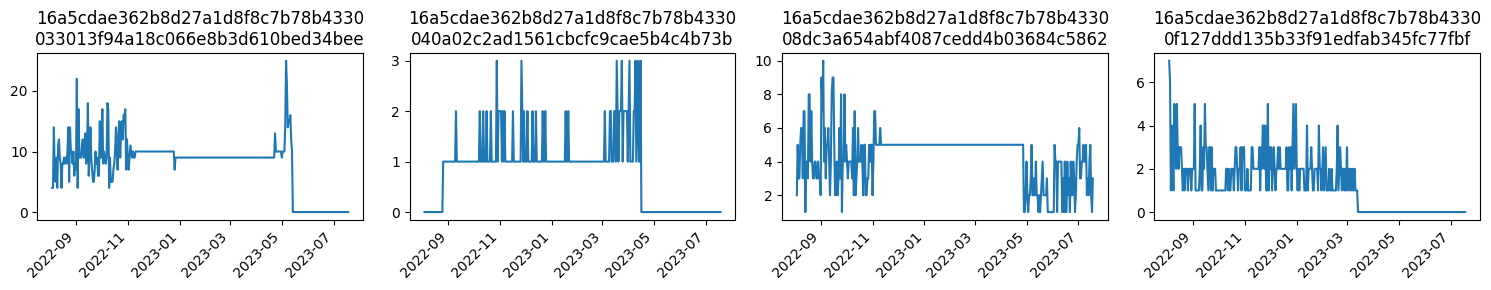

                          Cluster number: 1


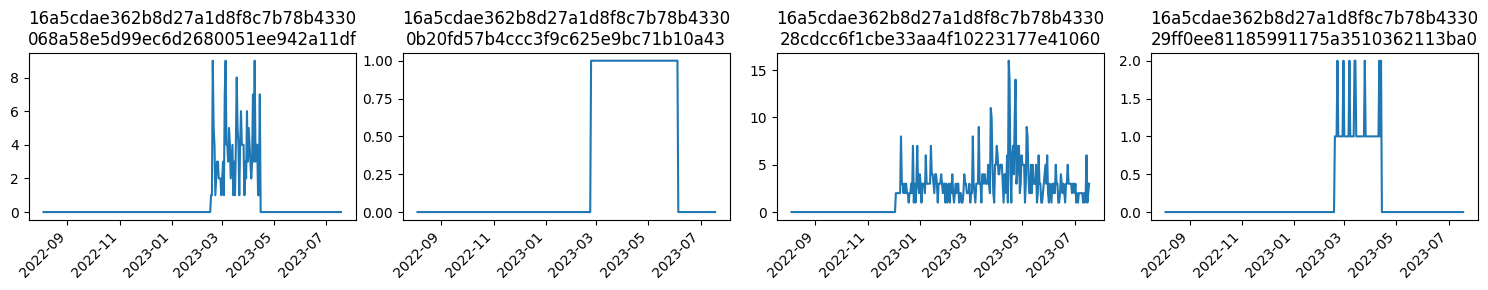

                          Cluster number: 2


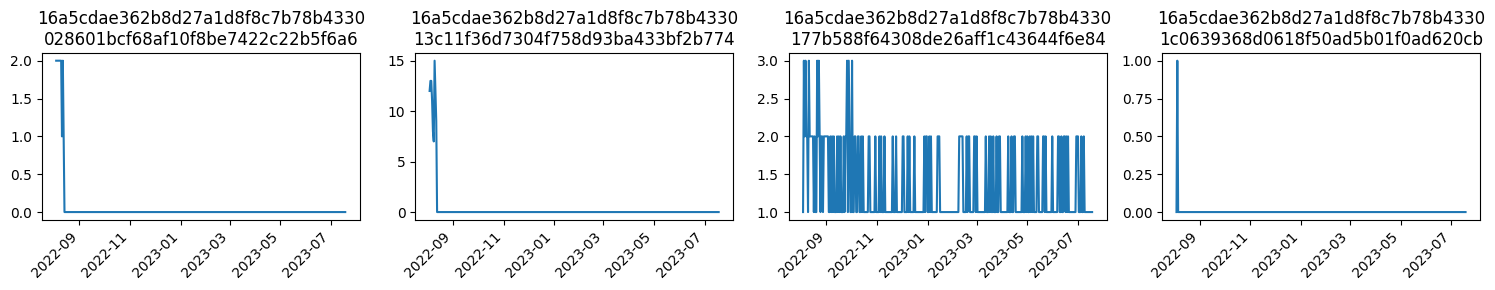

                          Cluster number: 3


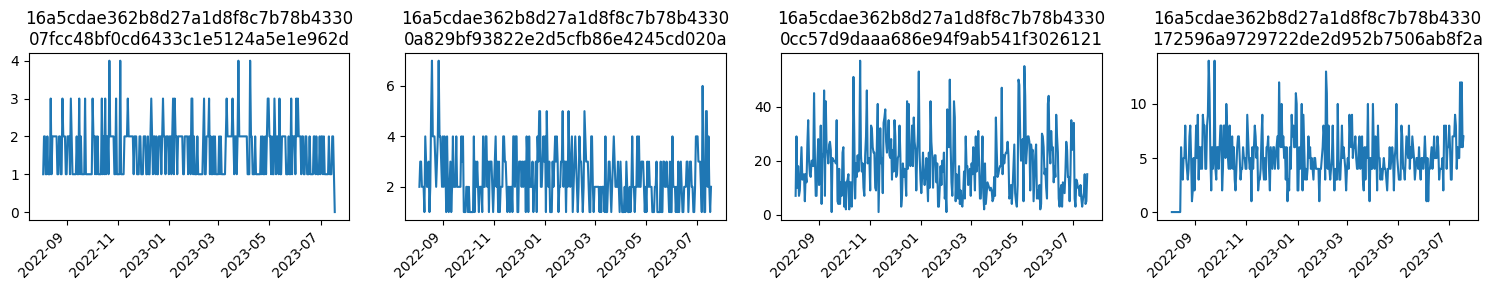

                          Cluster number: 4


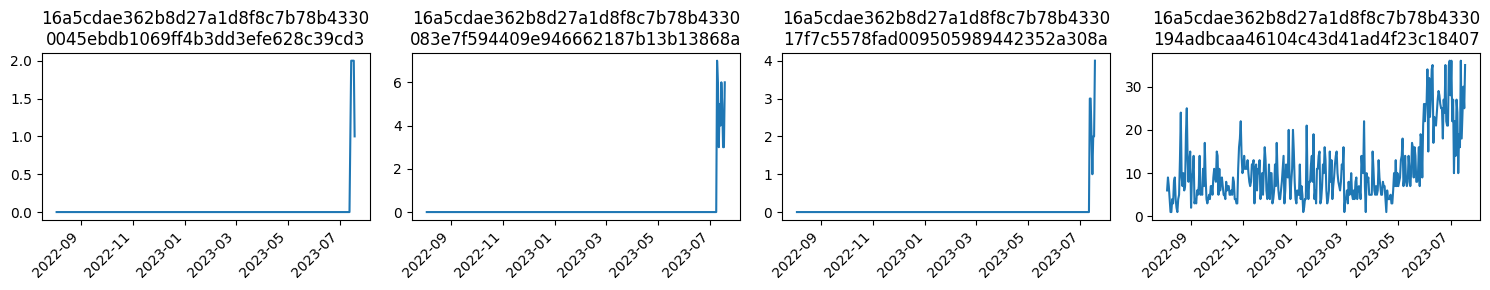

                          Cluster number: 5


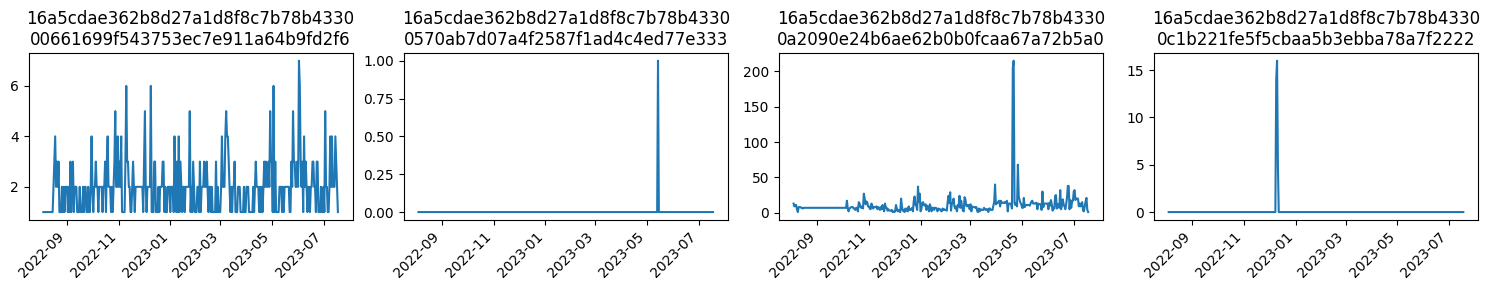

                          Cluster number: 6


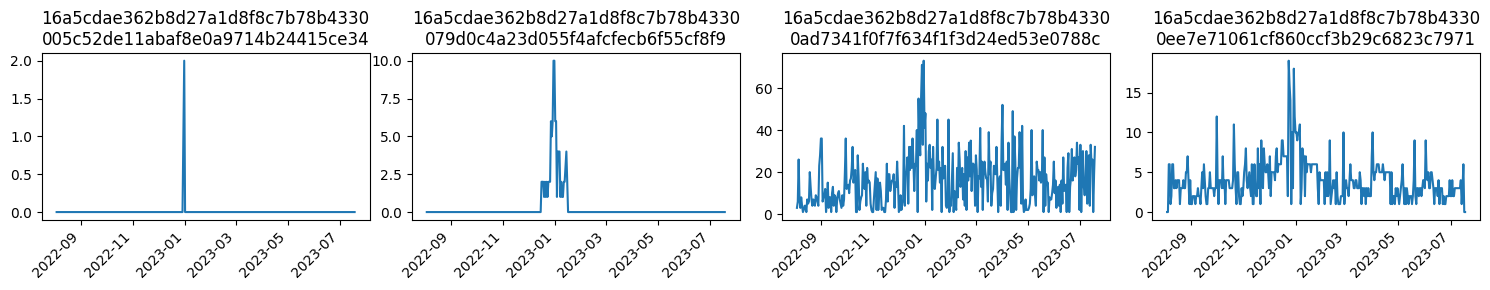

                          Cluster number: 7


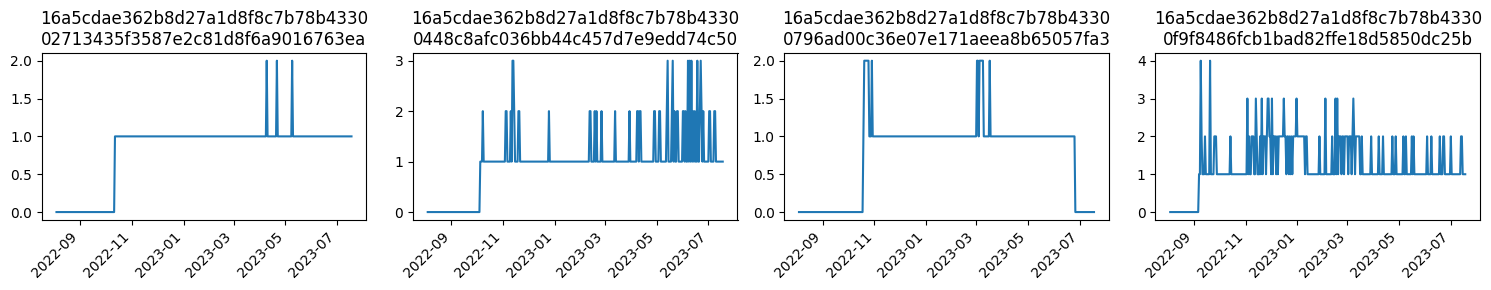

                          Cluster number: 8


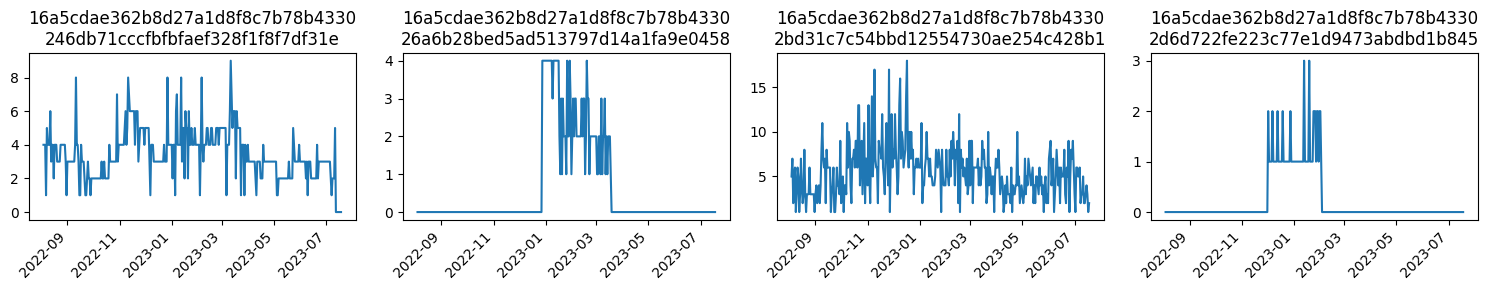

                          Cluster number: 9


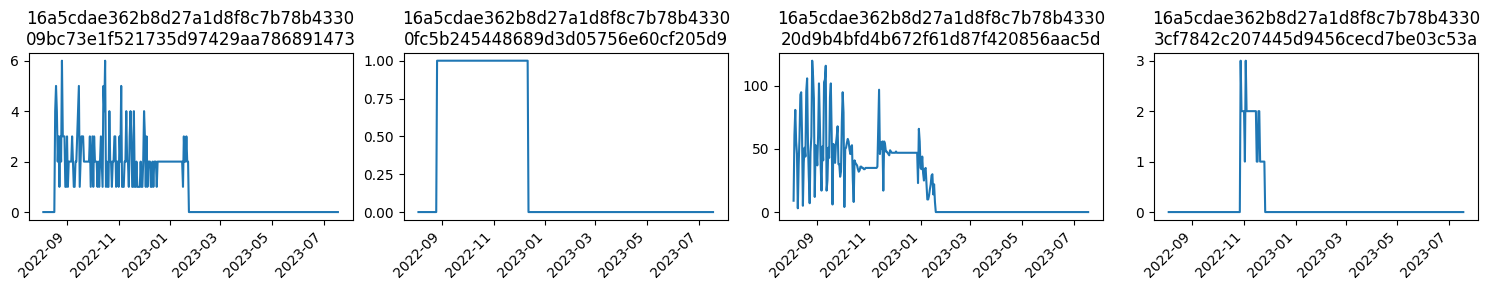

                          Cluster number: 10


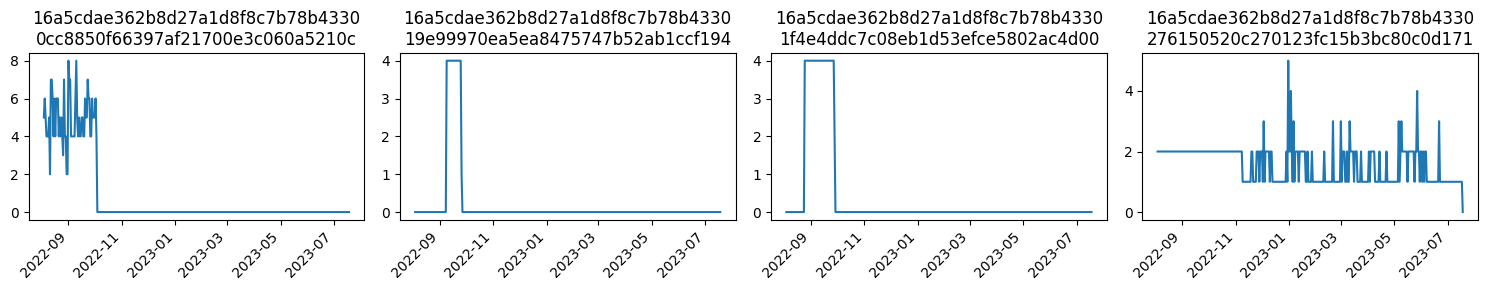

                          Cluster number: 11


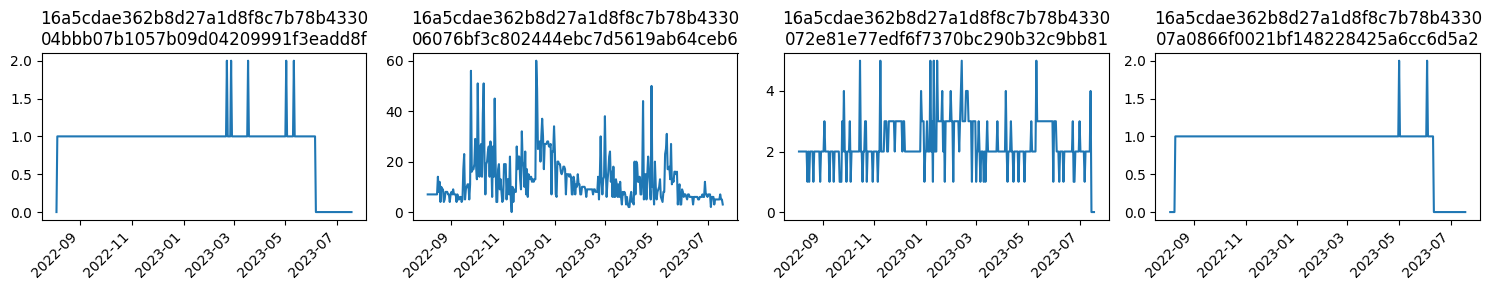

                          Cluster number: 12


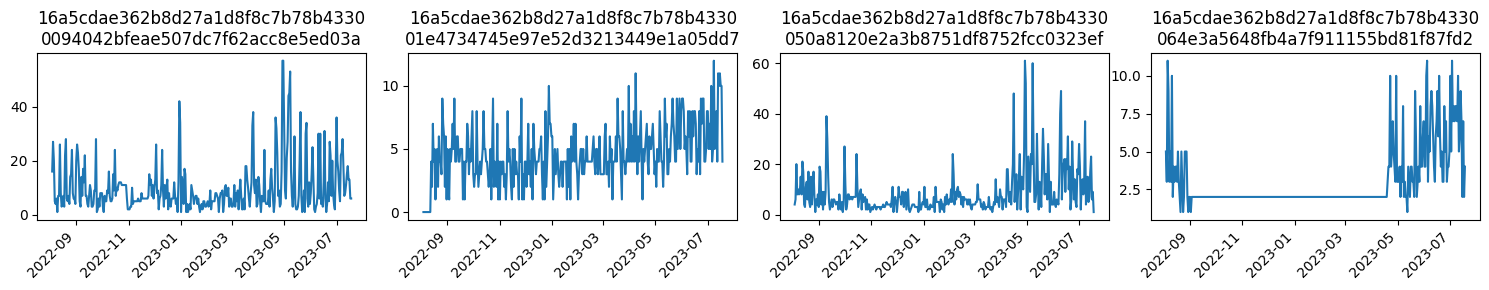

                          Cluster number: 13


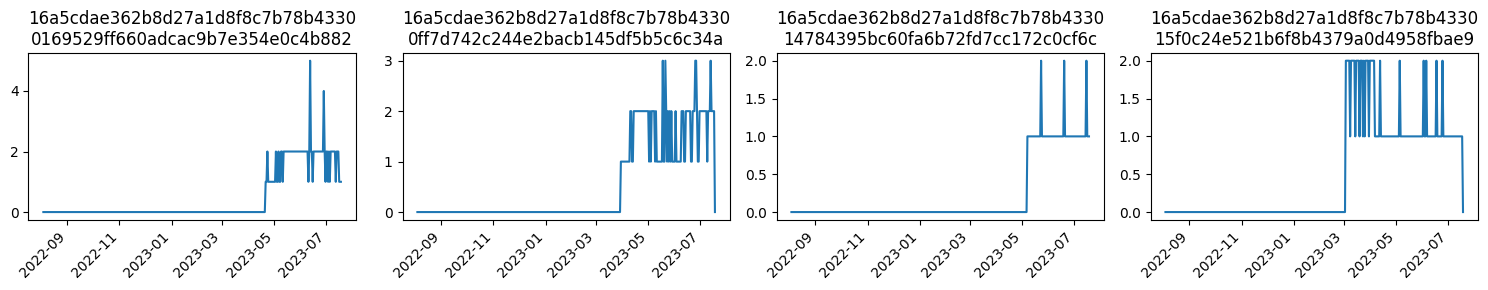

                          Cluster number: 14


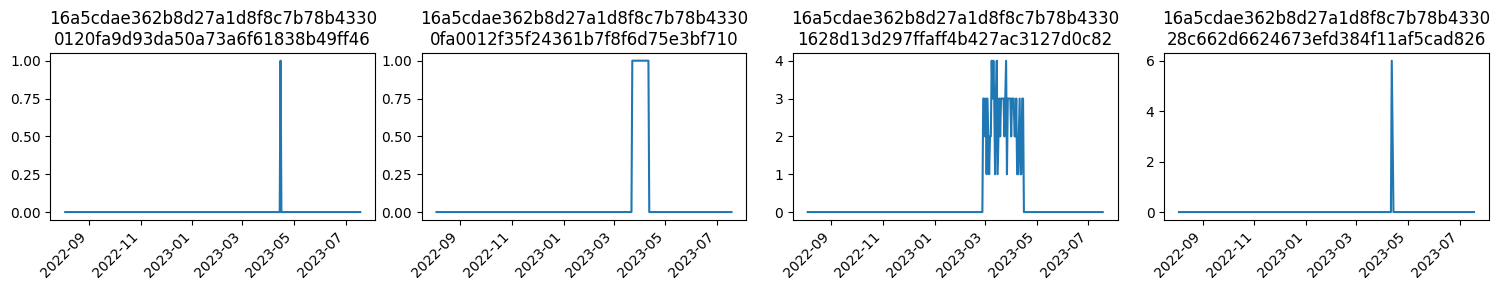

In [126]:
# Посмотрим как выглядят временные ряды внутри каждого кластера
for cluster in range(len(pt['cluster'].unique())):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(pt[pt['cluster']==cluster].head(4))

Для большинства графиков похожее поведение временного ряда действительно прослеживается внутри кластера. 

#### 3.4 Prophet

Результаты предсказания модели prophet можно использовать как дополнительные признаки, обучив потом на них бустинги.

In [129]:
# Посмотрим на работу модели на примере одного магазина и одного товара
temp = filled_df.loc[(filled_df['pr_sku_id'] ==  '00661699f543753ec7e911a64b9fd2f6')&(filled_df['st_id'] ==  '16a5cdae362b8d27a1d8f8c7b78b4330')]
temp.shape

(352, 15)

In [130]:
# Приведем данные к нужному для prophet формату
temp = temp[['date', 'total_sales_in_units']].rename(columns={'date': 'ds', 'total_sales_in_units': 'y'})
temp

ds  y
704  2022-08-01  1
705  2022-08-02  1
706  2022-08-03  1
707  2022-08-04  1
708  2022-08-05  1
...         ... ..
1051 2023-07-14  2
1052 2023-07-15  4
1053 2023-07-16  3
1054 2023-07-17  2
1055 2023-07-18  1

[352 rows x 2 columns]

In [131]:
# Определяем и обучаем модель
model = Prophet()
model.fit(temp)

16:08:01 - cmdstanpy - INFO - Chain [1] start processing
16:08:01 - cmdstanpy - INFO - Chain [1] done processing


In [138]:
# Сохраняем предсказания модели
future = model.make_future_dataframe(periods=14, freq='D')
forecast = model.predict(future)

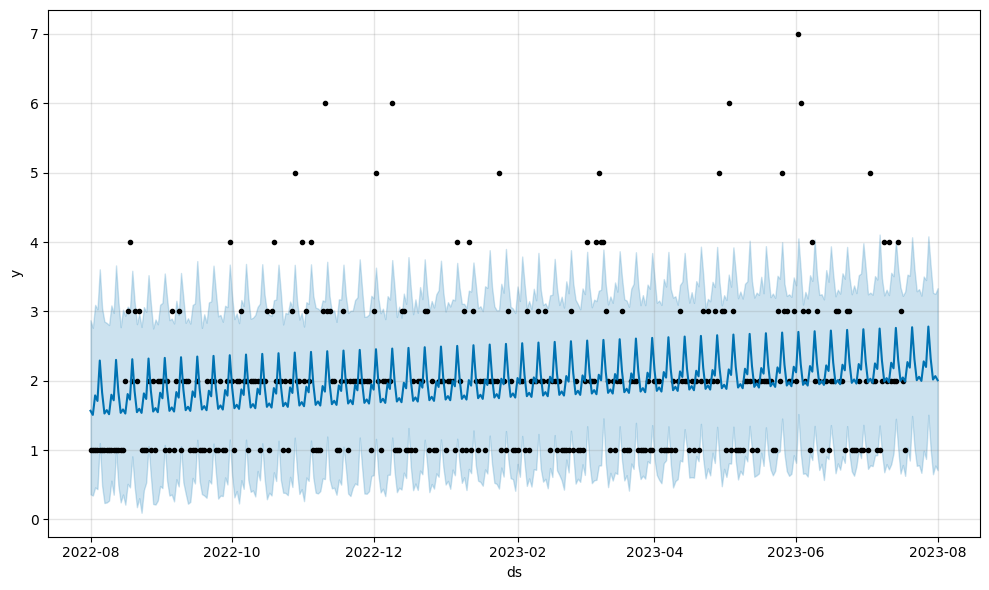

In [140]:
# Посмотрим на графическое представление реальных данных и предсказаний модели
model.plot(forecast);

In [142]:
# Оценим полученные признаки на 14 дней вперед
forecast.tail()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
361 2023-07-28  2.237065    1.509265    4.081875     2.237065     2.237065   
362 2023-07-29  2.238437    1.003424    3.649787     2.238437     2.238437   
363 2023-07-30  2.239810    0.652079    3.267596     2.239810     2.239810   
364 2023-07-31  2.241182    0.777417    3.253021     2.241182     2.241182   
365 2023-08-01  2.242554    0.709720    3.334427     2.242554     2.242554   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
361        0.544192              0.544192              0.544192  0.544192   
362        0.080527              0.080527              0.080527  0.080527   
363       -0.222364             -0.222364             -0.222364 -0.222364   
364       -0.174655             -0.174655             -0.174655 -0.174655   
365       -0.235206             -0.235206             -0.235206 -0.235206   

     weekly_lower  weekly_upper  multiplicative_terms  \
361      0.544192      0.544192                   0.0   
362      0.080527      0.080527                   0.0   
363     -0.222364     -0.222364                   0.0   
364     -0.174655     -0.174655                   0.0   
365     -0.235206     -0.235206                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
361                         0.0                         0.0  2.781257  
362                         0.0                         0.0  2.318965  
363                         0.0                         0.0  2.017445  
364                         0.0                         0.0  2.066527  
365                         0.0                         0.0  2.007348

In [145]:
%%time
# Создание признаков - предсказаний prophet для всего датасета
features = []

for store in filled_df['st_id'].unique():
    for product in tqdm(filled_df[filled_df['st_id'] == store]['pr_sku_id'].unique()):
        # Получаем текущий фрагмент данных для конкретного магазина и товара
        temp = filled_df[(filled_df['st_id'] == store) & (filled_df['pr_sku_id'] == product)]
        temp = temp[['date', 'total_sales_in_units']].rename(columns={'date': 'ds', 'total_sales_in_units': 'y'})
        model = Prophet()
        
        # Отключаем вывод дополнительной информации
        model.verbose = False
        model.fit(temp)
        future = model.make_future_dataframe(periods=14, freq='D')
        forecast = model.predict(future)
        features.append(forecast)

# Объединяем все заполненные данные в один DataFrame
prophet_features = pd.concat(features)

# Сброс индекса
prophet_features.reset_index(drop=True, inplace=True)

  0%|          | 0/952 [00:00<?, ?it/s]

16:19:24 - cmdstanpy - INFO - Chain [1] start processing
16:19:24 - cmdstanpy - INFO - Chain [1] done processing
16:19:24 - cmdstanpy - INFO - Chain [1] start processing
16:19:24 - cmdstanpy - INFO - Chain [1] done processing
16:19:25 - cmdstanpy - INFO - Chain [1] start processing
16:19:25 - cmdstanpy - INFO - Chain [1] done processing
16:19:25 - cmdstanpy - INFO - Chain [1] start processing
16:19:25 - cmdstanpy - INFO - Chain [1] done processing
16:19:26 - cmdstanpy - INFO - Chain [1] start processing
16:19:26 - cmdstanpy - INFO - Chain [1] done processing
16:19:26 - cmdstanpy - INFO - Chain [1] start processing
16:19:26 - cmdstanpy - INFO - Chain [1] done processing
16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:27 - cmdstanpy - INFO - Chain [1] done processing
16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:27 - cmdstanpy - INFO - Chain [1] done processing
16:19:28 - cmdstanpy - INFO - Chain [1] start processing
16:19:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/251 [00:00<?, ?it/s]

16:27:23 - cmdstanpy - INFO - Chain [1] start processing
16:27:23 - cmdstanpy - INFO - Chain [1] done processing
16:27:24 - cmdstanpy - INFO - Chain [1] start processing
16:27:24 - cmdstanpy - INFO - Chain [1] done processing
16:27:24 - cmdstanpy - INFO - Chain [1] start processing
16:27:24 - cmdstanpy - INFO - Chain [1] done processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] done processing
16:27:26 - cmdstanpy - INFO - Chain [1] start processing
16:27:26 - cmdstanpy - INFO - Chain [1] done processing
16:27:26 - cmdstanpy - INFO - Chain [1] start processing
16:27:26 - cmdstanpy - INFO - Chain [1] done processing
16:27:27 - cmdstanpy - INFO - Chain [1] start processing
16:27:27 - cmdstanpy - INFO - Chain [1] done processing
16:27:27 - cmdstanpy - INFO - Chain [1] start processing
16:27:27 - cmdstanpy - INFO - Chain [1] done processing
16:27:28 - cmdstanpy - INFO - Chain [1] start processing
16:27:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/1016 [00:00<?, ?it/s]

16:29:30 - cmdstanpy - INFO - Chain [1] start processing
16:29:30 - cmdstanpy - INFO - Chain [1] done processing
16:29:30 - cmdstanpy - INFO - Chain [1] start processing
16:29:30 - cmdstanpy - INFO - Chain [1] done processing
16:29:31 - cmdstanpy - INFO - Chain [1] start processing
16:29:31 - cmdstanpy - INFO - Chain [1] done processing
16:29:31 - cmdstanpy - INFO - Chain [1] start processing
16:29:31 - cmdstanpy - INFO - Chain [1] done processing
16:29:32 - cmdstanpy - INFO - Chain [1] start processing
16:29:32 - cmdstanpy - INFO - Chain [1] done processing
16:29:32 - cmdstanpy - INFO - Chain [1] start processing
16:29:32 - cmdstanpy - INFO - Chain [1] done processing
16:29:33 - cmdstanpy - INFO - Chain [1] start processing
16:29:33 - cmdstanpy - INFO - Chain [1] done processing
16:29:33 - cmdstanpy - INFO - Chain [1] start processing
16:29:33 - cmdstanpy - INFO - Chain [1] done processing
16:29:34 - cmdstanpy - INFO - Chain [1] start processing
16:29:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/111 [00:00<?, ?it/s]

16:37:46 - cmdstanpy - INFO - Chain [1] start processing
16:37:46 - cmdstanpy - INFO - Chain [1] done processing
16:37:47 - cmdstanpy - INFO - Chain [1] start processing
16:37:47 - cmdstanpy - INFO - Chain [1] done processing
16:37:47 - cmdstanpy - INFO - Chain [1] start processing
16:37:47 - cmdstanpy - INFO - Chain [1] done processing
16:37:48 - cmdstanpy - INFO - Chain [1] start processing
16:37:48 - cmdstanpy - INFO - Chain [1] done processing
16:37:49 - cmdstanpy - INFO - Chain [1] start processing
16:37:49 - cmdstanpy - INFO - Chain [1] done processing
16:37:49 - cmdstanpy - INFO - Chain [1] start processing
16:37:49 - cmdstanpy - INFO - Chain [1] done processing
16:37:50 - cmdstanpy - INFO - Chain [1] start processing
16:37:50 - cmdstanpy - INFO - Chain [1] done processing
16:37:50 - cmdstanpy - INFO - Chain [1] start processing
16:37:50 - cmdstanpy - INFO - Chain [1] done processing
16:37:51 - cmdstanpy - INFO - Chain [1] start processing
16:37:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/887 [00:00<?, ?it/s]

16:38:43 - cmdstanpy - INFO - Chain [1] start processing
16:38:43 - cmdstanpy - INFO - Chain [1] done processing
16:38:43 - cmdstanpy - INFO - Chain [1] start processing
16:38:43 - cmdstanpy - INFO - Chain [1] done processing
16:38:44 - cmdstanpy - INFO - Chain [1] start processing
16:38:44 - cmdstanpy - INFO - Chain [1] done processing
16:38:44 - cmdstanpy - INFO - Chain [1] start processing
16:38:44 - cmdstanpy - INFO - Chain [1] done processing
16:38:45 - cmdstanpy - INFO - Chain [1] start processing
16:38:45 - cmdstanpy - INFO - Chain [1] done processing
16:38:45 - cmdstanpy - INFO - Chain [1] start processing
16:38:45 - cmdstanpy - INFO - Chain [1] done processing
16:38:46 - cmdstanpy - INFO - Chain [1] start processing
16:38:46 - cmdstanpy - INFO - Chain [1] done processing
16:38:46 - cmdstanpy - INFO - Chain [1] start processing
16:38:46 - cmdstanpy - INFO - Chain [1] done processing
16:38:47 - cmdstanpy - INFO - Chain [1] start processing
16:38:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/1074 [00:00<?, ?it/s]

16:45:56 - cmdstanpy - INFO - Chain [1] start processing
16:45:56 - cmdstanpy - INFO - Chain [1] done processing
16:45:56 - cmdstanpy - INFO - Chain [1] start processing
16:45:56 - cmdstanpy - INFO - Chain [1] done processing
16:45:57 - cmdstanpy - INFO - Chain [1] start processing
16:45:57 - cmdstanpy - INFO - Chain [1] done processing
16:45:57 - cmdstanpy - INFO - Chain [1] start processing
16:45:57 - cmdstanpy - INFO - Chain [1] done processing
16:45:58 - cmdstanpy - INFO - Chain [1] start processing
16:45:58 - cmdstanpy - INFO - Chain [1] done processing
16:45:58 - cmdstanpy - INFO - Chain [1] start processing
16:45:58 - cmdstanpy - INFO - Chain [1] done processing
16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing
16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing
16:46:00 - cmdstanpy - INFO - Chain [1] start processing
16:46:00 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/939 [00:00<?, ?it/s]

16:54:49 - cmdstanpy - INFO - Chain [1] start processing
16:54:49 - cmdstanpy - INFO - Chain [1] done processing
16:54:49 - cmdstanpy - INFO - Chain [1] start processing
16:54:49 - cmdstanpy - INFO - Chain [1] done processing
16:54:50 - cmdstanpy - INFO - Chain [1] start processing
16:54:50 - cmdstanpy - INFO - Chain [1] done processing
16:54:50 - cmdstanpy - INFO - Chain [1] start processing
16:54:51 - cmdstanpy - INFO - Chain [1] done processing
16:54:51 - cmdstanpy - INFO - Chain [1] start processing
16:54:51 - cmdstanpy - INFO - Chain [1] done processing
16:54:52 - cmdstanpy - INFO - Chain [1] start processing
16:54:52 - cmdstanpy - INFO - Chain [1] done processing
16:54:52 - cmdstanpy - INFO - Chain [1] start processing
16:54:52 - cmdstanpy - INFO - Chain [1] done processing
16:54:53 - cmdstanpy - INFO - Chain [1] start processing
16:54:53 - cmdstanpy - INFO - Chain [1] done processing
16:54:54 - cmdstanpy - INFO - Chain [1] start processing
16:54:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/809 [00:00<?, ?it/s]

17:02:56 - cmdstanpy - INFO - Chain [1] start processing
17:02:56 - cmdstanpy - INFO - Chain [1] done processing
17:02:56 - cmdstanpy - INFO - Chain [1] start processing
17:02:56 - cmdstanpy - INFO - Chain [1] done processing
17:02:57 - cmdstanpy - INFO - Chain [1] start processing
17:02:57 - cmdstanpy - INFO - Chain [1] done processing
17:02:57 - cmdstanpy - INFO - Chain [1] start processing
17:02:57 - cmdstanpy - INFO - Chain [1] done processing
17:02:58 - cmdstanpy - INFO - Chain [1] start processing
17:02:58 - cmdstanpy - INFO - Chain [1] done processing
17:02:59 - cmdstanpy - INFO - Chain [1] start processing
17:02:59 - cmdstanpy - INFO - Chain [1] done processing
17:02:59 - cmdstanpy - INFO - Chain [1] start processing
17:02:59 - cmdstanpy - INFO - Chain [1] done processing
17:03:00 - cmdstanpy - INFO - Chain [1] start processing
17:03:00 - cmdstanpy - INFO - Chain [1] done processing
17:03:00 - cmdstanpy - INFO - Chain [1] start processing
17:03:00 - cmdstanpy - INFO - Chain [1]

CPU times: total: 35min 16s
Wall time: 51min 8s


In [148]:
# Сохраняем в csv
prophet_features.to_csv('data/prophet_features.csv', index = False)

В данном пункте было сгенерировано множество признаков различными  методами.  

- Библиотека TSFresh. Выбрали настройку EfficientParameters. Это дало 777 признаков.   
_Сложности оказались в отборе признаков, так как нам нужна была регрессия и для нее нужен таргет._ 

- Кластеризация временных рядов. Отбор количества признаков был сделан через elbow method и Silhouette. Получилось 15 кластеров. Их распределение получилось довольно равномерно на обработанных данных, в отличие от сырых. Временные ряды в пределах одного кластера демонстрируют схожее поведение.  
_Сложности оказались в нехватке времени для проверки этого метода в модели._

- Предсказания Prophet. Это дало нам 16 признаков, которые можно использовать для дальнейшего предсказания в качестве признаков для бустинговых моделей.  
_Это внесли в модель, так как метрика улучшилась после добавления признаков из Prophet._

_Вопросы на ревью_

Сейчас много фичей сгенерировано нужно провести feature selection. Однако тут не понятно каким инструментом можно воспользоваться так как известные способы (например рекурсивный отбор - sklearn.feature_selection.RFECV) требуют указать таргет. Просим ревьюера помочь с вопросом, что можно использовать, и,  будет ли корректно использовать как target, например, сумму продаж в единицах за весь период для каждого товара (или среднее, медиану и проч.).
Будем очень рады, если подскажете.

### 4. Modeling

#### 4.1 Загрузка и предобработка данных

In [3]:
'''В случае изменений в предобработке данных, удалить файл filled_df.csv'''
try:
    # Загрузка ранее сохраненных предобработанных данных
    with open(os.path.join(DATA_PATH, "preprocessed/cat_features.json"), "r") as file:
        CAT_FEATURES = json.load(file)
    with open(os.path.join(DATA_PATH, "preprocessed/exog_vars.json"), "r") as file:
        EXOG_VARS = json.load(file)
    filled_df = pd.read_csv(os.path.join(DATA_PATH, "preprocessed/filled_df.csv"), parse_dates=['ds'])
    types_changing(filled_df, CAT_FEATURES)
    means = pd.read_csv(os.path.join(DATA_PATH, "preprocessed/means.csv"))
except IOError:
    # Выполнение предобработки данных
    preprocessor = Preprocessor()
    filled_df, means, CAT_FEATURES, EXOG_VARS = preprocessor.train_preprocess()
    # Сохранение обработанных данных в файл
    with open(os.path.join(DATA_PATH, "preprocessed/cat_features.json"), "w") as file:
        json.dump(CAT_FEATURES, file)
    with open(os.path.join(DATA_PATH, "preprocessed/exog_vars.json"), "w") as file:
        json.dump(EXOG_VARS, file)
    filled_df.to_csv(os.path.join(DATA_PATH, "preprocessed/filled_df.csv"), index=False)
    means.to_csv(os.path.join(DATA_PATH, "preprocessed/means.csv"), index=False)

In [4]:
# Делаем срез данных по одному магазину и одному товару
df_test = filled_df.loc[(filled_df['pr_sku_id'] == '00661699f543753ec7e911a64b9fd2f6')&(filled_df['st_id'] == '16a5cdae362b8d27a1d8f8c7b78b4330')]

#### 4.2 Подбор гиперпараметров моделей бустингов на кросс-валидации

In [5]:
# Оптимизация модели
opt_res = {}
opt_res['models'] = [model.__class__.__name__ for model in models]
for model in models:
    opt = Optimizer(df_test, model, CAT_FEATURES, means)
    metric, params = opt.tuning_optimize(trials=20)
    lags = params['lags']
    del params['lags']
    opt_res[model.__class__.__name__] = ([metric, params, lags])

# Сохранение параметров в файл
with open(os.path.join(DATA_PATH, "optuna/optimization_result.json"), "w") as file:
    json.dump(opt_res, file)

[I 2023-10-09 23:42:57,309] A new study created in memory with name: no-name-685a10b8-a2d6-4b85-adb2-1a852256bc93
[I 2023-10-09 23:43:23,702] Trial 0 finished with value: 0.36794601090625106 and parameters: {'learning_rate': 0.01680002207318712, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.30427652375089387, 'colsample_bytree': 0.8214306055608885, 'lags': 21}. Best is trial 0 with value: 0.36794601090625106.


Trial results: [0.27855348189426976, 0.5022438325345865, 0.3230407182898969]


[I 2023-10-09 23:43:46,556] Trial 1 finished with value: 0.37848397908245596 and parameters: {'learning_rate': 0.0026810108604180607, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7164988977753949, 'colsample_bytree': 0.6514295981884695, 'lags': 35}. Best is trial 0 with value: 0.36794601090625106.


Trial results: [0.3057179850358568, 0.49667820870616636, 0.33305574350534467]


[I 2023-10-09 23:43:59,680] Trial 2 finished with value: 0.35526434170553983 and parameters: {'learning_rate': 0.004099354741842401, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.5260597697277645, 'colsample_bytree': 0.39426545522319933, 'lags': 14}. Best is trial 2 with value: 0.35526434170553983.


Trial results: [0.27505381710646726, 0.4704536298539659, 0.32028557815618636]


[I 2023-10-09 23:44:40,866] Trial 3 finished with value: 0.3658628037850559 and parameters: {'learning_rate': 0.0011842857710535875, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.13171694930949338, 'colsample_bytree': 0.7481226534903601, 'lags': 21}. Best is trial 2 with value: 0.35526434170553983.


Trial results: [0.28070453270355156, 0.49042982466688567, 0.3264540539847305]


[I 2023-10-09 23:44:59,121] Trial 4 finished with value: 0.3750431920567307 and parameters: {'learning_rate': 0.0016605474785659075, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.39624272852276043, 'colsample_bytree': 0.49712546786694967, 'lags': 49}. Best is trial 2 with value: 0.35526434170553983.


Trial results: [0.2983728919667248, 0.4954452525439572, 0.33131143165951005]


[I 2023-10-09 23:45:59,078] Trial 5 finished with value: 0.39987455710694536 and parameters: {'learning_rate': 0.020944355752929945, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.26621729257473625, 'colsample_bytree': 0.7948422047710647, 'lags': 35}. Best is trial 2 with value: 0.35526434170553983.


Trial results: [0.3607805229648854, 0.49551990607289825, 0.3433232422830526]


[I 2023-10-09 23:46:26,133] Trial 6 finished with value: 0.3737169659200073 and parameters: {'learning_rate': 0.0016557291024864786, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.896650029254485, 'colsample_bytree': 0.6470361768176276, 'lags': 35}. Best is trial 2 with value: 0.35526434170553983.


Trial results: [0.2955158611433009, 0.4953200532242436, 0.33031498339247756]


[I 2023-10-09 23:47:24,320] Trial 7 finished with value: 0.4280541161174242 and parameters: {'learning_rate': 0.0810667460130944, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.8425269719797608, 'colsample_bytree': 0.9772374996494324, 'lags': 56}. Best is trial 2 with value: 0.35526434170553983.


Trial results: [0.35415566201178283, 0.5222760293717787, 0.40773065696871097]


[I 2023-10-09 23:47:49,987] Trial 8 finished with value: 0.36261711033751093 and parameters: {'learning_rate': 0.0012754957817178642, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9127511238123803, 'colsample_bytree': 0.45807307431056965, 'lags': 14}. Best is trial 2 with value: 0.35526434170553983.


Trial results: [0.2783447890952332, 0.4827936052657953, 0.32671293665150436]


[I 2023-10-09 23:48:26,572] Trial 9 finished with value: 0.3970832182863715 and parameters: {'learning_rate': 0.026679217214839204, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.13952047538918524, 'colsample_bytree': 0.2820417595283252, 'lags': 35}. Best is trial 2 with value: 0.35526434170553983.


Trial results: [0.3474073389392338, 0.4866249636621008, 0.35721735225777984]


[I 2023-10-09 23:48:32,191] Trial 10 finished with value: 0.36001900578531165 and parameters: {'learning_rate': 0.005401351129299265, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.5455926048462892, 'colsample_bytree': 0.11619925905540668, 'lags': 14}. Best is trial 2 with value: 0.35526434170553983.


Trial results: [0.27734752433383814, 0.4765178573824623, 0.3261916356396347]


[I 2023-10-09 23:48:36,976] Trial 11 finished with value: 0.36404146475400556 and parameters: {'learning_rate': 0.00498365340235991, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.5724923293744794, 'colsample_bytree': 0.1117195943557967, 'lags': 14}. Best is trial 2 with value: 0.35526434170553983.


Trial results: [0.2816820551929857, 0.4846139642971755, 0.3258283747718554]


[I 2023-10-09 23:48:48,389] Trial 12 finished with value: 0.35200651353468154 and parameters: {'learning_rate': 0.005995893556028684, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5502953132612949, 'colsample_bytree': 0.30721765510860755, 'lags': 21}. Best is trial 12 with value: 0.35200651353468154.


Trial results: [0.2741982061619119, 0.46074679484250125, 0.3210745395996316]


[I 2023-10-09 23:49:05,733] Trial 13 finished with value: 0.3569137257905018 and parameters: {'learning_rate': 0.005347416450657774, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.5274931566864531, 'colsample_bytree': 0.3703010238383732, 'lags': 21}. Best is trial 12 with value: 0.35200651353468154.


Trial results: [0.27304777638038147, 0.47386723613347875, 0.3238261648576453]


[I 2023-10-09 23:49:28,946] Trial 14 finished with value: 0.3605261529885695 and parameters: {'learning_rate': 0.008074488641513273, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.7349149036974367, 'colsample_bytree': 0.27910987855452607, 'lags': 28}. Best is trial 12 with value: 0.35200651353468154.


Trial results: [0.2773879711838188, 0.4730826658913779, 0.3311078218905118]


[I 2023-10-09 23:49:58,916] Trial 15 finished with value: 0.367082267093074 and parameters: {'learning_rate': 0.0031483710562601056, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.4528284822601124, 'colsample_bytree': 0.38133119825563777, 'lags': 28}. Best is trial 12 with value: 0.35200651353468154.


Trial results: [0.2882555921598814, 0.47832191925421547, 0.33466928986512506]


[I 2023-10-09 23:50:19,615] Trial 16 finished with value: 0.3553296228591763 and parameters: {'learning_rate': 0.010606041363431497, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6367386943902622, 'colsample_bytree': 0.5524835989607069, 'lags': 21}. Best is trial 12 with value: 0.35200651353468154.


Trial results: [0.2770875769332831, 0.45866034344810985, 0.330240948196136]


[I 2023-10-09 23:50:35,097] Trial 17 finished with value: 0.363270159573791 and parameters: {'learning_rate': 0.0028318720215343455, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.9986182434622879, 'colsample_bytree': 0.28365150244998344, 'lags': 28}. Best is trial 12 with value: 0.35200651353468154.


Trial results: [0.28378255070761393, 0.48095744344305746, 0.3250704845707016]


[I 2023-10-09 23:50:49,003] Trial 18 finished with value: 0.38661493250862283 and parameters: {'learning_rate': 0.011281126500664262, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.44591820703691537, 'colsample_bytree': 0.18317185761660948, 'lags': 49}. Best is trial 12 with value: 0.35200651353468154.


Trial results: [0.3400141942239772, 0.46312071131393007, 0.3567098919879612]


[I 2023-10-09 23:51:02,605] Trial 19 finished with value: 0.35580345837557803 and parameters: {'learning_rate': 0.0033842330316310393, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.6502347320219086, 'colsample_bytree': 0.40758622708828074, 'lags': 14}. Best is trial 12 with value: 0.35200651353468154.
[I 2023-10-09 23:51:02,607] A new study created in memory with name: no-name-533fa064-bcaa-432a-9895-518e979b976d


Trial results: [0.2755266359914437, 0.4685782133622249, 0.32330552577306554]


[I 2023-10-09 23:51:05,019] Trial 0 finished with value: 0.39504316388366806 and parameters: {'learning_rate': 0.029786798462864684, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.4795370569813927, 'colsample_bytree': 0.428112638267244, 'lags': 56}. Best is trial 0 with value: 0.39504316388366806.


Trial results: [0.37602424495289627, 0.380486289895901, 0.4286189568022071]


[I 2023-10-09 23:51:07,703] Trial 1 finished with value: 0.3627973345517255 and parameters: {'learning_rate': 0.0011762547716795682, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.5085235971473184, 'colsample_bytree': 0.14371949040376264, 'lags': 21}. Best is trial 1 with value: 0.3627973345517255.


Trial results: [0.2772560661734671, 0.487152321271529, 0.3239836162101806]


[I 2023-10-09 23:51:10,684] Trial 2 finished with value: 0.3598905633177336 and parameters: {'learning_rate': 0.004597460281640157, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.1668486785334637, 'colsample_bytree': 0.5027242575725658, 'lags': 42}. Best is trial 2 with value: 0.3598905633177336.


Trial results: [0.29058088822292366, 0.45967538666155605, 0.32941541506872113]


[I 2023-10-09 23:51:13,335] Trial 3 finished with value: 0.4003455567566043 and parameters: {'learning_rate': 0.09962194923683004, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8010870793065884, 'colsample_bytree': 0.9779391358585182, 'lags': 49}. Best is trial 2 with value: 0.3598905633177336.


Trial results: [0.38857341934843115, 0.44812579428954286, 0.36433745663183886]


[I 2023-10-09 23:51:15,938] Trial 4 finished with value: 0.3723279609977565 and parameters: {'learning_rate': 0.04530879854852443, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.3321186967040438, 'colsample_bytree': 0.48366439605717415, 'lags': 28}. Best is trial 2 with value: 0.3598905633177336.


Trial results: [0.2915924234995424, 0.43594254571603464, 0.38944891377769236]


[I 2023-10-09 23:51:18,507] Trial 5 finished with value: 0.40725693064931295 and parameters: {'learning_rate': 0.020733538322322064, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.4602527641499474, 'colsample_bytree': 0.9134731495009422, 'lags': 42}. Best is trial 2 with value: 0.3598905633177336.


Trial results: [0.3705308274990395, 0.4448333472408465, 0.4064066172080528]


[I 2023-10-09 23:51:21,136] Trial 6 finished with value: 0.36470322844226355 and parameters: {'learning_rate': 0.002959044174258766, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.12017094631660773, 'colsample_bytree': 0.7557087327568012, 'lags': 56}. Best is trial 2 with value: 0.3598905633177336.


Trial results: [0.2801996903246435, 0.48687992405880776, 0.32703007094333936]


[I 2023-10-09 23:51:24,095] Trial 7 finished with value: 0.36077708995106694 and parameters: {'learning_rate': 0.0020038268775205413, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.3856439714059674, 'colsample_bytree': 0.7675139438865488, 'lags': 21}. Best is trial 2 with value: 0.3598905633177336.


Trial results: [0.2745707842981131, 0.4814958251628951, 0.3262646603921926]


[I 2023-10-09 23:51:26,962] Trial 8 finished with value: 0.352123046385948 and parameters: {'learning_rate': 0.002381182543975303, 'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.9484720125829768, 'colsample_bytree': 0.5002187103568018, 'lags': 28}. Best is trial 8 with value: 0.352123046385948.


Trial results: [0.2741105317132885, 0.45564322199941154, 0.32661538544514396]


[I 2023-10-09 23:51:29,641] Trial 9 finished with value: 0.3595363767112106 and parameters: {'learning_rate': 0.006529599178706337, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.49198618456348264, 'colsample_bytree': 0.35642119018026563, 'lags': 35}. Best is trial 8 with value: 0.352123046385948.


Trial results: [0.295081594103352, 0.45649363148114985, 0.32703390454912995]


[I 2023-10-09 23:51:32,444] Trial 10 finished with value: 0.36556840637468 and parameters: {'learning_rate': 0.0010368796549926646, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.9992257776613296, 'colsample_bytree': 0.6468484528420921, 'lags': 14}. Best is trial 8 with value: 0.352123046385948.


Trial results: [0.28058914241079747, 0.4920677676595905, 0.32404830905365206]


[I 2023-10-09 23:51:35,266] Trial 11 finished with value: 0.3574335221380416 and parameters: {'learning_rate': 0.007873968803423562, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.7152431800164021, 'colsample_bytree': 0.34927975719862964, 'lags': 35}. Best is trial 8 with value: 0.352123046385948.


Trial results: [0.30069240441544404, 0.44630198922450887, 0.32530617277417195]


[I 2023-10-09 23:51:38,295] Trial 12 finished with value: 0.35534345283123653 and parameters: {'learning_rate': 0.010238563737795078, 'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.7111986810795775, 'colsample_bytree': 0.28419930268791527, 'lags': 35}. Best is trial 8 with value: 0.352123046385948.


Trial results: [0.2996858738887008, 0.43127993802340564, 0.3350645465816031]


[I 2023-10-09 23:51:41,234] Trial 13 finished with value: 0.3521140959302346 and parameters: {'learning_rate': 0.012897652165512476, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7241976309416285, 'colsample_bytree': 0.173689643952049, 'lags': 28}. Best is trial 13 with value: 0.3521140959302346.


Trial results: [0.2937106227674764, 0.44021796991580786, 0.3224136951074195]


[I 2023-10-09 23:51:43,996] Trial 14 finished with value: 0.6474202619310215 and parameters: {'learning_rate': 0.013625458054538696, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.9863439755969066, 'colsample_bytree': 0.11560815850190465, 'lags': 28}. Best is trial 13 with value: 0.3521140959302346.


Trial results: [1.1259642396906187, 0.454818388543202, 0.36147815755924406]


[I 2023-10-09 23:51:46,916] Trial 15 finished with value: 0.35473118997425584 and parameters: {'learning_rate': 0.003972555912139019, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.846116920135843, 'colsample_bytree': 0.24242091011699712, 'lags': 21}. Best is trial 13 with value: 0.3521140959302346.


Trial results: [0.2769746914575571, 0.4643528985148887, 0.32286597995032185]


[I 2023-10-09 23:51:49,848] Trial 16 finished with value: 0.353116213327563 and parameters: {'learning_rate': 0.0022101446479883885, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.6206442071824668, 'colsample_bytree': 0.5968504351311967, 'lags': 28}. Best is trial 13 with value: 0.3521140959302346.


Trial results: [0.2732789559281386, 0.459328913742318, 0.32674077031223253]


[I 2023-10-09 23:51:52,636] Trial 17 finished with value: 0.359411517436008 and parameters: {'learning_rate': 0.005783582199392479, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.881573502959876, 'colsample_bytree': 0.2128707354427113, 'lags': 14}. Best is trial 13 with value: 0.3521140959302346.


Trial results: [0.28739093927990256, 0.4620599598910766, 0.328783653137045]


[I 2023-10-09 23:51:55,493] Trial 18 finished with value: 0.3744914697291486 and parameters: {'learning_rate': 0.013325327988553846, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6319396579412329, 'colsample_bytree': 0.36914811918280077, 'lags': 42}. Best is trial 13 with value: 0.3521140959302346.


Trial results: [0.3239809486446227, 0.4697809744330378, 0.3297124861097853]


[I 2023-10-09 23:51:58,269] Trial 19 finished with value: 0.35921002402863617 and parameters: {'learning_rate': 0.008695013494436146, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.9089772497834505, 'colsample_bytree': 0.19792184201060087, 'lags': 28}. Best is trial 13 with value: 0.3521140959302346.
[I 2023-10-09 23:51:58,273] A new study created in memory with name: no-name-90b80ad6-9f49-4cf2-9807-cb73c5ec12e2


Trial results: [0.2946492719062939, 0.4465441229151809, 0.33643667726443366]


[I 2023-10-09 23:52:03,364] Trial 0 finished with value: 0.3746567415664955 and parameters: {'learning_rate': 0.004816771127878268, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.44018878540453055, 'colsample_bytree': 0.9183320461790727, 'lags': 56}. Best is trial 0 with value: 0.3746567415664955.


Trial results: [0.3270920334269085, 0.45574371282409565, 0.34113447844848227]


[I 2023-10-09 23:52:09,283] Trial 1 finished with value: 0.3736097198227703 and parameters: {'learning_rate': 0.0026969129473662376, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6146265359579737, 'colsample_bytree': 0.9747477810249828, 'lags': 35}. Best is trial 1 with value: 0.3736097198227703.


Trial results: [0.30163937496348014, 0.4679815970689245, 0.3512081874359062]


[I 2023-10-09 23:52:12,302] Trial 2 finished with value: 0.40960921688426577 and parameters: {'learning_rate': 0.032181818218620276, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.6830649187226704, 'colsample_bytree': 0.7876758768724694, 'lags': 42}. Best is trial 1 with value: 0.3736097198227703.


Trial results: [0.34269747067401757, 0.45356843634596405, 0.4325617436328158]


[I 2023-10-09 23:52:16,193] Trial 3 finished with value: 0.3823778462281305 and parameters: {'learning_rate': 0.009546405752638354, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.9802700001609688, 'colsample_bytree': 0.47745610983226594, 'lags': 35}. Best is trial 1 with value: 0.3736097198227703.


Trial results: [0.3031465769944033, 0.4873390208062885, 0.3566479408836997]


[I 2023-10-09 23:52:19,484] Trial 4 finished with value: 0.3530864345964273 and parameters: {'learning_rate': 0.002861509652616079, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.927967967513576, 'colsample_bytree': 0.5802838445354586, 'lags': 21}. Best is trial 4 with value: 0.3530864345964273.


Trial results: [0.27501660274668327, 0.46105967293370437, 0.32318302810889427]


[I 2023-10-09 23:52:22,535] Trial 5 finished with value: 0.37980095104431105 and parameters: {'learning_rate': 0.031134789166003218, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.27683233221504777, 'colsample_bytree': 0.2881752585826467, 'lags': 14}. Best is trial 4 with value: 0.3530864345964273.


Trial results: [0.3252437448049608, 0.4749175457272139, 0.3392415626007586]


[I 2023-10-09 23:52:25,290] Trial 6 finished with value: 0.3613648779419229 and parameters: {'learning_rate': 0.016606041397020807, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.3187890001067587, 'colsample_bytree': 0.2519359434319574, 'lags': 28}. Best is trial 4 with value: 0.3530864345964273.


Trial results: [0.2935227155685425, 0.4624567018739832, 0.3281152163832429]


[I 2023-10-09 23:52:28,567] Trial 7 finished with value: 0.3711328660226996 and parameters: {'learning_rate': 0.006054129944103217, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.1278920219561407, 'colsample_bytree': 0.44687418521256084, 'lags': 42}. Best is trial 4 with value: 0.3530864345964273.


Trial results: [0.2925673954859729, 0.45709536641648724, 0.36373583616563887]


[I 2023-10-09 23:52:31,584] Trial 8 finished with value: 0.3535801304757777 and parameters: {'learning_rate': 0.01953642356959398, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.3833547106074918, 'colsample_bytree': 0.6625816939987924, 'lags': 56}. Best is trial 4 with value: 0.3530864345964273.


Trial results: [0.2623401298342158, 0.44134155628066385, 0.3570587053124535]


[I 2023-10-09 23:52:37,409] Trial 9 finished with value: 0.4019577016594041 and parameters: {'learning_rate': 0.010485120859767508, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5088612088712586, 'colsample_bytree': 0.8289579148572455, 'lags': 42}. Best is trial 4 with value: 0.3530864345964273.


Trial results: [0.34521982116156846, 0.4519842163009463, 0.40866906751569765]


[I 2023-10-09 23:52:40,898] Trial 10 finished with value: 0.3576105844705313 and parameters: {'learning_rate': 0.0013231376838329187, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.9561076870289823, 'colsample_bytree': 0.6089551002006041, 'lags': 14}. Best is trial 4 with value: 0.3530864345964273.


Trial results: [0.2786517459634356, 0.4717233113522799, 0.3224566960958784]


[I 2023-10-09 23:52:44,360] Trial 11 finished with value: 0.3462055992511537 and parameters: {'learning_rate': 0.08585179131765326, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.7627361066682585, 'colsample_bytree': 0.6442480421637986, 'lags': 56}. Best is trial 11 with value: 0.3462055992511537.


Trial results: [0.28284406210008955, 0.42257381788214793, 0.3331989177712235]


[I 2023-10-09 23:52:47,783] Trial 12 finished with value: 0.34547965743840264 and parameters: {'learning_rate': 0.051663534589206285, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.8057802307388677, 'colsample_bytree': 0.6688426091682363, 'lags': 21}. Best is trial 12 with value: 0.34547965743840264.


Trial results: [0.2754409573089455, 0.4420737980296776, 0.3189242169765848]


[I 2023-10-09 23:52:51,260] Trial 13 finished with value: 0.361033133239599 and parameters: {'learning_rate': 0.09924099859678587, 'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.7730839041891804, 'colsample_bytree': 0.7234157268978086, 'lags': 28}. Best is trial 12 with value: 0.34547965743840264.


Trial results: [0.27090884384950753, 0.48505484664215226, 0.3271357092271372]


[I 2023-10-09 23:52:54,444] Trial 14 finished with value: 0.3653036282152622 and parameters: {'learning_rate': 0.09961118188996257, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7963188103080707, 'colsample_bytree': 0.6982645471985643, 'lags': 21}. Best is trial 12 with value: 0.34547965743840264.


Trial results: [0.28169860715549705, 0.4592253108444454, 0.3549869666458441]


[I 2023-10-09 23:52:58,020] Trial 15 finished with value: 0.38135693594860715 and parameters: {'learning_rate': 0.057659270392358554, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7538418672185019, 'colsample_bytree': 0.5069155632091638, 'lags': 49}. Best is trial 12 with value: 0.34547965743840264.


Trial results: [0.31090751304445674, 0.48783313497057496, 0.34533015983078974]


[I 2023-10-09 23:53:00,902] Trial 16 finished with value: 0.3807806810367473 and parameters: {'learning_rate': 0.06424168033931842, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.5896687700527543, 'colsample_bytree': 0.11512448535945119, 'lags': 49}. Best is trial 12 with value: 0.34547965743840264.


Trial results: [0.31778778792557555, 0.4660687604977649, 0.3584854946869013]


[I 2023-10-09 23:53:05,159] Trial 17 finished with value: 0.3849998527187604 and parameters: {'learning_rate': 0.04405337553859249, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.852367130429293, 'colsample_bytree': 0.7884021856567148, 'lags': 28}. Best is trial 12 with value: 0.34547965743840264.


Trial results: [0.3240816316333427, 0.46686482438876187, 0.36405310213417663]


[I 2023-10-09 23:53:08,208] Trial 18 finished with value: 0.4085797538565748 and parameters: {'learning_rate': 0.061709156508772046, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.6848215797522985, 'colsample_bytree': 0.6379085559469001, 'lags': 21}. Best is trial 12 with value: 0.34547965743840264.


Trial results: [0.28340584293925936, 0.5925125241654473, 0.3498208944650179]


[I 2023-10-09 23:53:12,132] Trial 19 finished with value: 0.3952934549533856 and parameters: {'learning_rate': 0.030722197263496297, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.8686036174505095, 'colsample_bytree': 0.5510251411492353, 'lags': 49}. Best is trial 12 with value: 0.34547965743840264.


Trial results: [0.3170704960258086, 0.5033201163857237, 0.3654897524486244]


In [6]:
for model in opt_res['models']:
    print('Модель', model)
    # Результаты оптимизации
    print('Metric:', opt_res[model][0])
    print('Params:', opt_res[model][1])
    print('Lags:', opt_res[model][2])

    # Сохранение лучшей модели и её параметров
    best_res = 1000
    for model in opt_res['models']:
        if opt_res[model][0] < best_res:
            best_res = opt_res[model][0]
            best_model = model
    model_name = best_model
    model_params = opt_res[model][1]
    model_lags = opt_res[model][2]

Модель CatBoostRegressor
Metric: 0.35200651353468154
Params: {'learning_rate': 0.005995893556028684, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5502953132612949, 'colsample_bytree': 0.30721765510860755}
Lags: 21
Модель LGBMRegressor
Metric: 0.3521140959302346
Params: {'learning_rate': 0.012897652165512476, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7241976309416285, 'colsample_bytree': 0.173689643952049}
Lags: 28
Модель XGBRegressor
Metric: 0.34547965743840264
Params: {'learning_rate': 0.051663534589206285, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.8057802307388677, 'colsample_bytree': 0.6688426091682363}
Lags: 21


Результаты подбора моделей на одном магазине и одном товаре (для ускорения процесса)

| Model  | Metric WAPE | params |
|-------|--------|--------|
| XGBRegressor | 0.34 | {'learning_rate': 0.051663534589206285, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.8057802307388677, 'colsample_bytree': 0.6688426091682363} Lags: 21 |
| LGBMRegressor | 0.35 | {'learning_rate': 0.005355136958142169, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.48266399056341697, 'colsample_bytree': 0.7186521778796882} Lags: 35 |
| CatBoostRegressor | 0.35 | {'learning_rate': 0.005995893556028684, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5502953132612949, 'colsample_bytree': 0.30721765510860755} Lags: 21 |

### 5. Feature Importances и анализ модели

In [49]:
# Сформируем выборки
train = df_test.loc[df_test['ds'] < '2023-07-04']
test = df_test.loc[df_test['ds'] >= '2023-07-04']

train = train.set_index('ds')
test = test.set_index('ds')

In [51]:
# Обучим модель
l = lgb.LGBMRegressor(learning_rate = 0.005355136958142169, 
                        max_depth = 5, 
                        min_child_weight = 4, 
                        subsample = 0.48266399056341697,
                        colsample_bytree = 0.7186521778796882)

l.fit(train.drop('y', axis = 1), train['y'])

LGBMRegressor(colsample_bytree=0.7186521778796882,
              learning_rate=0.005355136958142169, max_depth=5,
              min_child_weight=4, subsample=0.48266399056341697)

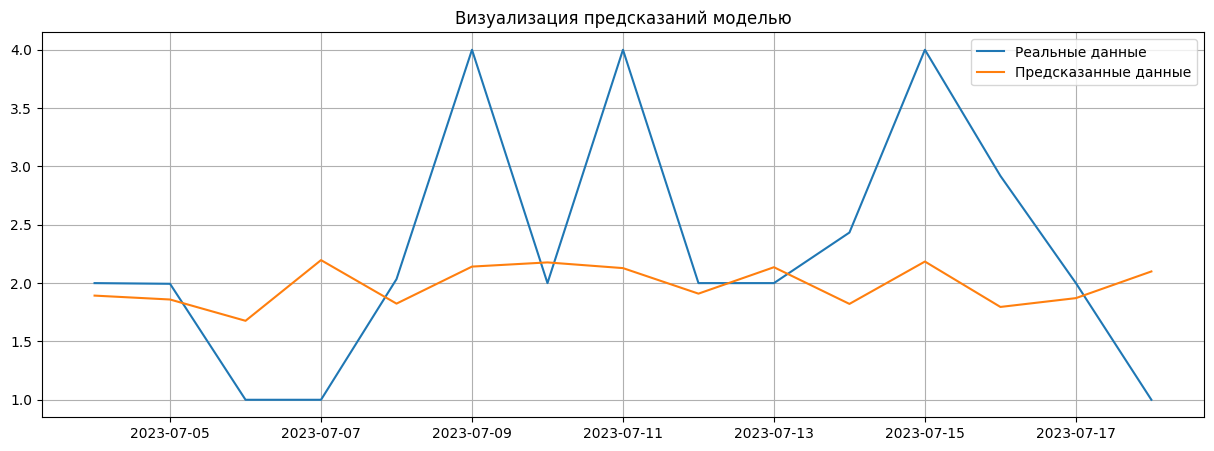

In [56]:
#Визуализация предсказаний модели
test['y_pred'] = l.predict(test.drop('y', axis = 1))

plt.figure(figsize=(15, 5))
plt.plot(test['y'], label = 'Реальные данные')
plt.plot(test['y_pred'], label = 'Предсказанные данные')
plt.grid(True)
plt.gca().legend()
plt.title(f'Визуализация предсказаний моделью');

На графиках сравнения предсказаний модели и реальных данных видно, что модель достаточно хорошо описывает данные, сглаживая пики.

In [71]:
def f_importances(coef, names, top=-1):
    
    """Функция для определения наиболее важных признаков с точки зрения модели"""
    
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    if top == -1:
        top = len(names)
    plt.figure(figsize=(12,5))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

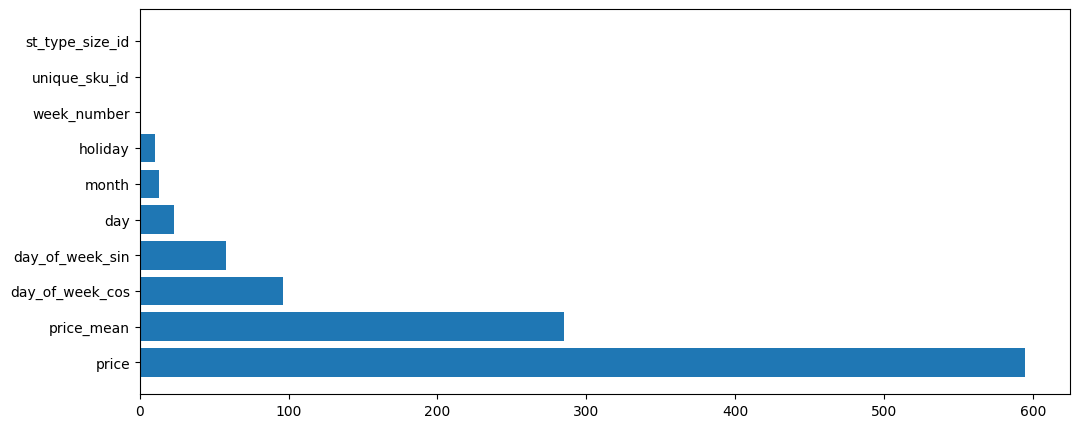

In [75]:
# График feature importances
f_importances(abs(l.feature_importances_), l.feature_name_, top=10)

Топ - 5 признаков для модели по графику feature importances:
 - price - цена
 - price_mean
 - day_of_week_cos
 - day_of_week_sin
 - day
 
На данный момент лучшие фичи - временные признаки (день недели) и признаки цены и средней цены. 

In [76]:
# Создаем объект explainer для модели и получаем значения shap_values
exp = shap.TreeExplainer(l)
sv = exp.shap_values(train.drop('y', axis = 1))

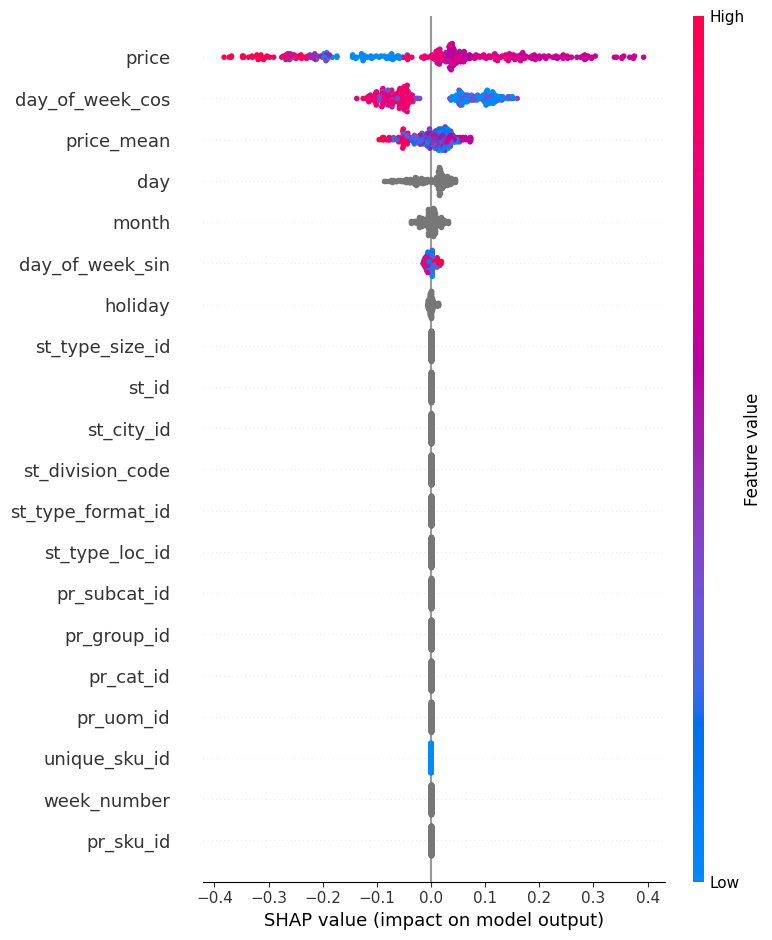

In [102]:
shap.summary_plot(sv, train.drop('y', axis = 1))

Было написано 3 класса:

- Preprocessor - класс для предобработки данных перед использованием моделей. Методы класса осуществляют базовую предобработку данных, включающую в себя загрузку данных из файлов, удаление ненужных признаков, удаление наблюдений, не соответствующих ТЗ, создание новых признаков вроде флага, является ли дата праздничным днем. На данном этапе возможно добавить информацию о погоде, но так как заказчик не предоставил данных о геолокации магазинов, это не представляется возможным.

После предварительной обработки осуществляется комбинированное заполнение пропусков. Для каждого товара в разрезе магазинов пропуски временного ряда заполнены с использованием библиотеки etna. Для значений вне этого диапазона, но в рамках датафрейма оставшиеся пропуски заполнены нулями.
Добавлены признаки средней цены для товара за всю историю в имеющихся данных и средней цены за последние 14 дней.
Добавлены дополнительные признаки, полученные с помощью модели FBProphet.

- Optimizer - класс для подбора гиперпараметров моделей регрессоров Catboost, XGBoost, LightGBM.
Реализован механизм разбиение датасета на фолды(мы использовали 3 фолда) для осуществления кросс-валидации. На основании данного разбиения реализован механизм подбора гиперпараметров для моделей градиентного бустинга в кросс-валидации. Потенциальные утечки данных устранены методами создания future датафрейма для предсказаний на каждом фолде.

- Predictor - класс осуществляет предсказания на основе всего датафрейма в будущее. Данный класс берёт лучшую модель по итогам кросс-валидации и осуществляет прогнозирование временных рядов с её помощью.

На основе трёх классов был создан собственный пайплайн, который принимает датасет и автоматически осуществляет все стадии работы путём последовательного применения всех классов и их методов.

В работе были проверены следующие бустинги:

- XGBRegressor;
- LGBMRegressor;
- CatBoostRegressor.

Метрики всех моделей получались очень близкими, поэтому было решено окончательно выбрать 1 модель по быстродействию - _ LGBMRegressor_.

**Получившиеся результаты:**
1. Для одного магазина и одного товара

| Model  | Metric WAPE | params |
|-------|--------|--------|
| XGBRegressor | 0.34 | {'learning_rate': 0.051663534589206285, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.8057802307388677, 'colsample_bytree': 0.6688426091682363} Lags: 21 |
| LGBMRegressor | 0.35 | {'learning_rate': 0.005355136958142169, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.48266399056341697, 'colsample_bytree': 0.7186521778796882} Lags: 35 |
| CatBoostRegressor | 0.35 | {'learning_rate': 0.005995893556028684, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5502953132612949, 'colsample_bytree': 0.30721765510860755} Lags: 21 |

2. Для моделей, обученных  на всех данных

| Model  | Metric WAPE | params |
|-------|--------|--------|
| LGBMRegressor | 0.74 |  {'learning_rate': 0.006220744752430538, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.6227066208927512, 'colsample_bytree': 0.10655018932206506} Lags: 21 |

Топ - 5 признаков для модели по графику feature importances:
 - price - цена
 - price_mean
 - day_of_week_cos
 - day_of_week_sin
 - day

shap опирается на те же признаки немного в другой последовательности.

На данный момент лучшие фичи - временные признаки (день недели) и признаки цены и средней цены. 

Поле для экспериментов:

1. Добавить признаки библиотеки TSFresh.
2. На данный момент лучшую метрику показывает стратегия когда обучается одна модель на каждую уникальную пару магазин - товар. Однако это не совсем эффективный подход. Мы планировали осуществить серию экспериментов при которых данные для обучения моделей разбивались бы по магазинам и товарам с учетом понимания того какие товары, группы товаров или магазины важно предсказывать точнее так как они вносят наибольший вклад в общую сумму продаж, а какие из товаров, групп, магазинов можно объединить и прогнозировать спрос для них одной моделью. 
3. Так как кластеризация показала, что внутри полученных кластеров временные ряды демонстрируют схожее поведение - это так же можно использовать для проведения экспериментов с целью получения разумного баланса между метрикой и количеством обучаемых моделей.